In [1]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX,RZ,X,I,Measure
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer,MQLayer,MQAnsatzOnlyOps
from mindquantum.simulator import Simulator
from mindspore.common.initializer import Normal,initializer
from mindspore import Tensor,ops
from mindspore import dtype as mstype
from mindspore.common.parameter import Parameter
from mindspore.nn import Adam, TrainOneStepCell                   

import networkx as nx
import mindspore.nn as nn
import mindspore as ms
import mindquantum as mq
import seaborn as sns
from math import pi


import matplotlib.pyplot as plt
import numpy as np
from math import pi
from mpl_toolkits.mplot3d import Axes3D




import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import time


import warnings
warnings.filterwarnings("ignore")

import logging
import sys
import datetime
 
def init_logger(filename, logger_name):
    '''
    @brief:
        initialize logger that redirect info to a file just in case we lost connection to the notebook
    @params:
        filename: to which file should we log all the info
        logger_name: an alias to the logger
    '''
 
    # get current timestamp
    timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
    
    logging.basicConfig(
        level=logging.INFO, 
        format='%(message)s',
#         format='%(message)s',
        handlers=[
            logging.FileHandler(filename=filename,encoding='utf-8'),
            logging.StreamHandler(sys.stdout)
        ]
    )
 
    # Test
    logger = logging.getLogger(logger_name)
   #logger.info('### Init. Logger {} ###'.format(logger_name))
    return logger


# Initialize
my_logger = init_logger("data/AQA/n = 14/ER/new, 3-regular/test_open.log", "ml_logger")

In [2]:
# Compute the circuit depth

# right 2021 Huawei Technologies Co., Ltd
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""DAG Circuit."""
import typing

from mindquantum.core import Circuit, gates
from mindquantum.utils.type_value_check import _check_input_type

# pylint: disable=invalid-name


class DAGNode:
    """
    Basic node in Directed Acyclic Graph.

    A DAG node has local index, which label the index of leg of node, and child nodes and father nodes.
    """

    def __init__(self):
        """Initialize a DAGNode object."""
        self.child: typing.Dict[int, "DAGNode"] = {}  # key: local index, value: child DAGNode
        self.father: typing.Dict[int, "DAGNode"] = {}  # key: local index, value: father DAGNode
        self.local: typing.List[int] = []

    def clean(self):
        """Clean node and set it to empty."""
        self.child = {}
        self.father = {}
        self.local = []

    def insert_after(self, other_node: "DAGNode"):
        """
        Insert other node after this dag node.

        Args:
            other_node (:class:`~.algorithm.compiler.DAGNode`): other DAG node.
        """
        _check_input_type("other_node", DAGNode, other_node)
        for local in self.local:
            if local in other_node.local:
                other_node.father[local] = self
                if local in self.child:
                    other_node.child[local] = self.child.get(local)
                    self.child.get(local).fathre[local] = other_node
                self.child[local] = other_node

    def insert_before(self, other_node: "DAGNode"):
        """
        Insert other node before this dag node.

        Args:
            other_node (:class:`~.algorithm.compiler.DAGNode`): other DAG node.
        """
        _check_input_type("other_node", DAGNode, other_node)
        for local in self.local:
            if local in other_node.local:
                other_node.child[local] = self
                if local in self.father:
                    other_node.father[local] = self.father.get(local)
                    self.father.get(local).child[local] = other_node
                self.father[local] = other_node


def connect_two_node(father_node: DAGNode, child_node: DAGNode, local_index: int):
    """
    Connect two DAG node through given local_index.

    Args:
        father_node (DAGNode): The father DAG node.
        child_node (DAGNode): The child DAG node.
        local_index (int): which leg you want to connect.
    """
    if local_index not in father_node.local or local_index not in child_node.local:
        raise ValueError(
            f"local_index {local_index} not in father_node" f" {father_node} or not in child_node {child_node}."
        )
    father_node.child[local_index] = child_node
    child_node.father[local_index] = father_node


class DAGQubitNode(DAGNode):
    """
    DAG node that work as quantum qubit.

    Args:
        qubit (int): id of qubit.
    """

    def __init__(self, qubit: int):
        """Initialize a DAGQubitNode object."""
        super().__init__()
        _check_input_type("qubit", int, qubit)
        self.qubit = qubit
        self.local = [qubit]

    def __str__(self):
        """Return a string representation of qubit node."""
        return f"q{self.qubit}"

    def __repr__(self):
        """Return a string representation of qubit node."""
        return self.__str__()


class GateNode(DAGNode):
    """
    DAG node that work as quantum gate.

    Args:
        gate (:class:`~.core.gates.BasicGate`): Quantum gate.
    """

    def __init__(self, gate: gates.BasicGate):
        """Initialize a GateNode object."""
        super().__init__()
        _check_input_type("gate", gates.BasicGate, gate)
        self.gate = gate
        self.local = gate.obj_qubits + gate.ctrl_qubits

    def __str__(self):
        """Return a string representation of gate node."""
        return str(self.gate)

    def __repr__(self):
        """Return a string representation of gate node."""
        return self.__str__()


class BarrierNode(GateNode):
    """DAG node that work as barrier."""

    def __init__(self, gate: gates.BasicGate, all_qubits: typing.List[int]):
        """Initialize a BarrierNode object."""
        super().__init__(gate)
        self.local = all_qubits


class DAGCircuit:
    """
    A Directed Acyclic Graph of a quantum circuit.

    Args:
        circuit (:class:`~.core.circuit.Circuit`): the input quantum circuit.

    Examples:
    from mindquantum.algorithm.compiler import DAGCircuit
    from mindquantum.core.circuit import Circuit
    circ = Circuit().h(0).x(1, 0)
    dag_circ = DAGCircuit(circ)
    dag_circ.head_node[0]
        q0
    dag_circ.head_node[0].child
        {0: H(0)}
    """

    def __init__(self, circuit: Circuit):
        """Initialize a DAGCircuit object."""
        _check_input_type("circuit", Circuit, circuit)
        self.head_node = {i: DAGQubitNode(i) for i in sorted(circuit.all_qubits.keys())}
        self.final_node = {i: DAGQubitNode(i) for i in sorted(circuit.all_qubits.keys())}
        for i in self.head_node:
            self.head_node[i].insert_after(self.final_node[i])
        for gate in circuit:
            if isinstance(gate, gates.BarrierGate):
                if gate.obj_qubits:
                    self.append_node(BarrierNode(gate, sorted(gate.obj_qubits)))
                else:
                    self.append_node(BarrierNode(gate, sorted(circuit.all_qubits.keys())))
            else:
                self.append_node(GateNode(gate))
        self.global_phase = gates.GlobalPhase(0)

    @staticmethod
    def replace_node_with_dag_circuit(node: DAGNode, coming: "DAGCircuit"):
        """
        Replace a node with a DAGCircuit.

        Args:
            node (:class:`~.algorithm.compiler.DAGNode`): the original DAG node.
            coming (:class:`~.algorithm.compiler.DAGCircuit`): the coming DAG circuit.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.core.circuit import Circuit
        circ = Circuit().x(1, 0)
        circ
            q0: ────■─────
                    ┃
                  ┏━┻━┓
            q1: ──┨╺╋╸┠───
                  ┗━━━┛
        dag_circ = DAGCircuit(circ)
        node = dag_circ.head_node[0].child[0]
        node
            X(1 <-: 0)
        sub_dag = DAGCircuit(Circuit().h(1).z(1, 0).h(1))
        DAGCircuit.replace_node_with_dag_circuit(node, sub_dag)
        dag_circ.to_circuit()
            q0: ──────────■───────────
                          ┃
                  ┏━━━┓ ┏━┻━┓ ┏━━━┓
            q1: ──┨ H ┠─┨ Z ┠─┨ H ┠───
                  ┗━━━┛ ┗━━━┛ ┗━━━┛
        """
        if set(node.local) != {head.qubit for head in coming.head_node.values()}:
            raise ValueError(f"Circuit in coming DAG is not aligned with gate in node: {node}")
        for local in node.local:
            connect_two_node(node.father[local], coming.head_node[local].child[local], local)
            connect_two_node(coming.final_node[local].father[local], node.child[local], local)

    def append_node(self, node: DAGNode):
        """
        Append a quantum gate node.

        Args:
            node (:class:`~.algorithm.compiler.DAGNode`): the DAG node you want to append.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit, GateNode
        from mindquantum.core.circuit import Circuit
        import mindquantum.core.gates as G
        circ = Circuit().h(0).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                        ┏━┻━┓
            q1: ────────┨╺╋╸┠───
                        ┗━━━┛
        dag_circ = DAGCircuit(circ)
        node = GateNode(G.RX('a').on(0, 2))
        dag_circ.append_node(node)
        dag_circ.to_circuit()
                  ┏━━━┓       ┏━━━━━━━┓
            q0: ──┨ H ┠───■───┨ RX(a) ┠───
                  ┗━━━┛   ┃   ┗━━━┳━━━┛
                        ┏━┻━┓     ┃
            q1: ────────┨╺╋╸┠─────╂───────
                        ┗━━━┛     ┃
                                  ┃
            q2: ──────────────────■───────
        """
        _check_input_type('node', DAGNode, node)
        for local in node.local:
            if local not in self.head_node:
                self.head_node[local] = DAGQubitNode(local)
                self.final_node[local] = DAGQubitNode(local)
                self.head_node[local].insert_after(self.final_node[local])
            self.final_node[local].insert_before(node)

    def depth(self) -> int:
        """
        Return the depth of quantum circuit.

        Examples:
        from mindquantum.core.circuit import Circuit
        from mindquantum.algorithm.compiler import DAGCircuit
        circ = Circuit().h(0).h(1).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        DAGCircuit(circ).depth()
            2
        """
        return len(self.layering())

    def find_all_gate_node(self) -> typing.List[GateNode]:
        """
        Find all gate node in this :class:`~.algorithm.compiler.DAGCircuit`.

        Returns:
            List[:class:`~.algorithm.compiler.GateNode`], a list of all :class:`~.algorithm.compiler.GateNode`
            of this :class:`~.algorithm.compiler.DAGCircuit`.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.core.circuit import Circuit
        circ = Circuit().h(0).x(1, 0)
        dag_circ = DAGCircuit(circ)
        dag_circ.find_all_gate_node()
            [H(0), X(1 <-: 0)]
        """
        found = set(self.head_node.values())

        def _find(current_node: DAGNode, found):
            if current_node not in found:
                found.add(current_node)
                for node in current_node.father.values():
                    _find(node, found)
                for node in current_node.child.values():
                    _find(node, found)

        for head_node in self.head_node.values():
            for current_node in head_node.child.values():
                _find(current_node, found)
        return [i for i in found if not isinstance(i, DAGQubitNode)]

    def layering(self) -> typing.List[Circuit]:
        r"""
        Layering the quantum circuit.

        Returns:
            List[:class:`~.core.circuit.Circuit`], a list of layered quantum circuit.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.utils import random_circuit
        circ = random_circuit(3, 5, seed=42)
        circ
                  ┏━━━━━━━━━━━━━┓   ┏━━━━━━━━━━━━━┓
            q0: ──┨             ┠─╳─┨ RY(-6.1944) ┠───────────────────
                  ┃             ┃ ┃ ┗━━━━━━┳━━━━━━┛
                  ┃ Rxx(1.2171) ┃ ┃        ┃        ┏━━━━━━━━━━━━━┓
            q1: ──┨             ┠─┃────────╂────────┨             ┠───
                  ┗━━━━━━━━━━━━━┛ ┃        ┃        ┃             ┃
                  ┏━━━━━━━━━━━━┓  ┃        ┃        ┃ Rzz(-0.552) ┃
            q2: ──┨ PS(2.6147) ┠──╳────────■────────┨             ┠───
                  ┗━━━━━━━━━━━━┛                    ┗━━━━━━━━━━━━━┛
        dag_circ = DAGCircuit(circ)
        for idx, c in enumerate(dag_circ.layering()):
            ...     print(f"layer {idx}:")
            ...     print(c)
            layer 0:
                  ┏━━━━━━━━━━━━━┓
            q0: ──┨             ┠───
                  ┃             ┃
                  ┃ Rxx(1.2171) ┃
            q1: ──┨             ┠───
                  ┗━━━━━━━━━━━━━┛
                  ┏━━━━━━━━━━━━┓
            q2: ──┨ PS(2.6147) ┠────
                  ┗━━━━━━━━━━━━┛
            layer 1:
            q0: ──╳───
                  ┃
                  ┃
            q2: ──╳───
            layer 2:
                  ┏━━━━━━━━━━━━━┓
            q0: ──┨ RY(-6.1944) ┠───
                  ┗━━━━━━┳━━━━━━┛
                         ┃
            q2: ─────────■──────────
            layer 3:
                  ┏━━━━━━━━━━━━━┓
            q1: ──┨             ┠───
                  ┃             ┃
                  ┃ Rzz(-0.552) ┃
            q2: ──┨             ┠───
                  ┗━━━━━━━━━━━━━┛
        """

        def _layering(current_node: GateNode, depth_map):
            """Layering the quantum circuit."""
            if current_node.father:
                prev_depth = []
                for father_node in current_node.father.values():
                    if father_node not in depth_map:
                        _layering(father_node, depth_map)
                    prev_depth.append(depth_map[father_node])
                depth_map[current_node] = max(prev_depth) + 1
            for child in current_node.child.values():
                if not isinstance(child, DAGQubitNode):
                    if child not in depth_map:
                        _layering(child, depth_map)

        depth_map = {i: 0 for i in self.head_node.values()}
        for current_node in self.head_node.values():
            _layering(current_node, depth_map)
        layer = [Circuit() for _ in range(len(set(depth_map.values())) - 1)]
        for k, v in depth_map.items():
            if v != 0:
                if not isinstance(k, BarrierNode):
                    layer[v - 1] += k.gate
        return [c for c in layer if len(c) != 0]

    def to_circuit(self) -> Circuit:
        """
        Convert :class:`~.algorithm.compiler.DAGCircuit` to quantum circuit.

        Returns:
            :class:`~.core.circuit.Circuit`, the quantum circuit of this DAG.

        Examples:
        from mindquantum.core.circuit import Circuit
        from mindquantum.algorithm.compiler import DAGCircuit
        circ = Circuit().h(0).h(1).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        dag_circ = DAGCircuit(circ)
        dag_circ.to_circuit()
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        """
        circuit = Circuit()
        considered_node = set(self.head_node.values())

        def adding_current_node(current_node, circuit, considered):
            if all(i in considered for i in current_node.father.values()) and not isinstance(
                current_node, DAGQubitNode
            ):
                circuit += current_node.gate
                considered.add(current_node)
            else:
                for node in current_node.father.values():
                    if node not in considered:
                        adding_current_node(node, circuit, considered)
                for node in current_node.child.values():
                    if node not in considered:
                        adding_current_node(node, circuit, considered)

        for current_node in self.final_node.values():
            adding_current_node(current_node, circuit, considered_node)
        return circuit

In [3]:
# Function to retrieve the neighboring nodes information for each node in graph g
def get_info_neighbors(g):
    info = {}  # Dictionary to store each node and its corresponding neighbors
    
    n = len(g.nodes())  # Get the number of nodes in the current subgraph
    # Loop through each node in the graph
    for k in g.nodes():
        neighbors = []  # List to store the neighbors of node k
        # Loop through each edge in the graph
        for u, v in g.edges:
            # If node k is the second node in the edge, append the first node as neighbor
            if v == k:
                neighbors.append(u)
            # If node k is the first node in the edge, append the second node as neighbor
            if u == k:
                neighbors.append(v)
        # Store node k and its neighbors in the dictionary 'info'
        info[k] = neighbors
#     my_logger.info('The information of nodes and their neighboring nodes is: {}'.format(info))
    return info





# Find the nodes with the minimum degree
def find_min_degree(target_graph):
    info = get_info_neighbors(target_graph)
    
    d = [] # Store the degree of each node
    for key,value in info.items():
        d.append(len(value))
    min_d = min(d)
    
    # Find the nodes with the minimum degree
    nodes = []
    for key,value in info.items():
        if len(value) == min_d:
            nodes.append(key)
#     my_logger.info('min_d = {}, nodes = {}'.format(min_d,nodes))
    return nodes

In [4]:
# Create a new graph by adding one new node and its associated edges to the old graph.
# Required parameters:
#   old_graph: the existing subgraph,
#   new_nodes: a list of new nodes to be added,
#   target_graph: the target graph from which the connectivity (degree) information is obtained.
def create_new_graph(old_graph, new_nodes, target_graph):
    new_E = []  # List to store the edges of the new graph.
    new_V = []  # List to store the vertices of the new graph.
    
    # Add all nodes from the old graph to new_V.
    for node in old_graph.nodes():
        new_V.append(node)
    
    # Add the new nodes and their associated edges.
    for i in range(len(new_nodes)):
        new_V.append(new_nodes[i])
    new_V.sort()  # Sort the vertices in ascending order.
    
    # Iterate over each edge in the target graph.
    for edge in target_graph.edges():
        u0 = edge[0]
        v0 = edge[1]  # The two vertices of the current edge.
        
        # If both endpoints of the edge exist in new_V, add the edge to new_E.
        if u0 in new_V and v0 in new_V:
            new_E.append(edge)
    
    my_logger.info('new_E = {}, new_V = {}'.format(new_E, new_V))
    
    # Create a new graph.
    new_graph = nx.Graph()
    new_graph.add_nodes_from(new_V)
    new_graph.add_edges_from(new_E)
    
    # Draw the generated graph.
    pos = nx.circular_layout(new_graph)
    options = {
        "with_labels": True,
        "font_size": 16,
        "font_weight": "bold",
        "font_color": "white",
        "node_size": 1000,
        "width": 2
    }
    nx.draw_networkx(new_graph, pos, **options)
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    plt.show()
    
    return new_graph, new_E, new_V


In [5]:
# Calculate m0 for candidate nodes, where m0 is the number of edges connecting a candidate node 'a'
# with the nodes already present in the current subgraph.

def calculate_m0(candidate_nodes, subgraph_nodes, target_graph):
    m0_edges = []  # List to store the m0 value corresponding to each candidate node.
    
    # For each candidate node, compute the count of edges (m0) that connect it to nodes in the subgraph.
    for j in range(0, len(candidate_nodes)):
        a = candidate_nodes[j]
        m0 = 0
        # Iterate through each edge in the target graph.
        for u, v in target_graph.edges():
            # Check if candidate node 'a' is incident to the edge.
            if u == a or v == a:
                # If one of the endpoints belongs to the current subgraph, count this edge.
                if u in subgraph_nodes or v in subgraph_nodes:
                    m0 = m0 + 1
        m0_edges.append(m0)
        
    # Determine the minimum m0 value among the candidate nodes.
    min_m0 = min(m0_edges)
    
    # Collect all candidate nodes whose m0 equals the minimum value.
    min_a = []
    for j in range(0, len(m0_edges)):
        if m0_edges[j] == min_m0:
            min_a.append(candidate_nodes[j])
    
    return min_m0, min_a


In [6]:
def find_new_node(old_graph, target_graph):
    """
    Finds a new node to add to the current subgraph (old_graph) based on the connection criterion.
    
    
    Inputs:
        old_graph:  A NetworkX graph representing the current subgraph.
        target_graph: A NetworkX graph representing the full graph from which a new node is to be selected.
    
    Outputs:
        - new_add_node: the selected node from target_graph to add to old_graph.
        - min_m0: the m0 value (number of edges connecting the candidate node to the subgraph)
                    corresponding to the chosen new node.
    """

    # Retrieve the nodes of the current subgraph (old_graph)
    subgraph_nodes = []
    for node in old_graph.nodes():
        subgraph_nodes.append(node)
    
    # Construct the candidate set: nodes in the target graph not currently in the subgraph.
    # For example, if target_graph has nodes [0, 1, 2] and subgraph_nodes = [0],
    # then candidate_nodes will be [1, 2].
    candidate_nodes = []
    for i in target_graph.nodes():
        if i not in subgraph_nodes:
            candidate_nodes.append(i)
    # my_logger.info('subgraph_nodes = {}, candidate_nodes = {}'.format(subgraph_nodes, candidate_nodes))
    
    # Calculate, for each candidate node, the m0 value (the number of edges connecting it
    # with any node in the current subgraph) using the calculate_m0 function.
    # min_m0 is the minimum m0 value and min_a is the list of candidate nodes achieving that m0.
    min_m0, min_a = calculate_m0(candidate_nodes, subgraph_nodes, target_graph)
    
    # If only one candidate node achieves the minimum m0, choose that node.
    if len(min_a) == 1:
        new_add_node = min_a[0]
    
    # If multiple candidate nodes have the same min_m0, perform a further analysis.
    else:
        # my_logger.info('Multiple candidate nodes have min_m0 = {}, details: min_a = {}'.format(min_m0, min_a))
        next_m0 = []  # To store the subsequent m0 values when each candidate from min_a is added to the subgraph.
        
        # For each candidate node in min_a, simulate adding it to the subgraph and
        # compute the resulting m0 (next_min_m0) for the new candidate set.
        for i0 in range(0, len(min_a)):
            # Reset subgraph_nodes to the original nodes in old_graph
            subgraph_nodes = []
            for node in old_graph.nodes():
                subgraph_nodes.append(node)
            
            # Append the candidate node from min_a to the subgraph
            subgraph_nodes.append(min_a[i0])
            
            # Construct a new candidate set: nodes in target_graph not in the updated subgraph.
            candidate_nodes = []
            for i in target_graph.nodes():
                if i not in subgraph_nodes:
                    candidate_nodes.append(i)
            
            # Calculate the m0 for the updated candidate set with the new subgraph.
            min_m0, next_min_a = calculate_m0(candidate_nodes, subgraph_nodes, target_graph)
            # print('next_min_m0 = {}, next_min_a = {}'.format(min_m0, next_min_a))
            next_m0.append(min_m0)
        
        # Determine the minimum next-step m0 among the simulated choices.
        min_next_m0 = min(next_m0)
        # my_logger.info('For candidates in min_a = {} the corresponding next m0 values are {}'.format(min_a, next_m0))
        
        # Store candidate nodes that achieve the minimum next-step m0.
        s = []
        for index in range(0, len(next_m0)):
            if next_m0[index] == min_next_m0:
                s.append(min_a[index])
        # my_logger.info('Candidates satisfying both criteria (min_m0 and next m0) are: s = {}'.format(s))
        
        # If there is only one candidate satisfying both criteria, select it.
        if len(s) == 1:
            new_add_node = s[0]
        else:
            # If multiple candidates remain, select one at random.
            index0 = random.randint(0, len(s) - 1)
            new_add_node = s[index0]
            
    return new_add_node, min_m0


In [7]:
def construct_graph(old_graph, target_graph):
    """
    Incrementally constructs a new graph by adding one vertex at a time from the target_graph 
    to the current subgraph (old_graph).
    
    
    Inputs:
        old_graph:   The current subgraph (a NetworkX graph) that is being incrementally constructed.
        target_graph: The target graph (a NetworkX graph) from which vertices and edge connectivity
                      information are derived.
    
    Outputs:
        Returns new_graph, the updated graph after the addition of one new vertex. 
    """
    # Get the number of nodes in the current graph (old_graph)
    old_num_nodes = old_graph.number_of_nodes()  
    # Get the total number of nodes in the target graph
    target_num_nodes = target_graph.number_of_nodes()  
    new_nodes = []  # Initialize list to store the new node(s) to be added

    # Check if the current graph already equals the target graph
    if old_num_nodes == target_num_nodes:
        my_logger.info('The current graph is the target graph.')
    else:
        # Obtain the next node to add (based on connection criterion) 
        new_add_node, min_m0 = find_new_node(old_graph, target_graph)
        new_nodes.append(new_add_node)
    
    # Construct a new graph by adding the new nodes (and associated edges) to the old graph
    new_graph, new_E, new_V = create_new_graph(old_graph, new_nodes, target_graph)
    return new_graph


In [8]:
# Build the initial subgraph from the target graph.
def build_initial_graph(t):
    """
    Constructs an initial subgraph by selecting one or more nodes from the target graph.
    The process starts by choosing a node with the minimum degree as the starting point,
    and then incrementally adds nodes to the subgraph based on criteria designed to minimize
    the connection (edge count) between the new node and the existing subgraph. 
    
    Inputs:
        t: The desired number of nodes for the initial subgraph.
    
    Outputs:
        V0: A sorted list of nodes in the constructed initial subgraph.
        E0: The edges of the constructed initial subgraph.
    """

    # Check if the number of nodes in the target graph is not equal to t.
    if t != len(V):
        # Find the node(s) in the target graph with the smallest degree to use as the initial node.
        nodes = find_min_degree(target_graph)
        # If there is only one node with the minimum degree, choose it.
        if len(nodes) == 1:
            first_node = nodes[0]
        else:
            # If there are multiple nodes with the same minimum degree, further select the one that,
            # when added, results in the fewest additional edges (lowest m0 value) in subsequent steps.
            min_m = []  # To store the next-step m0 values corresponding to each candidate as the first node.
            for node in range(0, len(nodes)):
                old_V = []
                old_E = []
                # Create a temporary subgraph containing the candidate node.
                old_V.append(nodes[node]) 
                old_graph = nx.Graph()
                old_graph.add_nodes_from(old_V)
                old_graph.add_edges_from(old_E)
                # Calculate the m0 value if the candidate node is added.
                new_add_node, min_m0 = find_new_node(old_graph, target_graph)
                # my_logger.info('If node = {} is chosen as the first node, then after two steps min_m0 = {}'.format(nodes[node], min_m0))
                # my_logger.info('\n')
                min_m.append(min_m0)

            # From the candidate nodes with minimum degree, select those that yield the smallest m0.
            s = []  
            for index in range(0, len(min_m)):
                if min_m[index] == min(min_m):
                    s.append(nodes[index])  # Candidate nodes satisfying both the minimum degree and minimum m0 criteria.
            # my_logger.info('The candidate nodes satisfying minimum degree and minimum m0 criteria are: s = {}'.format(s))
            # my_logger.info('\n')

            # If only one candidate remains, select it; otherwise, randomly choose one.
            if len(s) == 1:
                first_node = s[0]
            else:
                index0 = random.randint(0, len(s) - 1)
                first_node = s[index0]

        # With the selected first node, build the initial subgraph.
        # The chosen first node satisfies:
        #   (1) It has the minimum degree in the target graph.
        #   (2) Its addition minimizes the number of edges in further steps of expanding the subgraph.
        old_V = []
        old_E = []
        old_V.append(first_node)
        old_graph = nx.Graph()
        old_graph.add_nodes_from(old_V)
        old_graph.add_edges_from(old_E)  

        t0 = len(old_V)  # The current number of nodes in the subgraph.

        # Incrementally add nodes until the subgraph reaches the desired size t.
        for i in range(0, t - t0):
            new_graph = construct_graph(old_graph, target_graph)
            old_graph = new_graph
    else:
        # If the desired number of nodes equals the number of nodes in the target graph,
        # the subgraph is simply the target graph.
        old_graph = nx.Graph()
        old_graph = target_graph
    
    # Get the list of nodes from the final subgraph and sort them.
    V0 = list(old_graph.nodes())
    V0.sort()  # Ensure nodes are sorted in ascending order.
    
    # Retrieve the edges of the final subgraph.
    E0 = old_graph.edges()
    
    return V0, E0


In [9]:
# Create initial state
def create_encoder():
    encoder = Circuit()
    return encoder



# Build the circuit U_HD corresponding to the target Hamiltonian H_D, with parameter gamma.
def build_U_HD(layer, g, target_graph):
    """
    Constructs the U_HD circuit for the target Hamiltonian with a given gamma parameter at a specified layer.

    Function:
        For each node in the provided subgraph g, an RZ rotation gate is applied with a parameter
        named 'gamma{layer}'. A barrier is added after all such gates.

    Inputs:
        layer: An integer specifying the current QAOA layer.
        g: A NetworkX graph or an object that has a property 'nodes' representing the nodes of the subgraph.
        target_graph: The target graph from which the Hamiltonian is derived. (Not used directly in this function)

    Outputs:
        Returns a tuple (cir_HD, RZ_gates) where:
            - cir_HD: The constructed circuit (of type Circuit) with RZ gates applied to all nodes.
            - RZ_gates: The number of RZ gates used.
    """
    RZ_gates = 0  # Counter for the number of RZ gates used.
    
    # Initialize an empty quantum circuit.
    cir_HD = Circuit()
    
    # Apply an RZ gate with parameter 'gamma{layer}' on each node in the graph g.
    for v in g.nodes:
        cir_HD += RZ('gamma{}'.format(layer)).on(v)
        RZ_gates += 1
        
    # Add a barrier for circuit separation.
    cir_HD.barrier()
    
    return cir_HD, RZ_gates


# Build the circuit U_HM corresponding to the mixing Hamiltonian H_M, with parameter beta.
def build_U_HM(layer, info, g, target_graph):
    """
    Constructs the U_HM circuit for the mixing Hamiltonian with a given beta parameter at a specified layer.

    Function:
        This function uses the neighboring node information provided in 'info' to build a multi-qubit controlled 
        RX gate for each node with at least one neighbor. The gate is applied conditionally: only when the states of 
        all the neighboring nodes (controlled by applying X gates beforehand) are 1. If a node has no neighbors (an isolated node),
        a standard RX gate is applied directly.
    
    Inputs:
        layer: An integer specifying the current QAOA layer.
        info: A dictionary containing neighboring node information for each node (obtained from get_info_neighbors).
        g: A NetworkX graph or similar object representing the current subgraph.
        target_graph: The target graph from which the Hamiltonian information is derived.

    Outputs:
        Returns a tuple (cir_HM, multi_gates, RX_gates) where:
            - cir_HM: The constructed circuit (of type Circuit) for the mixing Hamiltonian.
            - multi_gates: The number of multi-qubit controlled RX gates used.
            - RX_gates: The number of single-qubit RX gates used.
    """
    n = len(target_graph.nodes())
    
    # Counters for the number of multi-qubit controlled gates and single-qubit RX gates.
    multi_gates = 0
    RX_gates = 0
    
    # Initialize an empty quantum circuit for n qubits.
    # Note: The underlying quantum framework (mindquantum) allows directly implementing controlled single-qubit rotations without ancillary qubits.
    cir_HM = Circuit()
    
    # For each node (key) and its neighbor information (value) in the info dictionary:
    for key, value in info.items():
        if len(value) != 0:
            # Flip the state of neighboring qubits using X gates.
            for i in range(0, len(value)):
                cir_HM += X.on(value[i])
            
            # Apply a multi-qubit controlled RX gate on 'key' with parameter 'beta{layer}'.
            # The RX gate is executed only if all the flipped neighboring qubits are in the |1> state.
            cir_HM += RX('beta{}'.format(layer)).on(key, value)
            multi_gates += 1
            
            # Revert the X gate flips on the neighboring qubits.
            for i in range(0, len(value)):
                cir_HM += X.on(value[i])
            
            # Add a barrier after processing this node.
            cir_HM.barrier()
        else:
            # For an isolated node (no neighbors), apply a simple RX gate with parameter 'beta{layer}'.
            cir_HM += RX('beta{}'.format(layer)).on(key)
            cir_HM.barrier()
            RX_gates += 1
              
    return cir_HM, multi_gates, RX_gates


# Build a P-layer QAOA ansatz.
def build_ansatz(p, g, target_graph):
    """
    Constructs a QAOA ansatz with p layers.

    Function:
        This function first prepares an initial feasible state (encoder) and retrieves neighboring node information.
        Then, for each layer from 1 to p, it constructs the target Hamiltonian circuit U_HD (with RZ gates) 
        and the mixing Hamiltonian circuit U_HM (with RX gates and multi-qubit controlled rotations) and
        appends them to the overall ansatz. It also keeps track of the total number of RX, RZ, and multi-qubit gates used.
    
    Inputs:
        p: An integer representing the number of QAOA layers.
        g: The current subgraph (used for constructing the circuits).
        target_graph: The target graph from which Hamiltonian information is derived.
    
    Outputs:
        Returns a tuple (encoder, ansatz, RX_gates, RZ_gates, multi_gates) where:
            - encoder: The initial state preparation circuit.
            - ansatz: The full QAOA circuit ansatz with p layers.
            - RX_gates: Total count of RX gates used.
            - RZ_gates: Total count of RZ gates used.
            - multi_gates: Total count of multi-qubit controlled gates used.
    """
    print(g.nodes())
    # Prepare the initial encoder state; any feasible state is acceptable.
    encoder = create_encoder()
    
    # Retrieve the neighboring node information for constructing the circuits.
    info = get_info_neighbors(g)
    
    # Counters for gates.
    RX_gates = 0
    RZ_gates = 0
    multi_gates = 0
    
    # Initialize an empty circuit for the QAOA ansatz.
    ansatz = Circuit()
    
    # Build the QAOA circuit layer by layer.
    for layer in range(1, p + 1):
        # Construct the target Hamiltonian circuit for the current layer.
        circ_HD, RZ_gates0 = build_U_HD(layer, g, target_graph)
        # Construct the mixing Hamiltonian circuit for the current layer.
        circ_HM, multi_gates0, RX_gates0 = build_U_HM(layer, info, g, target_graph)
        ansatz += circ_HD
        ansatz += circ_HM
        
        # Accumulate the gate counts.
        RX_gates += RX_gates0
        RZ_gates += RZ_gates0
        multi_gates += multi_gates0
        
        # Add a barrier after each layer.
        ansatz.barrier()

    return encoder, ansatz, RX_gates, RZ_gates, multi_gates






class MQAnsatzOnlyLayer(nn.Cell):
    def __init__(self, expectation_with_grad,params, weight='normal'):
        """Initialize a MQAnsatzOnlyLayer object."""
        super().__init__()
        self.evolution = MQAnsatzOnlyOps(expectation_with_grad)
        weight_size = len(self.evolution.expectation_with_grad.ansatz_params_name)
#         print('weight_size = {} '.format(weight_size))

        if isinstance(weight, ms.Tensor):
            if weight.ndim != 1 or weight.shape[0] != weight_size:
                raise ValueError(f"Weight init shape error, required ({weight_size}, ), but get f{weight.shape}.")
        
        
        self.weight =  Parameter(params.astype(np.float32), name='ansatz_weight')
        my_logger.info('weight = {}'.format(self.weight.asnumpy()))
        

    def construct(self):
        """Construct a MQAnsatzOnlyLayer node."""
        return self.evolution(self.weight)

In [10]:
def calculate_initial_expectation_value(g, layer, beta, gamma):
    """
    Calculates the expectation value of the target Hamiltonian for the constructed QAOA circuit,
    given the parameters beta and gamma.


    Inputs:
        g: The current subgraph (NetworkX graph) on which the Hamiltonian is defined.
        layer: The current QAOA layer count (or number of layers) to build the ansatz.
        beta: A list of beta parameters used in constructing the mixing Hamiltonian part of the ansatz.
        gamma: A list of gamma parameters used in constructing the target Hamiltonian part of the ansatz.

    Outputs:
        Returns the negative real part of the expectation value of the Hamiltonian (a real number).
    
    Parameter Details:
        - beta and gamma: The variational parameters for QAOA; these are interleaved into one parameter list.
        - g: The graph structure which determines the Hamiltonian.
        - layer: Determines the depth of the QAOA ansatz circuit.
    """
    # Combine parameters: store gamma parameters first, followed by beta parameters.
    params = []
    for i in range(len(beta)):
        params.append(gamma[i])
        params.append(beta[i])
        
    # Build the QAOA ansatz circuit using the specified number of layers, the current subgraph g,
    # and the target graph (assumed to be defined globally as target_graph).
    encoder, ansatz, RX_gates, RZ_gates, multi_gates = build_ansatz(layer, g, target_graph)
    # Concatenate the encoder circuit with the QAOA ansatz circuit.
    circ = encoder + ansatz
    circ.as_ansatz()  # Mark the circuit as an ansatz (if required by the framework).
    
    # Initialize the simulator; here using 'mqvector' backend for simulating the circuit,
    # and using the number of qubits in 'circ'.
    sim = Simulator('mqvector', circ.n_qubits)
    
    # Build the Hamiltonian corresponding to graph g.
    ham = build_ham(g)
    print(ham)
    
    # Create a parameter resolver: a dictionary that maps each parameter name in the circuit
    # to its corresponding value from the params list.
    pr = dict(zip(circ.params_name, params))
    
    # Apply the circuit on the simulator with the resolved parameters.
    sim.apply_circuit(circ, pr=pr)
    # Optionally, one could print the quantum state using:
    # print(sim.get_qs(True))
    
    # Compute the expectation value of the Hamiltonian.
    expectation = sim.get_expectation(ham)
    
    # Return the negative real part of the expectation value.
    return -1 * (expectation.real)


In [11]:
def execute_function(g, layer, beta, gamma):
    """
    Execute the optimization of the QAOA circuit by iteratively updating the variational parameters
    until convergence based on a convergence error criterion.


    Inputs:
        g:           The current subgraph (a NetworkX graph or similar) used to build the Hamiltonian.
        layer:       An integer representing the number of QAOA layers (depth) to construct the ansatz circuit.
        beta:        A list of beta parameters for the mixing Hamiltonian part.
        gamma:       A list of gamma parameters for the target Hamiltonian part.

    Outputs:
        Returns a tuple containing:
            - result:         The measurement result from sampling the optimized circuit (after adding measurements).
            - gamma_opt:      The optimized gamma parameters (list).
            - beta_opt:       The optimized beta parameters (list).
            - final_loss:     The final (negative) expectation value of the Hamiltonian after optimization.
            - loss0:          A list storing the evolution of the loss (expectation value) during training.
            - qubits0:        A list containing the number of qubits used (which equals the number of nodes in g).
            - circuit_depth:  A list containing the circuit depth (estimated by DAGCircuit for shallow circuits).
            - quantum_gates:  A list of lists recording counts of [RX_gates, RZ_gates, multi-qubit controlled gates] used.
    """
    
    # Set the learning rate and maximum iteration count. ITR is the maximum number of iterations;
    # if convergence error is not reached within ITR iterations, optimization stops.
    lr = 0.05
    ITR = 600
    
    # Combine parameters: store gamma parameters first, then beta parameters.
    params = []
    for i in range(0, len(beta)):
        params.append(gamma[i])
        params.append(beta[i])
    
    # Initialize lists to record resource metrics:
    quantum_gates = []  # List to store the count of quantum gates used.
    circuit_depth = []  # List to store the estimated circuit depth.
    qubits0 = []        # List to store the number of qubits used.
    
    # Set MindSpore context to PYNATIVE_MODE, targeting CPU.
    ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
    
    # Build the QAOA circuit:
    # First, create the QAOA ansatz by calling build_ansatz.
    # (Note: The commented code for generating a uniform superposition state via H gates is not used.)
    encoder, ansatz, RX_gates, RZ_gates, multi_gates = build_ansatz(layer, g, target_graph)
    # Concatenate the encoder (initial state preparation) circuit with the ansatz circuit.
    circ = encoder + ansatz
    print(circ.summary())
    # Optionally, one can export the circuit diagram as an SVG file.
    # circ.svg().to_file(filename='Circuit_{}.svg'.format(len(g.nodes())))
    
    # Record resource metrics:
    qubits0.append(len(list(g.nodes())))  # The number of qubits equals the number of nodes in g.
    if layer <= 6:
        # If the circuit is shallow enough, estimate its depth using DAGCircuit.
        circuit_depth.append(DAGCircuit(circ).depth())
    else:
        circuit_depth.append(1000)  # Use 1000 as a placeholder for "depth cannot be estimated" for deep circuits.
    quantum_gates.append([RX_gates, RZ_gates, multi_gates])
    
    # Convert the parameters list to a NumPy array.
    params = np.array(params)
    
    # Create a simulator using the 'mqvector' backend for the number of qubits in circ.
    sim = Simulator('mqvector', circ.n_qubits)
    # Build the Hamiltonian corresponding to graph g.
    ham = build_ham(g)
    
    # Calculate the initial expectation value of the Hamiltonian for the given parameters.
    initial_expectation_value = calculate_initial_expectation_value(g, layer, beta, gamma)
    my_logger.info('initial_ex = {}'.format(initial_expectation_value))
    
    # Obtain the expectation value and gradient operators for the Hamiltonian and circuit.
    # The 'parallel_worker' parameter specifies the number of parallel workers to use.
    grad_ops = sim.get_expectation_with_grad(ham, circ, parallel_worker=2)
    # Wrap the gradient operators and initial parameters into the QuantumNet model.
    QuantumNet = MQAnsatzOnlyLayer((grad_ops), params)
    
    # Set up the Adam optimizer for the trainable parameters of QuantumNet with the specified learning rate.
    opti = Adam(QuantumNet.trainable_params(), learning_rate=lr)
    # Create a training cell that performs one optimization step.
    train_net = nn.TrainOneStepCell(QuantumNet, opti)
    
    loss0 = []  # List to store the loss (expectation value) during the training iterations.
    for i in range(0, ITR + 1):
        # Execute one training step; train_net() returns a Tensor containing the updated loss value.
        loss = train_net().asnumpy()[0]
        loss0.append(loss)
        
        if i >= 2:
            l = len(loss0)
            delta1 = abs(loss0[l - 1] - loss0[l - 2])
            delta2 = abs(loss0[l - 2] - loss0[l - 3])
            # Check convergence: if the change in loss over two successive steps is below 0.001,
            # consider the optimization as converged.
            if delta1 <= 0.001 and delta2 <= 0.001:
                my_logger.info('Convergence reached after {} iterations, with loss evolution: {}'.format(len(loss0), loss0))
                break
            else:
                # Every 50 iterations, log the current training step and loss value.
                if i % 50 == 0:
                    my_logger.info("train_step = {}, loss = {}".format(i, round(loss, 5)))
    
    # Retrieve the optimized parameters from the model.
    beta_opt = []
    gamma_opt = []
    params = []
    
    # Get the circuit parameters from QuantumNet's weights, mapping the parameter names to their values.
    pr = dict(zip(ansatz.params_name, QuantumNet.weight.asnumpy()))
    for key, value in pr.items():
        params.append(value)
    my_logger.info('Optimized circuit parameters: params = {}'.format(params))
    
    # Separate the combined parameter list into gamma_opt and beta_opt.
    for i in range(0, len(params)):
        if i % 2 == 0:
            gamma_opt.append(params[i])
        else:
            beta_opt.append(params[i])
       
    # Append measurement operations to each qubit (node) in the graph.
    for i in g.nodes():
        circ += Measure('q_{}'.format(i)).on(i)  # Apply a measurement on qubit corresponding to node i.
    
    # Optionally, one can export the final circuit diagram as an SVG file.
    # circ.svg().to_file(filename='Circuit{}.svg'.format(len(g.nodes())))
    
    # Sample the circuit with the optimized parameters, taking 1000 shots.
    result = sim.sampling(circ, pr=pr, shots=1000)
    
    # Return the sampling result, the optimized gamma and beta parameters,
    # the final loss (converted to positive by multiplying by -1), the loss evolution list,
    # and the resource metrics: number of qubits, circuit depth, and gate counts.
    return result, gamma_opt, beta_opt, -round(loss, 5), loss0, qubits0, circuit_depth, quantum_gates


In [12]:
def global_training(ham,g,p,SEED):
    minval = Tensor(0, ms.float32)
    maxval = Tensor(np.pi, ms.float32)
    shape = tuple([1])
    
    # 存储初始参数的列表
    initial_beta = []
    initial_gamma = []

    # 随机初始化初始参数
    for i in range(0,p) :
        param = ops.uniform(shape,minval,maxval,seed= SEED,dtype=ms.float32)
        initial_beta.append(param.asnumpy()[0])

        param = ops.uniform(shape,minval,maxval,seed= SEED,dtype=ms.float32)
        initial_gamma.append(param.asnumpy()[0])
    my_logger.info('SEED = {},initial_beta = {},initial_gamma = {}'.format(SEED,initial_beta,initial_gamma))
        
    # Parameter optimization
    # Get the optimized parameters
    result,gamma_opt,beta_opt,loss,loss0,qubits0,circuit_depth,quantum_gates = execute_function(g,p,initial_beta,initial_gamma)
    return result,gamma_opt,beta_opt,loss,loss0

In [13]:
# Construct the target Hamiltonian
def build_ham(g):
    ham = QubitOperator()
    for i in g.nodes:
        ham += QubitOperator(f'Z{i}',0.5)
        ham += QubitOperator(f'Z{i} Z{i}',-0.5) # I operator
    ham = Hamiltonian(ham)
    return ham




def search_optimized_parameters(g, p, counts, SEED):
    """
    Searches for the optimized parameters under a fixed circuit depth by performing multiple
    global random initializations, and returns the parameters corresponding to the maximum loss,
    as well as the associated expectation value and iteration statistics.
    
    Function:
        1. Builds the Hamiltonian for the current graph g.
        2. Repeatedly (for 'counts' times) performs a global random initialization and subsequent training
           (via global_training) to optimize the QAOA parameters.
        3. For each random initialization, collects the final expectation value (loss), optimized parameters
           (beta_opt and gamma_opt), measurement result, and number of iterations consumed.
        4. Computes the average loss and average iterations over all random initializations.
        5. Identifies the maximum loss value and extracts the corresponding optimized parameters and seed.
    
    Inputs:
        g:       The current subgraph (a NetworkX graph) for which the Hamiltonian is built.
        p:       The number of QAOA layers (or circuit depth) used in the ansatz.
        counts:  An integer specifying the number of global random initializations to be performed.
        SEED:    A list of seed values to be used for each random initialization.
    
    Outputs:
        Returns a tuple (params_opt, max_loss, avg, avg_iterations) where:
            - params_opt:  The optimized parameters [beta_opt, gamma_opt] corresponding to the maximum loss.
            - max_loss:    The maximum expectation (loss) value achieved among all initializations.
            - avg:         The average expectation (loss) value across all runs.
            - avg_iterations: The average number of iterations consumed during the optimization process.
    """
    
    ham = build_ham(g)  # Build the target Hamiltonian for the graph g.

    value = []           # List to store the expectation values (loss) after optimization for each initialization.
    params = []          # List to store the optimized parameters [beta_opt, gamma_opt] for each run.
    measure_result = []  # List to store the measurement results.
    consumed_iterations = []  # List to store the number of iterations consumed in each run.

    # Perform global random initialization 'counts' times.
    for i in range(1, counts + 1):
        my_logger.info('\n\n')
        my_logger.info('The {}-th global random initialization'.format(i))
        # Run global training with the specified Hamiltonian, graph, QAOA layers, and seed.
        result, gamma_opt, beta_opt, loss, loss0 = global_training(ham, g, p, SEED[i - 1])
        
        value.append(loss)
        params.append([beta_opt, gamma_opt])
        measure_result.append(result.data)
        consumed_iterations.append(len(loss0))

    my_logger.info('value = {}'.format(value))
    my_logger.info('\n\n')
    
    my_logger.info('params = [[beta_optimized, gamma_optimized], ...] = {}'.format(params))
    my_logger.info('\n\n')
    
    my_logger.info('measure_result = {}'.format(measure_result))
    my_logger.info('\n\n')
    
    my_logger.info('consumed_iterations = {}'.format(consumed_iterations))
    my_logger.info('\n\n')
    
    # Calculate the average expectation (loss) value.
    avg = 0
    for index in range(0, len(value)):
        avg += value[index]
    avg = avg / len(value)
    avg = round(avg, 5)
    my_logger.info('avg_loss = {}'.format(avg))
    
    # Calculate the average number of iterations consumed.
    avg_iterations = 0
    for j in range(0, len(consumed_iterations)):
        avg_iterations += consumed_iterations[j]
    avg_iterations = avg_iterations / len(consumed_iterations)
    avg_iterations = round(avg_iterations, 5)
    my_logger.info('Average iterations consumed across global random initializations: avg_iterations = {}'.format(avg_iterations))
    
    # Identify the maximum expectation (loss) value obtained from the multiple initializations.
    max_loss = max(value)
    my_logger.info('max_loss = {}'.format(max_loss))
    params_opt = []  # List to store the optimized parameters corresponding to max_loss.
    SEED_opt = []    # List to store the seed values that produced max_loss.

    for j in range(0, len(value)):
        if value[j] == max_loss:
            params_opt.append(params[j])
            SEED_opt.append(SEED[j])
    my_logger.info('Optimized parameters corresponding to max_loss: params_opt = {}'.format(params_opt))
    my_logger.info('\n\n')
    my_logger.info('SEED_opt = {}'.format(SEED_opt))
    
    return params_opt, max_loss, avg, avg_iterations

In [14]:
# n = 14，prob = 0.4
# E = [(0, 1), (0, 3), (0, 5), (0, 6), (0, 7), (0, 10), (0, 11), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 11), (1, 12), (2, 3), (2, 5), (2, 6), (2, 7), (2, 10), (2, 11), (3, 8), (3, 10), (3, 12), (3, 13), (4, 6), (4, 8), (4, 9), (4, 11), (4, 12), (4, 13), (5, 6), (5, 7), (5, 8), (5, 10), (5, 11), (5, 13), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (7, 11), (7, 12), (7, 13), (8, 9), (8, 11), (9, 10), (9, 11), (9, 12), (9, 13), (10, 12), (10, 13), (11, 12), (12, 13)] # graph

# E = [(0, 1), (0, 2), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (1, 3), (1, 5), (1, 6), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (2, 4), (2, 7), (2, 8), (2, 10), (3, 4), (3, 7), (3, 13), (4, 8), (4, 9), (4, 12), (4, 13), (5, 6), (5, 7), (5, 9), (5, 10), (5, 11), (5, 12), (6, 7), (6, 8), (6, 9), (6, 11), (6, 12), (6, 13), (7, 8), (7, 9), (7, 10), (7, 11), (7, 13), (8, 9), (8, 12), (10, 11), (10, 12), (11, 12), (11, 13), (12, 13)] # graph2, m = 52

# E = [(0, 1), (0, 2), (0, 5), (0, 6), (0, 8), (0, 10), (0, 11), (0, 12), (1, 2), (1, 4), (1, 5), (1, 7), (1, 8), (1, 9), (1, 10), (1, 13), (2, 3), (2, 6), (2, 8), (3, 6), (3, 7), (3, 9), (3, 10), (3, 12), (3, 13), (4, 5), (4, 6), (4, 7), (4, 10), (4, 11), (4, 12), (4, 13), (5, 6), (5, 7), (5, 8), (5, 10), (5, 11), (5, 13), (6, 10), (6, 11), (6, 13), (7, 8), (7, 10), (7, 11), (7, 12), (8, 9), (8, 10), (8, 12), (9, 10), (9, 13), (10, 13), (11, 12), (12, 13)] # graph3, m = 53

# E = [(0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 5), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 3), (2, 4), (2, 6), (2, 9), (2, 11), (2, 12), (2, 13), (3, 4), (3, 5), (3, 6), (3, 8), (3, 10), (3, 11), (3, 12), (4, 5), (4, 6), (4, 7), (4, 9), (4, 11), (4, 12), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 12), (5, 13), (6, 7), (6, 9), (6, 12), (6, 13), (7, 8), (7, 9), (7, 10), (7, 11), (7, 13), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (9, 10), (9, 11), (9, 13), (10, 11), (10, 12), (10, 13), (11, 12), (12, 13)] # graph4, m = 66

# E = [(0, 1), (0, 2), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 12), (1, 3), (1, 5), (1, 6), (1, 9), (1, 11), (1, 12), (1, 13), (2, 3), (2, 4), (2, 5), (2, 6), (2, 8), (3, 5), (3, 8), (3, 10), (3, 12), (4, 8), (4, 9), (4, 11), (4, 12), (5, 7), (5, 9), (5, 11), (5, 12), (6, 7), (6, 10), (6, 11), (6, 12), (7, 10), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (9, 10), (9, 11), (9, 13), (10, 12), (10, 13), (11, 13), (12, 13)] # graph5, m = 51

In [15]:
# 新生成的15个14顶点的ER，prob=0.4图 ，beta = [4, 3, 4, 4, 4,    4, 6, 4, 5, 4,   4, 4, 4, 4, 4]
# E0 = [[(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 13), (1, 5), (1, 6), (1, 7), (1, 9), (1, 10), (1, 11), (2, 3), (2, 4), (2, 6), (2, 7), (2, 11), (2, 13), (3, 5), (3, 8), (3, 9), (3, 11), (3, 12), (3, 13), (4, 5), (4, 10), (4, 12), (5, 6), (5, 7), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (6, 7), (6, 9), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (7, 12), (8, 9), (8, 13), (9, 10), (9, 11), (9, 12), (10, 12), (11, 12), (12, 13)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 7), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 10), (1, 11), (1, 12), (1, 13), (2, 5), (2, 7), (2, 9), (2, 10), (2, 12), (2, 13), (3, 4), (3, 5), (3, 8), (3, 9), (3, 10), (3, 12), (4, 5), (4, 8), (4, 9), (4, 12), (4, 13), (5, 7), (5, 8), (5, 11), (5, 12), (5, 13), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 13), (7, 9), (7, 10), (7, 12), (8, 10), (8, 11), (8, 12), (8, 13), (9, 10), (9, 12), (9, 13), (10, 12), (10, 13), (11, 13)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 2), (1, 3), (1, 5), (1, 9), (1, 10), (1, 12), (1, 13), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 10), (2, 11), (2, 12), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 5), (4, 7), (4, 8), (4, 10), (4, 11), (4, 12), (5, 7), (5, 8), (5, 10), (5, 11), (5, 13), (6, 7), (6, 8), (6, 10), (6, 12), (6, 13), (7, 12), (7, 13), (8, 9), (8, 10), (8, 12), (8, 13), (9, 10), (9, 12), (10, 11), (11, 12), (12, 13)], [(0, 2), (0, 5), (0, 6), (0, 8), (0, 9), (0, 10), (0, 11), (1, 2), (1, 4), (1, 5), (1, 12), (2, 4), (2, 6), (2, 7), (2, 8), (2, 9), (2, 13), (3, 4), (3, 5), (3, 7), (3, 10), (3, 12), (4, 6), (4, 11), (4, 13), (5, 6), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (6, 8), (6, 9), (6, 10), (6, 11), (6, 13), (7, 8), (7, 9), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (9, 11), (9, 12), (9, 13), (10, 11), (10, 13), (11, 12), (12, 13)], [(0, 2), (0, 3), (0, 4), (0, 6), (0, 7), (0, 8), (0, 10), (0, 12), (0, 13), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 12), (1, 13), (2, 7), (2, 10), (2, 11), (2, 12), (2, 13), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 5), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 6), (5, 7), (5, 11), (5, 13), (6, 9), (6, 10), (6, 11), (6, 12), (7, 8), (7, 11), (7, 13), (8, 9), (8, 10), (8, 12), (9, 10), (9, 12), (10, 12), (11, 13), (12, 13)], [(0, 1), (0, 2), (0, 3), (0, 5), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 13), (2, 4), (2, 5), (2, 6), (2, 8), (2, 9), (2, 10), (2, 12), (2, 13), (3, 4), (3, 6), (3, 8), (3, 9), (3, 10), (3, 11), (3, 13), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 13), (5, 8), (5, 11), (5, 12), (5, 13), (6, 8), (6, 9), (6, 10), (7, 10), (7, 11), (7, 13), (8, 11), (8, 12), (8, 13), (9, 10), (9, 13), (10, 11), (10, 12), (10, 13), (11, 12), (11, 13)], [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 12), (1, 2), (1, 3), (1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (1, 12), (1, 13), (2, 3), (2, 6), (2, 13), (3, 8), (3, 10), (3, 12), (4, 6), (4, 11), (4, 12), (5, 8), (5, 10), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (7, 8), (7, 11), (8, 9), (8, 12), (8, 13), (9, 11), (10, 11), (11, 12), (11, 13), (12, 13)], [(0, 2), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 13), (1, 2), (1, 6), (1, 8), (1, 9), (1, 12), (2, 4), (2, 6), (2, 8), (2, 11), (2, 12), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 11), (3, 12), (4, 5), (4, 6), (4, 8), (4, 9), (4, 12), (4, 13), (5, 6), (5, 7), (5, 8), (5, 10), (5, 12), (6, 8), (7, 8), (7, 9), (7, 10), (7, 13), (8, 9), (8, 11), (8, 12), (8, 13), (9, 10), (10, 11), (10, 12), (11, 12), (11, 13), (12, 13)], [(0, 2), (0, 5), (0, 10), (0, 11), (0, 12), (0, 13), (1, 2), (1, 3), (1, 4), (1, 6), (1, 8), (1, 11), (1, 12), (1, 13), (2, 4), (2, 8), (2, 9), (2, 12), (3, 4), (3, 5), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (4, 5), (4, 6), (4, 8), (4, 11), (4, 13), (5, 6), (5, 7), (5, 8), (5, 10), (5, 11), (5, 12), (6, 8), (6, 12), (7, 8), (7, 12), (7, 13), (8, 10), (8, 13), (9, 11), (9, 12), (9, 13), (10, 12), (10, 13), (11, 12), (11, 13), (12, 13)], [(0, 2), (0, 4), (0, 7), (0, 8), (0, 10), (0, 12), (1, 2), (1, 3), (1, 4), (1, 7), (1, 10), (1, 12), (1, 13), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 12), (4, 8), (4, 11), (4, 12), (4, 13), (5, 7), (5, 9), (5, 12), (6, 9), (6, 10), (6, 11), (6, 12), (7, 10), (7, 11), (8, 9), (8, 10), (8, 11), (8, 12), (9, 11), (9, 13), (10, 11), (10, 12), (10, 13), (11, 13), (12, 13)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 7), (0, 8), (0, 9), (0, 11), (0, 13), (1, 2), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 3), (2, 5), (2, 8), (2, 9), (2, 10), (2, 13), (3, 4), (3, 6), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 11), (4, 12), (5, 6), (5, 7), (5, 8), (5, 10), (5, 11), (6, 8), (6, 9), (6, 10), (6, 12), (6, 13), (7, 9), (7, 11), (7, 12), (7, 13), (8, 9), (8, 10), (9, 10), (9, 12), (9, 13), (10, 11), (11, 13)], [(0, 2), (0, 3), (0, 4), (0, 6), (0, 8), (0, 10), (0, 12), (0, 13), (1, 2), (1, 11), (1, 12), (1, 13), (2, 4), (2, 5), (2, 6), (2, 7), (2, 9), (2, 10), (2, 11), (3, 4), (3, 8), (3, 9), (3, 10), (3, 11), (4, 5), (4, 8), (4, 10), (4, 11), (4, 12), (5, 7), (5, 8), (5, 10), (5, 13), (6, 7), (6, 13), (7, 8), (7, 10), (7, 12), (8, 9), (8, 13), (9, 11), (9, 12), (9, 13), (10, 12), (10, 13), (11, 12), (12, 13)], [(0, 1), (0, 2), (0, 4), (0, 7), (0, 8), (0, 12), (0, 13), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 3), (2, 4), (2, 5), (2, 10), (2, 11), (2, 13), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 12), (3, 13), (4, 6), (4, 7), (4, 9), (4, 10), (4, 12), (4, 13), (5, 6), (5, 7), (5, 8), (5, 10), (5, 11), (5, 12), (6, 7), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (8, 9), (8, 10), (8, 12), (8, 13), (9, 10), (9, 11), (9, 13), (10, 11), (10, 12), (11, 13), (12, 13)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 10), (0, 12), (0, 13), (1, 2), (1, 4), (1, 6), (1, 10), (1, 12), (2, 3), (2, 5), (2, 10), (2, 12), (2, 13), (3, 5), (3, 7), (3, 12), (4, 5), (4, 6), (4, 7), (4, 8), (4, 11), (4, 12), (4, 13), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 10), (6, 11), (7, 8), (7, 12), (8, 10), (8, 11), (8, 12), (8, 13), (9, 10), (9, 11), (9, 12), (10, 11), (10, 12)], [(0, 1), (0, 2), (0, 4), (0, 5), (0, 6), (0, 9), (0, 10), (0, 12), (0, 13), (1, 4), (1, 5), (1, 6), (1, 8), (1, 9), (2, 3), (2, 5), (2, 8), (2, 10), (3, 5), (3, 6), (3, 8), (3, 9), (3, 10), (3, 12), (4, 5), (4, 6), (4, 7), (4, 8), (4, 10), (4, 13), (5, 7), (5, 8), (5, 10), (5, 11), (5, 12), (5, 13), (6, 7), (6, 8), (6, 10), (6, 11), (6, 12), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (8, 9), (8, 10), (8, 11), (8, 12), (9, 10), (9, 12), (9, 13), (10, 11), (10, 12), (10, 13), (11, 12), (11, 13), (12, 13)]]

# 15个ER，prob=0.5, beta = [4, 5, 5, 5, 5,    5, 5, 4, 4, 4,    4, 4, 4, 5, 5]
# E0 = [[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 10), (0, 12), (1, 2), (1, 4), (1, 5), (1, 6), (1, 9), (1, 10), (1, 12), (1, 13), (2, 4), (2, 7), (2, 9), (2, 10), (2, 13), (3, 4), (3, 6), (3, 8), (3, 10), (3, 11), (4, 6), (4, 8), (4, 9), (4, 10), (5, 6), (5, 7), (5, 10), (5, 11), (5, 12), (5, 13), (6, 7), (6, 11), (6, 12), (6, 13), (7, 11), (7, 12), (8, 9), (9, 12), (9, 13), (10, 11), (10, 13), (12, 13)], [(0, 2), (0, 3), (0, 4), (0, 10), (0, 12), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 9), (1, 10), (1, 11), (1, 13), (2, 3), (2, 4), (2, 6), (2, 7), (2, 9), (2, 11), (3, 5), (3, 6), (3, 11), (3, 12), (3, 13), (4, 5), (4, 6), (4, 8), (4, 12), (4, 13), (5, 7), (5, 8), (5, 12), (6, 7), (6, 8), (6, 13), (7, 8), (7, 10), (7, 11), (8, 10), (9, 12), (9, 13), (10, 11), (11, 13), (12, 13)], [(0, 1), (0, 3), (0, 4), (0, 6), (0, 7), (0, 8), (0, 10), (1, 3), (1, 5), (1, 8), (1, 11), (1, 12), (1, 13), (2, 3), (2, 4), (2, 8), (2, 11), (2, 12), (3, 4), (3, 6), (3, 7), (3, 10), (3, 12), (4, 6), (4, 8), (4, 10), (4, 12), (4, 13), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (6, 8), (6, 9), (6, 10), (6, 11), (6, 13), (7, 8), (7, 11), (8, 9), (8, 11), (8, 12), (9, 12), (9, 13), (10, 11), (10, 12), (10, 13), (11, 12), (11, 13)], [(0, 1), (0, 5), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (1, 5), (1, 6), (1, 7), (1, 9), (1, 10), (1, 13), (2, 3), (2, 4), (2, 6), (2, 10), (2, 13), (3, 4), (3, 6), (3, 7), (3, 10), (3, 11), (3, 12), (3, 13), (4, 5), (4, 6), (4, 7), (4, 10), (4, 12), (4, 13), (5, 8), (5, 10), (5, 12), (6, 7), (6, 9), (6, 12), (7, 9), (7, 12), (7, 13), (8, 9), (8, 10), (9, 11), (9, 13), (10, 11), (10, 13), (11, 13), (12, 13)], [(0, 2), (0, 6), (0, 7), (0, 8), (0, 9), (0, 11), (0, 13), (1, 2), (1, 3), (1, 8), (1, 10), (1, 11), (1, 13), (2, 4), (2, 7), (2, 10), (2, 11), (2, 12), (2, 13), (3, 5), (3, 8), (3, 9), (3, 11), (4, 5), (4, 9), (4, 12), (4, 13), (5, 11), (5, 12), (6, 9), (6, 11), (6, 12), (6, 13), (7, 9), (7, 12), (8, 10), (8, 13), (9, 10), (9, 11), (10, 11), (10, 13), (11, 12), (11, 13), (12, 13)], [(0, 1), (0, 3), (0, 9), (0, 10), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 10), (1, 11), (1, 12), (2, 4), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 4), (3, 6), (3, 7), (3, 11), (3, 12), (4, 5), (4, 7), (4, 8), (4, 10), (4, 11), (4, 12), (4, 13), (5, 10), (5, 11), (5, 13), (6, 8), (6, 9), (6, 11), (6, 12), (6, 13), (7, 8), (8, 12), (9, 11), (9, 12), (10, 12), (11, 12), (12, 13)], [(0, 5), (0, 7), (0, 8), (0, 9), (0, 12), (1, 2), (1, 3), (1, 5), (1, 8), (1, 9), (1, 12), (2, 4), (2, 5), (2, 6), (2, 7), (2, 9), (2, 10), (3, 4), (3, 7), (4, 5), (4, 7), (4, 8), (4, 10), (4, 11), (4, 12), (4, 13), (5, 6), (5, 11), (5, 13), (6, 8), (6, 9), (6, 11), (6, 12), (6, 13), (7, 9), (7, 10), (7, 12), (8, 9), (8, 11), (8, 12), (8, 13), (9, 11), (9, 13), (10, 13), (11, 12), (11, 13)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (1, 2), (1, 3), (1, 7), (1, 10), (1, 12), (1, 13), (2, 7), (2, 8), (2, 9), (2, 12), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (3, 11), (3, 12), (4, 5), (4, 6), (4, 7), (4, 12), (4, 13), (5, 7), (5, 10), (6, 7), (6, 8), (6, 11), (6, 12), (6, 13), (7, 8), (7, 11), (7, 12), (7, 13), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (9, 10), (9, 11), (9, 12), (10, 11), (10, 12), (11, 12), (11, 13), (12, 13)], [(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 7), (0, 10), (0, 13), (1, 3), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 9), (2, 10), (2, 13), (3, 5), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 13), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 11), (5, 13), (6, 7), (6, 8), (6, 10), (6, 11), (6, 12), (6, 13), (7, 9), (7, 10), (7, 12), (8, 11), (8, 12), (8, 13), (9, 10), (11, 12)], [(0, 2), (0, 4), (0, 5), (0, 7), (0, 8), (0, 10), (0, 12), (1, 3), (1, 6), (1, 7), (1, 8), (1, 9), (1, 11), (1, 12), (1, 13), (2, 4), (2, 7), (2, 11), (2, 12), (3, 4), (3, 5), (3, 6), (3, 7), (3, 9), (4, 5), (4, 6), (4, 10), (4, 11), (4, 12), (5, 6), (5, 7), (5, 8), (6, 9), (6, 11), (6, 12), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (8, 11), (9, 11), (9, 13), (10, 13), (11, 12), (11, 13), (12, 13)], [(0, 1), (0, 2), (0, 4), (0, 6), (0, 8), (0, 9), (0, 10), (0, 12), (0, 13), (1, 3), (1, 5), (1, 6), (1, 7), (1, 8), (1, 10), (1, 13), (2, 5), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 6), (3, 10), (3, 12), (4, 7), (4, 11), (4, 13), (5, 6), (5, 8), (5, 9), (5, 12), (6, 9), (7, 8), (7, 10), (7, 11), (7, 12), (8, 9), (8, 10), (8, 11), (8, 13), (9, 10), (9, 13), (10, 11), (10, 13), (11, 13), (12, 13)], [(0, 2), (0, 5), (0, 6), (0, 8), (0, 9), (0, 12), (1, 2), (1, 3), (1, 4), (1, 7), (1, 8), (1, 9), (1, 11), (2, 6), (2, 7), (2, 9), (2, 12), (2, 13), (3, 5), (3, 6), (3, 8), (3, 10), (3, 12), (3, 13), (4, 5), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (5, 8), (5, 9), (5, 10), (5, 12), (5, 13), (6, 7), (6, 8), (6, 10), (6, 13), (7, 8), (7, 11), (7, 12), (8, 9), (8, 12), (9, 10), (9, 13), (10, 11), (10, 12), (10, 13)], [(0, 2), (0, 3), (0, 6), (0, 8), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 8), (1, 13), (2, 5), (2, 6), (2, 8), (2, 9), (2, 12), (2, 13), (3, 4), (3, 5), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 6), (4, 7), (4, 8), (4, 10), (4, 11), (4, 12), (4, 13), (5, 7), (5, 8), (5, 13), (6, 7), (6, 8), (6, 10), (6, 11), (6, 13), (7, 10), (8, 9), (8, 12), (9, 11), (9, 12), (10, 11), (10, 12), (11, 12)], [(0, 2), (0, 3), (0, 4), (0, 5), (0, 8), (0, 11), (0, 12), (1, 4), (1, 5), (1, 8), (1, 10), (2, 3), (2, 6), (2, 11), (2, 13), (3, 4), (3, 5), (3, 6), (3, 10), (4, 5), (4, 7), (4, 9), (4, 10), (4, 11), (5, 6), (5, 7), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (6, 8), (6, 10), (6, 11), (6, 13), (7, 8), (7, 9), (7, 10), (7, 12), (7, 13), (8, 9), (8, 10), (8, 11), (9, 10), (9, 12), (9, 13), (10, 13)], [(0, 1), (0, 3), (0, 5), (0, 6), (0, 8), (0, 9), (0, 11), (0, 12), (1, 2), (1, 4), (1, 6), (1, 7), (1, 11), (1, 12), (1, 13), (2, 3), (2, 5), (2, 6), (2, 8), (3, 4), (3, 6), (3, 8), (3, 13), (4, 5), (4, 6), (4, 7), (4, 8), (5, 9), (5, 10), (5, 12), (5, 13), (6, 9), (7, 10), (7, 12), (8, 9), (8, 10), (8, 11), (8, 13), (9, 11), (9, 12), (9, 13), (10, 11), (11, 12), (12, 13)]]

# 15个2-regular, beta  = [7, 7, 6, 7, 6,    6, 7, 7, 6, 7,   7, 6, 7, 7, 6]
# E0 = [[(2, 6), (2, 3), (6, 8), (5, 10), (5, 0), (10, 1), (8, 9), (12, 13), (12, 0), (13, 7), (7, 9), (3, 11), (11, 4), (1, 4)], [(7, 8), (7, 5), (8, 11), (5, 10), (10, 6), (2, 9), (2, 3), (9, 1), (11, 12), (6, 1), (0, 13), (0, 12), (13, 4), (4, 3)], [(8, 13), (8, 6), (13, 4), (6, 10), (5, 11), (5, 1), (11, 2), (10, 9), (2, 12), (0, 7), (0, 3), (7, 3), (9, 1), (4, 12)], [(4, 7), (4, 5), (7, 8), (3, 12), (3, 10), (12, 6), (2, 9), (2, 8), (9, 0), (5, 1), (10, 0), (1, 11), (6, 13), (13, 11)], [(5, 9), (5, 6), (9, 11), (1, 3), (1, 7), (3, 7), (6, 8), (8, 10), (10, 0), (4, 13), (4, 12), (13, 2), (2, 0), (11, 12)], [(0, 1), (0, 11), (1, 4), (6, 9), (6, 10), (9, 4), (5, 10), (5, 11), (8, 13), (8, 7), (13, 7), (3, 12), (3, 2), (12, 2)], [(2, 6), (2, 11), (6, 5), (3, 12), (3, 5), (12, 4), (4, 9), (9, 10), (8, 13), (8, 1), (13, 7), (7, 1), (11, 0), (10, 0)], [(0, 1), (0, 3), (1, 12), (5, 9), (5, 2), (9, 4), (2, 7), (7, 11), (3, 12), (4, 6), (8, 13), (8, 10), (13, 11), (6, 10)], [(9, 13), (9, 12), (13, 12), (2, 6), (2, 0), (6, 4), (5, 10), (5, 8), (10, 7), (1, 3), (1, 4), (3, 11), (8, 11), (0, 7)], [(0, 1), (0, 7), (1, 9), (2, 6), (2, 9), (6, 4), (8, 13), (8, 4), (13, 10), (3, 12), (3, 5), (12, 7), (10, 11), (5, 11)], [(2, 7), (2, 11), (7, 6), (4, 10), (4, 0), (10, 12), (6, 8), (8, 9), (3, 13), (3, 5), (13, 1), (1, 5), (11, 9), (12, 0)], [(4, 10), (4, 2), (10, 7), (6, 9), (6, 12), (9, 5), (5, 8), (0, 12), (0, 3), (3, 8), (2, 13), (13, 11), (7, 1), (1, 11)], [(1, 2), (1, 10), (2, 6), (4, 10), (4, 13), (6, 9), (9, 0), (0, 13), (7, 12), (7, 11), (12, 5), (5, 8), (3, 11), (3, 8)], [(9, 13), (9, 11), (13, 6), (1, 3), (1, 8), (3, 10), (4, 5), (4, 12), (5, 7), (2, 8), (2, 11), (10, 12), (7, 0), (0, 6)], [(4, 9), (4, 11), (9, 3), (8, 12), (8, 2), (12, 10), (5, 6), (5, 0), (6, 1), (2, 13), (10, 13), (3, 0), (1, 7), (7, 11)]]

# 15个3-regular, beta = [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
E0 = [[(1, 3), (1, 6), (1, 13), (3, 13), (3, 4), (10, 11), (10, 7), (10, 5), (11, 6), (11, 8), (7, 12), (7, 9), (12, 2), (12, 5), (8, 9), (8, 0), (9, 2), (6, 13), (2, 4), (5, 0), (0, 4)], [(10, 11), (10, 3), (10, 9), (11, 9), (11, 13), (5, 6), (5, 2), (5, 12), (6, 1), (6, 7), (1, 2), (1, 8), (2, 12), (12, 0), (7, 13), (7, 8), (4, 9), (4, 0), (4, 3), (3, 13), (0, 8)], [(10, 11), (10, 8), (10, 4), (11, 0), (11, 12), (2, 5), (2, 1), (2, 0), (5, 8), (5, 3), (8, 1), (1, 4), (6, 7), (6, 12), (6, 0), (7, 9), (7, 13), (4, 3), (3, 13), (13, 9), (12, 9)], [(5, 9), (5, 4), (5, 0), (9, 10), (9, 1), (1, 3), (1, 0), (3, 11), (3, 7), (11, 6), (11, 2), (4, 12), (4, 10), (12, 13), (12, 6), (7, 2), (7, 8), (13, 2), (13, 6), (8, 10), (8, 0)], [(1, 3), (1, 4), (1, 12), (3, 0), (3, 9), (8, 13), (8, 10), (8, 11), (13, 2), (13, 9), (7, 12), (7, 6), (7, 10), (12, 5), (0, 10), (0, 9), (2, 5), (2, 6), (5, 11), (6, 4), (11, 4)], [(4, 7), (4, 8), (4, 13), (7, 12), (7, 10), (1, 3), (1, 2), (1, 12), (3, 9), (3, 2), (8, 5), (8, 10), (5, 6), (5, 11), (6, 2), (6, 13), (12, 9), (0, 10), (0, 11), (0, 13), (11, 9)], [(5, 9), (5, 2), (5, 12), (9, 10), (9, 1), (10, 11), (10, 1), (11, 3), (11, 0), (2, 8), (2, 4), (8, 1), (8, 7), (3, 0), (3, 12), (4, 12), (4, 6), (0, 13), (6, 7), (6, 13), (7, 13)], [(6, 9), (6, 7), (6, 13), (9, 8), (9, 1), (10, 11), (10, 0), (10, 12), (11, 7), (11, 8), (4, 8), (4, 0), (4, 3), (5, 13), (5, 2), (5, 1), (13, 12), (2, 12), (2, 3), (0, 1), (3, 7)], [(7, 11), (7, 6), (7, 8), (11, 0), (11, 13), (5, 8), (5, 1), (5, 0), (8, 3), (4, 9), (4, 13), (4, 1), (9, 1), (9, 12), (6, 10), (6, 3), (10, 12), (10, 2), (12, 0), (13, 2), (2, 3)], [(4, 7), (4, 9), (4, 10), (7, 0), (7, 2), (0, 8), (0, 9), (5, 8), (5, 1), (5, 11), (8, 1), (1, 2), (2, 3), (9, 13), (12, 13), (12, 6), (12, 11), (13, 3), (3, 10), (10, 6), (6, 11)], [(6, 9), (6, 1), (6, 4), (9, 8), (9, 13), (1, 3), (1, 12), (3, 10), (3, 5), (0, 7), (0, 5), (0, 2), (7, 10), (7, 2), (8, 10), (8, 11), (12, 13), (12, 5), (13, 4), (4, 11), (11, 2)], [(1, 3), (1, 11), (1, 13), (3, 7), (3, 9), (7, 12), (7, 8), (12, 4), (12, 5), (5, 13), (5, 11), (13, 9), (8, 9), (8, 6), (4, 0), (4, 2), (0, 10), (0, 6), (10, 6), (10, 2), (11, 2)], [(6, 9), (6, 1), (6, 10), (9, 8), (9, 2), (8, 13), (8, 12), (13, 12), (13, 3), (0, 7), (0, 10), (0, 4), (7, 3), (7, 2), (1, 11), (1, 5), (10, 4), (3, 4), (2, 5), (5, 11), (11, 12)], [(5, 9), (5, 6), (5, 2), (9, 8), (9, 7), (10, 11), (10, 3), (10, 6), (11, 3), (11, 13), (6, 0), (3, 4), (0, 7), (0, 1), (7, 1), (8, 12), (8, 1), (4, 12), (4, 13), (12, 2), (2, 13)], [(6, 9), (6, 3), (6, 11), (9, 11), (9, 13), (1, 3), (1, 2), (1, 10), (3, 2), (8, 13), (8, 4), (8, 0), (13, 5), (4, 10), (4, 5), (7, 12), (7, 0), (7, 10), (12, 2), (12, 0), (5, 11)]]


In [16]:
# prob = 0.5, beta_G = 5,4,4,4,5
# E = [(0, 3), (0, 4), (0, 7), (0, 10), (0, 11), (1, 3), (1, 5), (1, 8), (1, 9), (1, 13), (2, 4), (2, 10), (2, 11), (3, 4), (3, 5), (3, 6), (3, 11), (3, 12), (4, 5), (4, 6), (4, 7), (4, 8), (4, 10), (4, 12), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (6, 7), (6, 11), (6, 12), (6, 13), (7, 10), (7, 11), (7, 12), (7, 13), (8, 10), (8, 13), (9, 12), (9, 13), (11, 12), (12, 13)]#graph1,m=45
# E = [(0, 3), (0, 6), (0, 7), (0, 10), (0, 12), (0, 13), (1, 2), (1, 4), (1, 5), (1, 9), (1, 12), (1, 13), (2, 4), (2, 5), (2, 7), (2, 8), (2, 11), (2, 13), (3, 4), (3, 6), (3, 8), (3, 13), (4, 5), (4, 7), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 7), (5, 9), (5, 10), (5, 11), (5, 13), (6, 9), (6, 12), (7, 8), (7, 10), (7, 11), (7, 12), (7, 13), (8, 11), (8, 12), (9, 10), (9, 11), (10, 12), (10, 13), (11, 12), (11, 13), (12, 13)] #graph2,m=50
# E = [(0, 1), (0, 2), (0, 6), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 2), (1, 4), (1, 6), (1, 8), (1, 9), (1, 10), (1, 12), (1, 13), (2, 4), (2, 12), (2, 13), (3, 7), (3, 9), (3, 10), (3, 13), (4, 5), (4, 6), (4, 7), (4, 8), (4, 11), (5, 8), (5, 9), (5, 10), (5, 11), (5, 13), (6, 7), (6, 8), (6, 9), (6, 10), (6, 13), (7, 8), (7, 9), (7, 11), (7, 12), (7, 13), (8, 9), (8, 10), (8, 12), (8, 13), (9, 12), (10, 12), (10, 13), (12, 13)] # graph3,m=51
# E = [(0, 1), (0, 4), (0, 5), (0, 7), (0, 8), (0, 10), (0, 11), (0, 13), (1, 2), (1, 7), (1, 11), (1, 12), (2, 4), (2, 5), (2, 6), (2, 8), (2, 9), (2, 12), (3, 8), (3, 12), (3, 13), (4, 5), (4, 6), (4, 8), (4, 10), (4, 13), (5, 6), (5, 7), (5, 8), (5, 10), (5, 12), (5, 13), (6, 7), (6, 9), (6, 10), (6, 12), (6, 13), (7, 8), (7, 10), (7, 11), (7, 12), (7, 13), (8, 10), (9, 10), (10, 11), (11, 13), (12, 13)] # graph4, m = 47
# E = [(0, 3), (0, 6), (0, 7), (0, 9), (0, 12), (0, 13), (1, 4), (1, 6), (1, 9), (1, 11), (1, 12), (2, 4), (2, 8), (2, 10), (2, 11), (2, 12), (3, 4), (3, 6), (3, 7), (3, 9), (3, 11), (3, 13), (4, 5), (4, 6), (4, 9), (4, 11), (4, 13), (5, 6), (5, 7), (5, 13), (6, 7), (6, 9), (6, 10), (6, 13), (7, 8), (7, 9), (7, 10), (7, 11), (9, 10), (9, 11), (9, 12), (10, 12), (10, 13), (12, 13)] # graph5,m=44


# 14个顶点，2-regular graph
# E = [(5, 9), (5, 2), (9, 10), (4, 7), (4, 11), (7, 10), (1, 3), (1, 6), (3, 12), (12, 0), (6, 8), (8, 2), (0, 13), (13, 11)] # graph1
# E = [(1, 3), (1, 11), (3, 4), (8, 13), (8, 5), (13, 7), (2, 9), (2, 10), (9, 11), (7, 12), (12, 6), (5, 6), (10, 0), (0, 4)] # graph2
# E = [(2, 9), (2, 8), (9, 3), (6, 11), (6, 5), (11, 8), (12, 13), (12, 0), (13, 4), (5, 3), (0, 4), (7, 10), (7, 1), (10, 1)] #graph3
# E = [(7, 8), (7, 1), (8, 4), (9, 13), (9, 3), (13, 11), (4, 2), (3, 10), (10, 6), (6, 0), (0, 12), (12, 11), (1, 5), (5, 2)] # graph4
# E = [(10, 11), (10, 3), (11, 8), (8, 7), (3, 6), (4, 13), (4, 0), (13, 2), (2, 5), (0, 5), (1, 9), (1, 7), (9, 12), (6, 12)] # graph5

# 14个顶点，3-regular graph
# E = [(6, 9), (6, 11), (6, 13), (9, 11), (9, 12), (5, 13), (5, 2), (5, 1), (13, 3), (0, 7), (0, 10), (0, 8), (7, 10), (7, 8), (4, 12), (4, 3), (4, 2), (12, 10), (2, 1), (1, 11), (3, 8)] #graph1
# E = [(6, 9), (6, 0), (6, 13), (9, 2), (9, 0), (5, 13), (5, 2), (5, 8), (13, 3), (3, 11), (3, 12), (11, 8), (11, 4), (2, 7), (8, 7), (10, 12), (10, 7), (10, 1), (12, 1), (0, 4), (4, 1)] #graph2
# E = [(7, 12), (7, 11), (7, 5), (12, 2), (12, 13), (8, 9), (8, 11), (8, 6), (9, 1), (9, 0), (2, 5), (2, 1), (0, 10), (0, 11), (10, 3), (10, 4), (5, 4), (1, 13), (13, 3), (3, 6), (6, 4)] #graph3
# E = [(4, 7), (4, 11), (4, 3), (7, 12), (7, 5), (10, 11), (10, 6), (10, 1), (11, 0), (12, 13), (12, 9), (2, 8), (2, 5), (2, 6), (8, 9), (8, 5), (9, 1), (0, 3), (0, 13), (3, 6), (13, 1)] #graph4
# E = [(5, 6), (5, 11), (5, 4), (6, 3), (6, 4), (3, 11), (3, 13), (11, 12), (4, 12), (12, 8), (0, 10), (0, 1), (0, 9), (10, 8), (10, 7), (1, 2), (1, 7), (2, 9), (2, 13), (9, 13), (8, 7)] #graph5

In [17]:
# target graph
n = 14
V = []
E = E0[12]
for node in range(0,n):
    V.append(node)

target_graph = nx.Graph()
target_graph.add_nodes_from(V)
target_graph.add_edges_from(E)

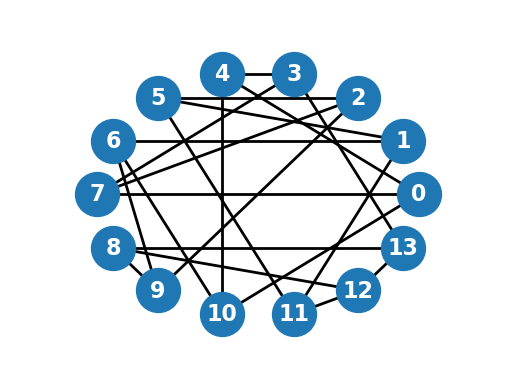

In [18]:
target_graph = nx.Graph()
target_graph.add_nodes_from(V)
target_graph.add_edges_from(E)

pos = nx.circular_layout(target_graph)
options = {
    "with_labels": True,
    "font_size": 16,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 1000,
    "width": 2
}
nx.draw_networkx(target_graph, pos, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [20]:
# Retrieve the expectation values obtained from 20*p rounds of AQA at a given level depth,
# as well as the average number of iterations consumed.
def AQA(p):
    """
    Runs the AQA optimization process for a given level depth p by performing multiple rounds
    of progressive learning (20*p rounds in total). This function collects the final expectation
    values, computes the average number of iterations consumed in each round, and measures the total classical
    simulation time. Additionally, it gathers quantum resource information such as the number of qubits,
    circuit depth, and gate counts.
    
    Process:
      1. Set convergence threshold (delta) and determine the number of progressive learning runs 
         (times) and random initializations per run (counts).
      2. Generate a list of random seed values for all runs.
      3. For each progressive learning run:
            a. Build the initial subgraph.
            b. Initialize the subgraph and record its initial loss (expectation value) after optimizing parameters,
               along with the number of iterations consumed.
            c. If the subgraph's parameters can be successfully transferred (i.e., the initial expectation value on the new subgraph
               is acceptable), perform further parameter optimization and update the current subgraph by adding new nodes.
            d. Stop the progressive learning process if either the parameter transfer fails or the improvement in the objective
               function becomes negligible, indicating that further optimization is unlikely to improve the result.
      4. Log and record quantum resource usage (qubits, circuit depth, gate counts) and the optimization statistics.
      5. Compute average metrics such as average loss, average iterations, and average quantum resources over all runs.
      6. Return the final expectation values at level depth p, the overall average iterations, total simulation time,
         and the average quantum resources consumed.
    
    Inputs:
        p: An integer specifying the QAOA ansatz depth (level depth).
    
    Outputs:
        Returns a tuple:
            - final_value: A list of the final expectation (loss) values for each progressive learning run.
            - avg: The average number of iterations consumed per AQA run.
            - delta_t: The total classical simulation time for the entire process.
            - avg_qubits: The average number of qubits used.
            - avg_depth: The average circuit depth.
            - avg_RX: The average number of RX gates used.
            - avg_RZ: The average number of RZ gates used.
            - avg_multi: The average number of multi-qubit controlled gates used.
    """
    
    delta = 0.1  # Convergence threshold for the change in loss.
    value = []  # List to store the final expectation values (final_value) for different runs.
    average_iterations = []  # List to store the average number of iterations consumed per progressive learning run.
    counts = 5  # Number of random initializations per progressive learning run.
    times = 10  # Number of progressive learning runs.

    # Generate a list of random seeds to be used for all runs.
    total_SEED = [] 
    for i in range(0, counts * times):
        total_SEED.append(random.randint(1, 25000))
    my_logger.info('p= {}, Random seeds total_SEED = {}'.format(p, total_SEED))

    start_time = time.time()  # Record the start time of the optimization process.
    start = 0  # Index marking the start of seeds for the first progressive learning run.
    
    for t in range(1, times + 1):
        # Build the initial subgraph.
        old_V, old_E = build_initial_graph(2)  # Create an initial subgraph of a given size.
        my_logger.info('initial_subgraph_V = {}, initial_subgraph_E = {}'.format(old_V, old_E))
    
        initial_n = len(old_V)  # Size of the initial subgraph.
        # Initialize the subgraph.
        sub_graph = nx.Graph()
        sub_graph.add_nodes_from(old_V)
        sub_graph.add_edges_from(old_E)
        
        # Record the expectation values for the current progressive learning run.
        sub_loss = []

        # Determine the list of seeds to be used for the current progressive learning run.
        SEED = []
        end = t * counts  # End index for the seed values of the current run.
        for seed in range(start, end):
            SEED.append(total_SEED[seed])
        start = end  # Update the seed index for the next run.
        my_logger.info('{}-th progressive learning run, SEED = {}'.format(t, SEED))

        # Loss_p will store the optimized expectation values obtained at a given circuit depth p.
        loss_p = []

        # Compute the number of times 'construct_graph' is called to evolve from the initial subgraph to the target graph.
        sub_num_nodes = sub_graph.number_of_nodes()       # Number of nodes in the current subgraph.
        target_num_nodes = target_graph.number_of_nodes()   # Total nodes in the target graph.
        consumed_iter = []  # List to store the iterations consumed during each optimization phase.

        # Find the optimal parameters for the initial subgraph.
        params_opt, max_loss, avg, avg_iterations = search_optimized_parameters(sub_graph, p, counts, SEED)
        loss_p.append(max_loss)
        consumed_iter.append(avg_iterations)

        # Initialize the old_graph with the current subgraph.
        old_graph = sub_graph
        # Pre-check: if the current subgraph is not the target graph, create a new graph.
        if len(old_graph.nodes()) != len(target_graph.nodes()):
            new_graph = construct_graph(old_graph, target_graph)

        for i in range(0, target_num_nodes - sub_num_nodes):
            # Evaluate whether the current parameters perform well on the new subgraph.
            ham = build_ham(new_graph)
            initial_expectation_value = calculate_initial_expectation_value(new_graph, p, params_opt[0][0], params_opt[0][1])
            my_logger.info('Transferring optimized parameters params_opt = {} from old_V = {} and old_E = {} to new subgraph (new_V = {}, new_E = {}), initial_expectation_value = {}'.format(
                params_opt, old_graph.nodes(), old_graph.edges(), new_graph.nodes(), new_graph.edges(), initial_expectation_value))

            # If the parameter transfer is not effective (i.e., the initial expectation value on the new subgraph
            # is less than half of the previous loss), abandon further parameter optimization.
            value0 = loss_p[len(loss_p) - 1]  # The last optimized expectation value.
            if initial_expectation_value < value0 / 2:
                my_logger.info('Parameter transfer effect is poor; abandoning further optimization for this progressive learning run.')
                my_logger.info('\n')
                break

            else:
                # If parameter transfer is successful, perform further parameter optimization.
                result, gamma_opt, beta_opt, loss, loss0, qubits0, circuit_depth, quantum_gates = execute_function(new_graph, p, params_opt[0][0], params_opt[0][1])
                loss_p.append(loss)
                consumed_iter.append(len(loss0))  # Record iterations consumed in this optimization.
                my_logger.info('new_V = {}, new_E = {}, loss after parameter transfer optimization = {}'.format(new_graph.nodes(), new_graph.edges(), loss))
                
                # Update optimized parameters.
                params_opt = []
                params_opt.append([beta_opt, gamma_opt])
                my_logger.info('Current loss_p = {}'.format(loss_p))
                my_logger.info('\n')

                # Check whether to continue adding nodes based on the change in expectation value.
                index = len(loss_p)
                a = loss_p[index - 1]
                b = loss_p[index - 2]
                if a <= b - 1:
                    my_logger.info('Post-optimization, the expectation value degraded significantly; terminating this progressive learning run.')
                    my_logger.info('\n')
                    break
                else:
                    index = len(loss_p)
                    if index >= 3:
                        delta1 = abs(loss_p[index - 1] - loss_p[index - 2])
                        delta2 = abs(loss_p[index - 2] - loss_p[index - 3])
                        if delta1 <= delta and delta2 <= delta and len(new_graph.nodes()) < len(target_graph.nodes()):
                            my_logger.info('Subgraph size increased, but the optimized expectation value remains nearly unchanged. Current subgraph size: {}'.format(len(new_graph.nodes())))
                            my_logger.info('Recommending the optimized parameters for the current subgraph (params_opt = {}) to the target graph.'.format(params_opt))
                            my_logger.info('Recommended parameters: params_opt = {}'.format(params_opt))
                            my_logger.info('\n')
                            break
                        else:
                            # Update old_graph for subsequent vertex additions.
                            old_graph = new_graph
                            if len(old_graph.nodes()) != len(target_graph.nodes()):
                                new_graph = construct_graph(old_graph, target_graph)
                            else:
                                my_logger.info('Current graph size equals target graph size; terminating this progressive learning run.')
                                my_logger.info('\n')
                                break
                    else:
                        old_graph = new_graph
                        if len(old_graph.nodes()) != len(target_graph.nodes()):
                            new_graph = construct_graph(old_graph, target_graph)
                        else:
                            my_logger.info('Current graph size equals target graph size; terminating this progressive learning run.')
                            my_logger.info('\n')
                            break

        my_logger.info('Progressive learning run {}: Expectation value history (sub_loss) = {}'.format(t, loss_p))
        my_logger.info('Progressive learning run {}: Iterations consumed = {}'.format(t, consumed_iter))
        # my_logger.info('Final optimized resource usage for this run: qubits = {}, circuit_depth = {}, quantum_gates = {}'.format(qubits0[0], circuit_depth[0], quantum_gates))
        
        # Record quantum resource usage.
        quantum_resources = []
        quantum_resources.append([qubits0[0], circuit_depth[0], quantum_gates])
        
        # Calculate the total number of iterations consumed in this progressive learning run.
        avg0 = 0
        for j0 in range(0, len(consumed_iter)):
            avg0 += consumed_iter[j0]
        average_iterations.append(avg0)
        value.append(loss_p)
        
        my_logger.info('\n')
        if len(value) % 5 == 0:
            my_logger.info('After {} progressive learning runs, the expectation values are: value = {}'.format(t, value))
    
    # End time and calculation of total simulation time.
    end_time = time.time()
    delta_t = end_time - start_time
    my_logger.info('start_time = {}'.format(start_time))
    my_logger.info('end_time = {}'.format(end_time))
    my_logger.info('delta_t = {}'.format(delta_t))
    
    my_logger.info('After {} progressive learning runs, the expectation values are: value = {}'.format(times, value))
    my_logger.info('\n')
    
    my_logger.info('After {} progressive learning runs, quantum resources used: quantum_resources = {}'.format(times, quantum_resources))
    
    # Compute the average quantum resource usage: qubits, RX_gates, RZ_gates, multi-qubit gates, and circuit depth.
    avg_qubits = 0
    avg_RX = 0
    avg_RZ = 0
    avg_multi = 0
    avg_depth = 0
    
    for i0 in range(0, len(quantum_resources)):
        avg_qubits += quantum_resources[i0][0]
        avg_depth += quantum_resources[i0][1]
        quantum_gates = quantum_resources[i0][2]
        avg_RX += quantum_gates[0][0]
        avg_RZ += quantum_gates[0][1]
        avg_multi += quantum_gates[0][2]
    avg_qubits = round(avg_qubits / len(quantum_resources), 5)
    avg_depth = round(avg_depth / len(quantum_resources), 5)
    avg_RX = round(avg_RX / len(quantum_resources), 5)
    avg_RZ = round(avg_RZ / len(quantum_resources), 5)
    avg_multi = round(avg_multi / len(quantum_resources), 5)
    my_logger.info('In {} rounds of AQA, average resources: avg_qubits = {}, avg_depth = {}, avg_RX = {}, avg_RZ = {}, avg_multi = {}'.format(
        times, avg_qubits, avg_depth, avg_RX, avg_RZ, avg_multi))
    
    # Get the final expectation values for each run at level depth p.
    final_value = []
    for i in range(0, len(value)):
        l = len(value[i])
        final_value.append(value[i][l - 1])
    my_logger.info('final_value = {}'.format(final_value))
    
    my_logger.info('In {} rounds of AQA, the average iterations per run: average_iterations = {}'.format(times, average_iterations))
    
    # Calculate the overall average number of iterations consumed across all runs.
    avg = 0
    for j0 in range(0, len(average_iterations)):
        avg += average_iterations[j0]
    avg = avg / len(average_iterations)
    avg = round(avg, 5)
    my_logger.info('avg_iterations consumed by {} runs of AQA is {}'.format(times, avg))
    
    # Return the final expectation values, average iterations, total simulation time,
    # and average quantum resource usage (qubits, circuit depth, RX, RZ, and multi-qubit gate counts).
    return final_value, avg, delta_t, avg_qubits, avg_depth, avg_RX, avg_RZ, avg_multi




Please input the maximum circuit depth:2
p= 1, Random seeds total_SEED = [363, 9443, 701, 13136, 8725, 19453, 10796, 8882, 15597, 9602, 2520, 1280, 1589, 7791, 8036, 12794, 9018, 6014, 23874, 18660, 18288, 17689, 15944, 9525, 15342, 16028, 4758, 3473, 7703, 4921, 10514, 5863, 20331, 7814, 22496, 11154, 6724, 20915, 11774, 8067, 12444, 8202, 2282, 17135, 14047, 19119, 1075, 1798, 18290, 15979]
new_E = [], new_V = [6, 11]


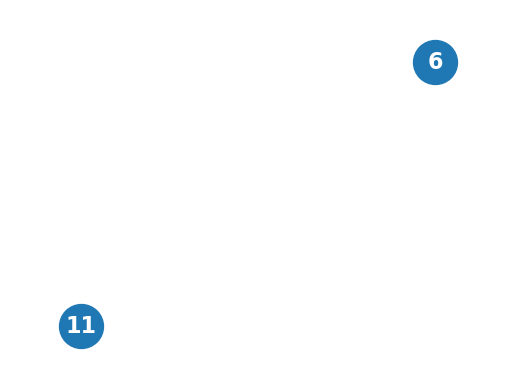

initial_subgraph_V = [6, 11], initial_subgraph_E = []
1-th progressive learning run, SEED = [363, 9443, 701, 13136, 8725]



The 1-th global random initialization
SEED = 363,initial_beta = [1.4371486],initial_gamma = [3.1241372]
[6, 11]
=============Circuit Summary=============
|Total number of gates  : 8.            |
|Parameter gates        : 4.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[6, 11]
1/2 [Z6] +
-1 [] +
1/2 [Z11] 
initial_ex = 0.8667497522350233
weight = [3.1241372 1.4371486]
Convergence reached after 42 iterations, with loss evolution: [-0.86674976, -0.9164497, -0.9663653, -1.016372, -1.0663422, -1.1161445, -1.1656442, -1.2147048, -1.2631875, -1.3109529, -1.3578616, -1.4037751, -1.4485571, -1.492075, -1.5342008, -1.5748132, -1.6137985, -1.651052, -1.6864802, -1.7200016, -1.7515482, -1.7810667, -1.8085197, -1.833886, -1.8571616, -1.8783599, -1.8975116, -1.9146639, -1.929880

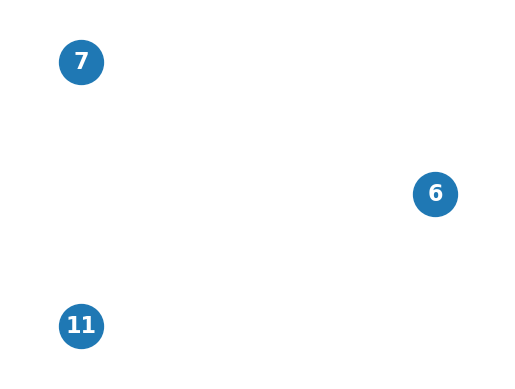

[6, 7, 11]
1/2 [Z6] +
-3/2 [] +
1/2 [Z7] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1594508], [3.1241372]]] from old_V = [6, 11] and old_E = [] to new subgraph (new_V = [6, 7, 11], new_E = []), initial_expectation_value = 2.999760822130626
[6, 7, 11]
=============Circuit Summary=============
|Total number of gates  : 11.           |
|Parameter gates        : 6.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[6, 7, 11]
1/2 [Z6] +
-3/2 [] +
1/2 [Z7] +
1/2 [Z11] 
initial_ex = 2.999760822130626
weight = [3.1241372 3.1594508]
Convergence reached after 3 iterations, with loss evolution: [-2.9997609, -2.9992254, -2.999811]
Optimized circuit parameters: params = [3.1241372, 3.1499207]
new_V = [6, 7, 11], new_E = [], loss after parameter transfer optimization = 2.999809980392456
Current loss_p = [2.0, 2.99981]


new_E = [], new_V = [4, 6, 7, 11]


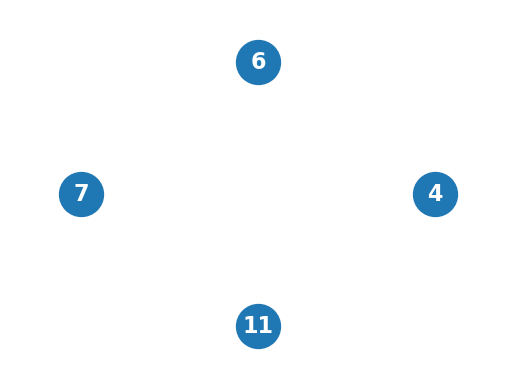

[4, 6, 7, 11]
1/2 [Z4] +
-2 [] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1499207], [3.1241372]]] from old_V = [6, 7, 11] and old_E = [] to new subgraph (new_V = [4, 6, 7, 11], new_E = []), initial_expectation_value = 3.9999306440108566
[4, 6, 7, 11]
=============Circuit Summary=============
|Total number of gates  : 14.           |
|Parameter gates        : 8.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[4, 6, 7, 11]
1/2 [Z4] +
-2 [] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z11] 
initial_ex = 3.9999306440108566
weight = [3.1241372 3.1499207]
Convergence reached after 5 iterations, with loss evolution: [-3.9999306, -3.9982638, -3.999862, -3.9996367, -3.9990587]
Optimized circuit parameters: params = [3.1241372, 3.1658502]
new_V = [4, 6, 7, 11], new_E = [], loss after parameter transfer optimization = 3.9990599155426025
Current loss_p = [2.0, 2.99981, 3.999

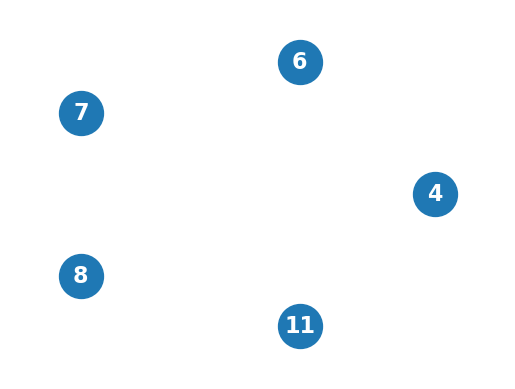

[4, 6, 7, 8, 11]
1/2 [Z4] +
-5/2 [] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1658502], [3.1241372]]] from old_V = [4, 6, 7, 11] and old_E = [] to new subgraph (new_V = [4, 6, 7, 8, 11], new_E = []), initial_expectation_value = 4.9992645026430536
[4, 6, 7, 8, 11]
=============Circuit Summary=============
|Total number of gates  : 17.           |
|Parameter gates        : 10.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[4, 6, 7, 8, 11]
1/2 [Z4] +
-5/2 [] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] 
initial_ex = 4.9992645026430536
weight = [3.1241372 3.1658502]
Convergence reached after 3 iterations, with loss evolution: [-4.9992647, -4.9991717, -4.9994154]
Optimized circuit parameters: params = [3.1241372, 3.1393487]
new_V = [4, 6, 7, 8, 11], new_E = [], loss after parameter transfer optimization = 4.999420166015625
Current loss_p = 

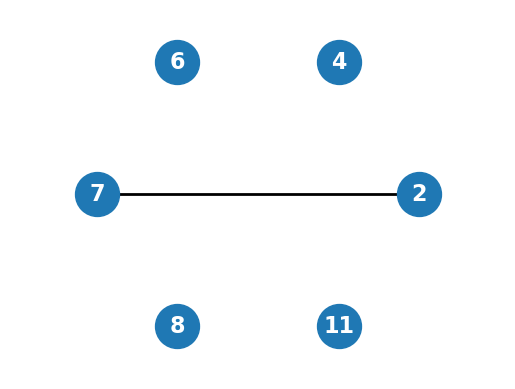

[2, 4, 6, 7, 8, 11]
1/2 [Z2] +
-3 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1393487], [3.1241372]]] from old_V = [4, 6, 7, 8, 11] and old_E = [] to new subgraph (new_V = [2, 4, 6, 7, 8, 11], new_E = [(2, 7)]), initial_expectation_value = 4.999994964876323
[2, 4, 6, 7, 8, 11]
=============Circuit Summary=============
|Total number of gates  : 24.           |
|Parameter gates        : 12.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[2, 4, 6, 7, 8, 11]
1/2 [Z2] +
-3 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] 
initial_ex = 4.999994964876323
weight = [3.1241372 3.1393487]
Convergence reached after 5 iterations, with loss evolution: [-4.9999948, -4.99772, -4.999852, -4.999499, -4.998695]
Optimized circuit parameters: params = [3.1241372, 3.110952]
new_V = [2, 4, 6, 7, 8, 11], new_E = [(2, 7)], loss after param

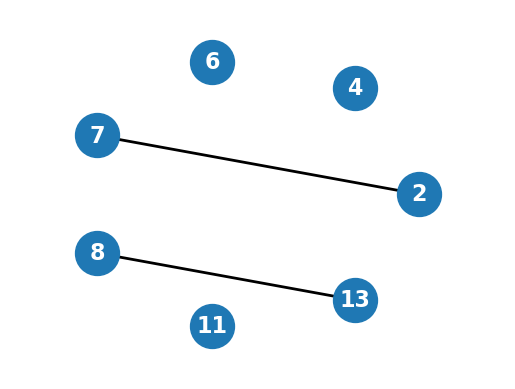

[2, 4, 6, 7, 8, 11, 13]
1/2 [Z2] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.110952], [3.1241372]]] from old_V = [2, 4, 6, 7, 8, 11] and old_E = [(2, 7)] to new subgraph (new_V = [2, 4, 6, 7, 8, 11, 13], new_E = [(2, 7), (8, 13)]), initial_expectation_value = 4.999295803111631
[2, 4, 6, 7, 8, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 31.           |
|Parameter gates        : 14.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[2, 4, 6, 7, 8, 11, 13]
1/2 [Z2] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.999295803111631
weight = [3.1241372 3.110952 ]
Convergence reached after 3 iterations, with loss evolution: [-4.9992957, -4.999719, -4.99942]
Optimized circuit parameters: params = [3.1241372, 3.1551187]
new_V = [2, 4, 6, 7, 8,

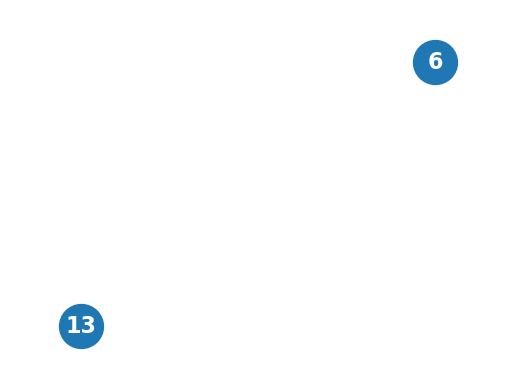

initial_subgraph_V = [6, 13], initial_subgraph_E = []
2-th progressive learning run, SEED = [19453, 10796, 8882, 15597, 9602]



The 1-th global random initialization
SEED = 19453,initial_beta = [1.9739848],initial_gamma = [1.7633859]
[6, 13]
=============Circuit Summary=============
|Total number of gates  : 8.            |
|Parameter gates        : 4.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[6, 13]
1/2 [Z6] +
-1 [] +
1/2 [Z13] 
initial_ex = 1.3923531706726417
weight = [1.7633859 1.9739848]
Convergence reached after 29 iterations, with loss evolution: [-1.3923532, -1.4378345, -1.4821923, -1.525294, -1.5670093, -1.6072116, -1.6457783, -1.6825948, -1.717554, -1.7505592, -1.7815261, -1.810384, -1.8370781, -1.8615713, -1.8838451, -1.9039016, -1.9217637, -1.9374762, -1.9511056, -1.9627391, -1.9724841, -1.9804657, -1.9868248, -1.9917148, -1.9952992, -1.997746, -1.9992259, -1.9999068, -1.9

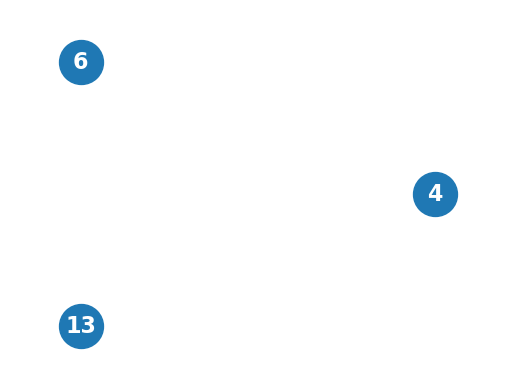

[4, 6, 13]
1/2 [Z4] +
-3/2 [] +
1/2 [Z6] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.16478], [0.31474516]]] from old_V = [6, 13] and old_E = [] to new subgraph (new_V = [4, 6, 13], new_E = []), initial_expectation_value = 2.9995967817168987
[4, 6, 13]
=============Circuit Summary=============
|Total number of gates  : 11.           |
|Parameter gates        : 6.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[4, 6, 13]
1/2 [Z4] +
-3/2 [] +
1/2 [Z6] +
1/2 [Z13] 
initial_ex = 2.9995967817168987
weight = [0.31474516 3.16478   ]
Convergence reached after 3 iterations, with loss evolution: [-2.9995968, -2.999461, -2.9996827]
Optimized circuit parameters: params = [0.31474516, 3.141232]
new_V = [4, 6, 13], new_E = [], loss after parameter transfer optimization = 2.9996800422668457
Current loss_p = [2.0, 2.99968]


new_E = [], new_V = [2, 4, 6, 13]


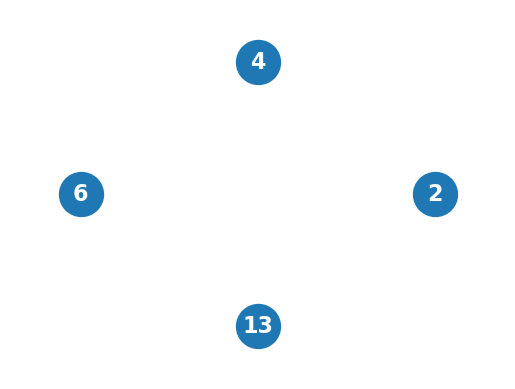

[2, 4, 6, 13]
1/2 [Z2] +
-2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.141232], [0.31474516]]] from old_V = [4, 6, 13] and old_E = [] to new subgraph (new_V = [2, 4, 6, 13], new_E = []), initial_expectation_value = 3.9999998699388732
[2, 4, 6, 13]
=============Circuit Summary=============
|Total number of gates  : 14.           |
|Parameter gates        : 8.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[2, 4, 6, 13]
1/2 [Z2] +
-2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z13] 
initial_ex = 3.9999998699388732
weight = [0.31474516 3.141232  ]
Convergence reached after 5 iterations, with loss evolution: [-3.9999998, -3.9975386, -3.9998398, -3.9994743, -3.9985833]
Optimized circuit parameters: params = [0.31474516, 3.1088414]
new_V = [2, 4, 6, 13], new_E = [], loss after parameter transfer optimization = 3.998579978942871
Current loss_p = [2.0, 2.99968, 3.

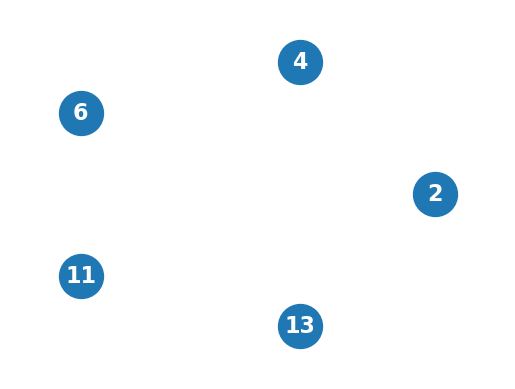

[2, 4, 6, 11, 13]
1/2 [Z2] +
-5/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1088414], [0.31474516]]] from old_V = [2, 4, 6, 13] and old_E = [] to new subgraph (new_V = [2, 4, 6, 11, 13], new_E = []), initial_expectation_value = 4.998659315655174
[2, 4, 6, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 17.           |
|Parameter gates        : 10.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[2, 4, 6, 11, 13]
1/2 [Z2] +
-5/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.998659315655174
weight = [0.31474516 3.1088414 ]
Convergence reached after 3 iterations, with loss evolution: [-4.998659, -4.999628, -4.998909]
Optimized circuit parameters: params = [0.31474516, 3.158624]
new_V = [2, 4, 6, 11, 13], new_E = [], loss after parameter transfer optimization = 4.998909950256348
Current loss

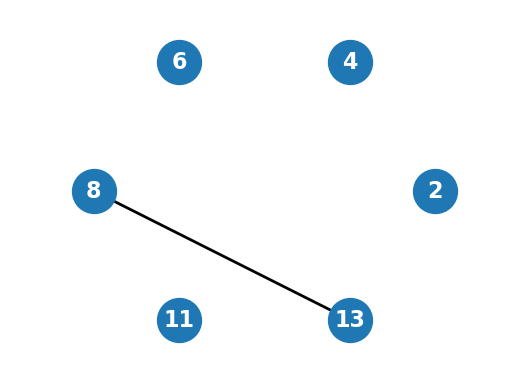

[2, 4, 6, 8, 11, 13]
1/2 [Z2] +
-3 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.158624], [0.31474516]]] from old_V = [2, 4, 6, 11, 13] and old_E = [] to new subgraph (new_V = [2, 4, 6, 8, 11, 13], new_E = [(8, 13)]), initial_expectation_value = 4.999709937247718
[2, 4, 6, 8, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 24.           |
|Parameter gates        : 12.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[2, 4, 6, 8, 11, 13]
1/2 [Z2] +
-3 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.999709937247718
weight = [0.31474516 3.158624  ]
Convergence reached after 3 iterations, with loss evolution: [-4.99971, -4.9989133, -4.9997663]
Optimized circuit parameters: params = [0.31474516, 3.1511228]
new_V = [2, 4, 6, 8, 11, 13], new_E = [(8, 13)], loss after parameter tr

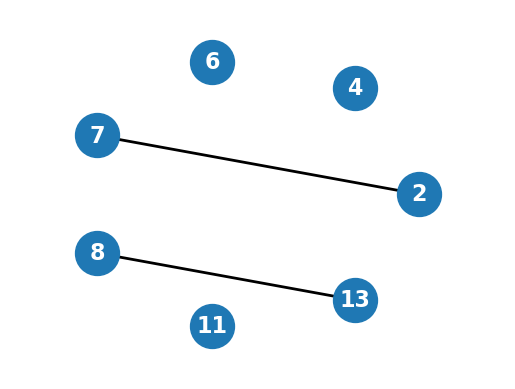

[2, 4, 6, 7, 8, 11, 13]
1/2 [Z2] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1511228], [0.31474516]]] from old_V = [2, 4, 6, 8, 11, 13] and old_E = [(8, 13)] to new subgraph (new_V = [2, 4, 6, 7, 8, 11, 13], new_E = [(2, 7), (8, 13)]), initial_expectation_value = 4.9999318815956135
[2, 4, 6, 7, 8, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 31.           |
|Parameter gates        : 14.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[2, 4, 6, 7, 8, 11, 13]
1/2 [Z2] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.999931881595613
weight = [0.31474516 3.1511228 ]
Convergence reached after 5 iterations, with loss evolution: [-4.999932, -4.9987717, -4.999893, -4.9997544, -4.999345]
Optimized circuit parameters: params = [0.31474516, 3.

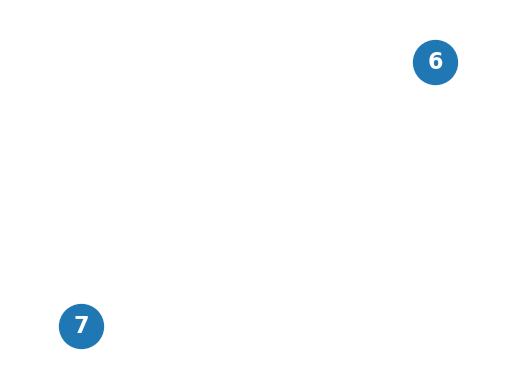

initial_subgraph_V = [6, 7], initial_subgraph_E = []
3-th progressive learning run, SEED = [2520, 1280, 1589, 7791, 8036]



The 1-th global random initialization
SEED = 2520,initial_beta = [2.9555058],initial_gamma = [1.1457384]
[6, 7]
=============Circuit Summary=============
|Total number of gates  : 8.            |
|Parameter gates        : 4.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 8             |
None
[6, 7]
1/2 [Z6] +
-1 [] +
1/2 [Z7] 
initial_ex = 1.9827357560401961
weight = [1.1457384 2.9555058]
Convergence reached after 6 iterations, with loss evolution: [-1.9827358, -1.9907545, -1.9962122, -1.9991878, -1.9999976, -1.9992824]
Optimized circuit parameters: params = [1.1457384, 3.205946]



The 2-th global random initialization
SEED = 1280,initial_beta = [1.2272316],initial_gamma = [2.6565979]
[6, 7]
=============Circuit Summary=============
|Total number of gates  : 8.            |
|Parameter ga

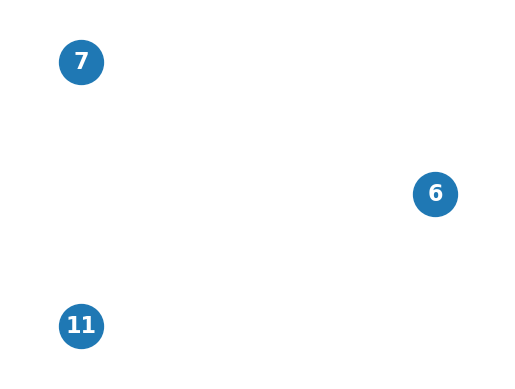

[6, 7, 11]
1/2 [Z6] +
-3/2 [] +
1/2 [Z7] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1694174], [2.4150782]]] from old_V = [6, 7] and old_E = [] to new subgraph (new_V = [6, 7, 11], new_E = []), initial_expectation_value = 2.99941937585858
[6, 7, 11]
=============Circuit Summary=============
|Total number of gates  : 11.           |
|Parameter gates        : 6.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[6, 7, 11]
1/2 [Z6] +
-3/2 [] +
1/2 [Z7] +
1/2 [Z11] 
initial_ex = 2.99941937585858
weight = [2.4150782 3.1694174]
Convergence reached after 3 iterations, with loss evolution: [-2.9994195, -2.9996312, -2.9995248]
Optimized circuit parameters: params = [2.4150782, 3.1329858]
new_V = [6, 7, 11], new_E = [], loss after parameter transfer optimization = 2.9995200634002686
Current loss_p = [1.99997, 2.99952]


new_E = [], new_V = [6, 7, 11, 13]


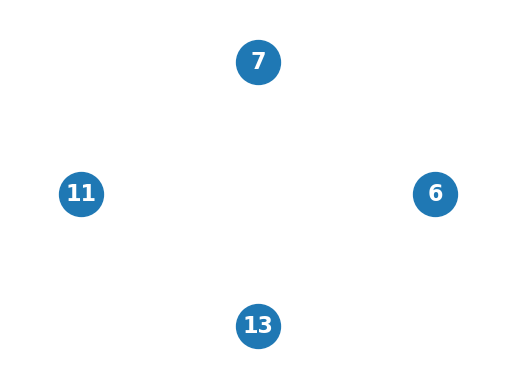

[6, 7, 11, 13]
1/2 [Z6] +
-2 [] +
1/2 [Z7] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1329858], [2.4150782]]] from old_V = [6, 7, 11] and old_E = [] to new subgraph (new_V = [6, 7, 11, 13], new_E = []), initial_expectation_value = 3.999925923050265
[6, 7, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 14.           |
|Parameter gates        : 8.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[6, 7, 11, 13]
1/2 [Z6] +
-2 [] +
1/2 [Z7] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 3.999925923050265
weight = [2.4150782 3.1329858]
Convergence reached after 5 iterations, with loss evolution: [-3.9999259, -3.998287, -3.9998612, -3.999645, -3.9990747]
Optimized circuit parameters: params = [2.4150782, 3.1175919]
new_V = [6, 7, 11, 13], new_E = [], loss after parameter transfer optimization = 3.999069929122925
Current loss_p = [1.99997, 2.99952

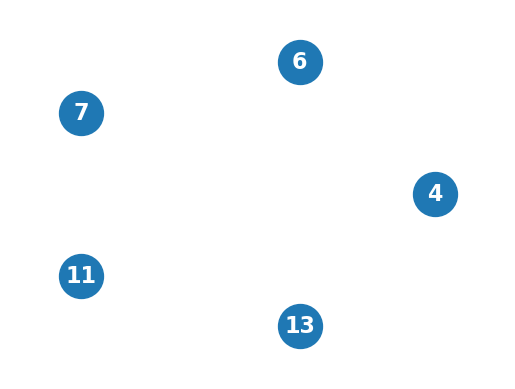

[4, 6, 7, 11, 13]
1/2 [Z4] +
-5/2 [] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1175919], [2.4150782]]] from old_V = [6, 7, 11, 13] and old_E = [] to new subgraph (new_V = [4, 6, 7, 11, 13], new_E = []), initial_expectation_value = 4.999279986822351
[4, 6, 7, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 17.           |
|Parameter gates        : 10.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[4, 6, 7, 11, 13]
1/2 [Z4] +
-5/2 [] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.999279986822351
weight = [2.4150782 3.1175919]
Convergence reached after 3 iterations, with loss evolution: [-4.99928, -4.999155, -4.999429]
Optimized circuit parameters: params = [2.4150782, 3.1433823]
new_V = [4, 6, 7, 11, 13], new_E = [], loss after parameter transfer optimization = 4.999430179595947
Current loss_p 

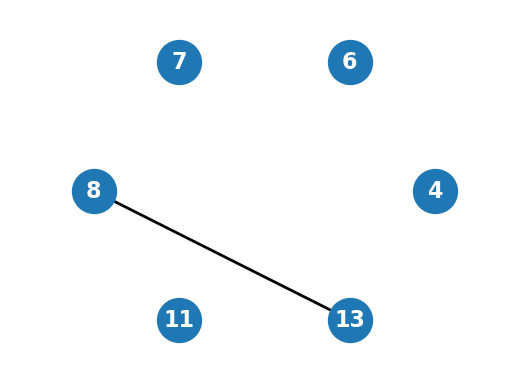

[4, 6, 7, 8, 11, 13]
1/2 [Z4] +
-3 [] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1433823], [2.4150782]]] from old_V = [4, 6, 7, 11, 13] and old_E = [] to new subgraph (new_V = [4, 6, 7, 8, 11, 13], new_E = [(8, 13)]), initial_expectation_value = 4.999996797127042
[4, 6, 7, 8, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 24.           |
|Parameter gates        : 12.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[4, 6, 7, 8, 11, 13]
1/2 [Z4] +
-3 [] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.999996797127042
weight = [2.4150782 3.1433823]
Convergence reached after 5 iterations, with loss evolution: [-4.9999967, -4.9976764, -4.9998493, -4.999492, -4.9986677]
Optimized circuit parameters: params = [2.4150782, 3.172745]
new_V = [4, 6, 7, 8, 11, 13], new_E = [(8, 13)], lo

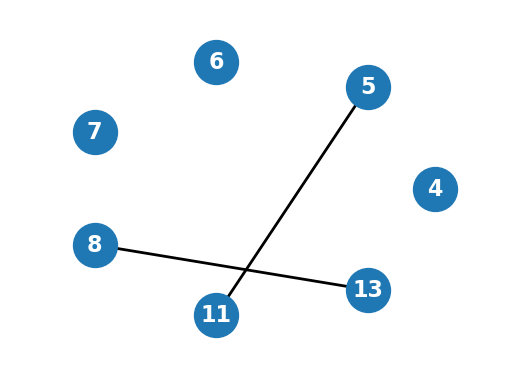

[4, 5, 6, 7, 8, 11, 13]
1/2 [Z4] +
-7/2 [] +
1/2 [Z5] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.172745], [2.4150782]]] from old_V = [4, 6, 7, 8, 11, 13] and old_E = [(8, 13)] to new subgraph (new_V = [4, 5, 6, 7, 8, 11, 13], new_E = [(5, 11), (8, 13)]), initial_expectation_value = 4.999272090134523
[4, 5, 6, 7, 8, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 31.           |
|Parameter gates        : 14.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[4, 5, 6, 7, 8, 11, 13]
1/2 [Z4] +
-7/2 [] +
1/2 [Z5] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.999272090134523
weight = [2.4150782 3.172745 ]
Convergence reached after 3 iterations, with loss evolution: [-4.999272, -4.9997334, -4.9994016]
Optimized circuit parameters: params = [2.4150782, 3.1271992]
new_V = [4, 5, 6, 

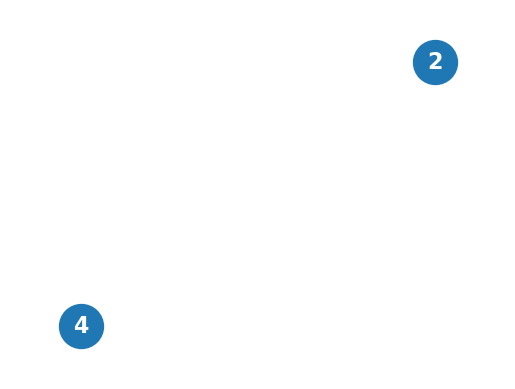

initial_subgraph_V = [2, 4], initial_subgraph_E = []
4-th progressive learning run, SEED = [12794, 9018, 6014, 23874, 18660]



The 1-th global random initialization
SEED = 12794,initial_beta = [1.8453794],initial_gamma = [1.4113545]
[2, 4]
=============Circuit Summary=============
|Total number of gates  : 8.            |
|Parameter gates        : 4.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 5             |
None
[2, 4]
1/2 [Z2] +
-1 [] +
1/2 [Z4] 
initial_ex = 1.2711456068599418
weight = [1.4113545 1.8453794]
Convergence reached after 32 iterations, with loss evolution: [-1.2711456, -1.3189136, -1.3658643, -1.4118631, -1.4567765, -1.5004718, -1.5428188, -1.5836916, -1.6229696, -1.6605386, -1.6962935, -1.7301393, -1.7619927, -1.7917844, -1.8194599, -1.8449814, -1.8683294, -1.8895028, -1.9085202, -1.9254206, -1.9402622, -1.9531225, -1.964097, -1.9732982, -1.9808522, -1.9868977, -1.9915823, -1.9950594, -1.99

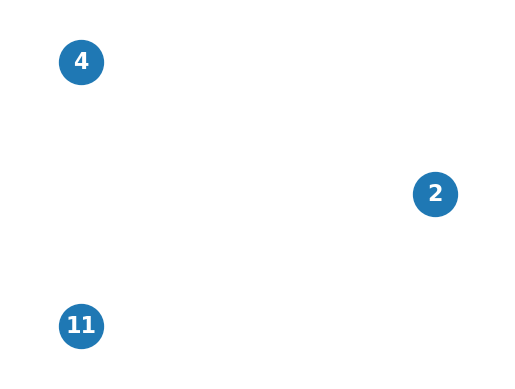

[2, 4, 11]
1/2 [Z2] +
-3/2 [] +
1/2 [Z4] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1649442], [1.4113545]], [[3.1621943], [2.3814223]]] from old_V = [2, 4] and old_E = [] to new subgraph (new_V = [2, 4, 11], new_E = []), initial_expectation_value = 2.999591048527979
[2, 4, 11]
=============Circuit Summary=============
|Total number of gates  : 11.           |
|Parameter gates        : 6.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[2, 4, 11]
1/2 [Z2] +
-3/2 [] +
1/2 [Z4] +
1/2 [Z11] 
initial_ex = 2.999591048527979
weight = [1.4113545 3.1649442]
Convergence reached after 3 iterations, with loss evolution: [-2.999591, -2.9994674, -2.9996777]
Optimized circuit parameters: params = [1.4113545, 3.1409447]
new_V = [2, 4, 11], new_E = [], loss after parameter transfer optimization = 2.9996800422668457
Current loss_p = [2.0, 2.99968]


new_E = [], new_V = [2, 4, 6, 11]


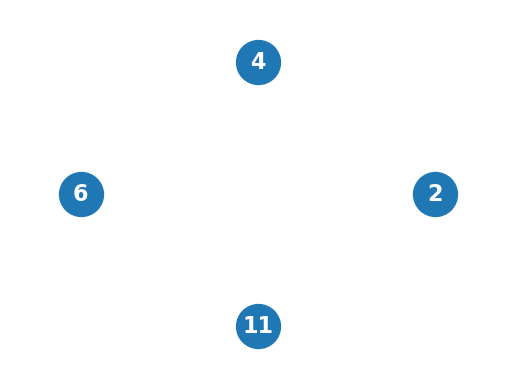

[2, 4, 6, 11]
1/2 [Z2] +
-2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1409447], [1.4113545]]] from old_V = [2, 4, 11] and old_E = [] to new subgraph (new_V = [2, 4, 6, 11], new_E = []), initial_expectation_value = 3.999999580181187
[2, 4, 6, 11]
=============Circuit Summary=============
|Total number of gates  : 14.           |
|Parameter gates        : 8.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[2, 4, 6, 11]
1/2 [Z2] +
-2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z11] 
initial_ex = 3.999999580181187
weight = [1.4113545 3.1409447]
Convergence reached after 5 iterations, with loss evolution: [-3.9999995, -3.997566, -3.999842, -3.9994776, -3.9986]
Optimized circuit parameters: params = [1.4113545, 3.1091576]
new_V = [2, 4, 6, 11], new_E = [], loss after parameter transfer optimization = 3.9986000061035156
Current loss_p = [2.0, 2.99968, 3.9986]


n

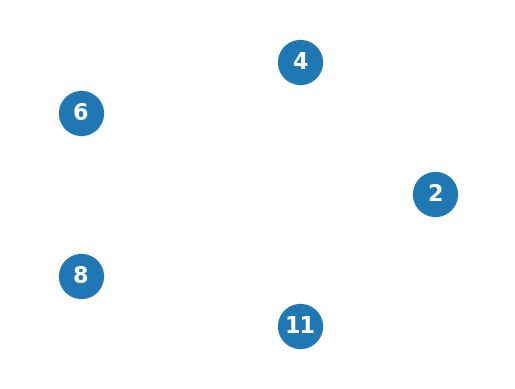

[2, 4, 6, 8, 11]
1/2 [Z2] +
-5/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z8] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1091576], [1.4113545]]] from old_V = [2, 4, 6, 11] and old_E = [] to new subgraph (new_V = [2, 4, 6, 8, 11], new_E = []), initial_expectation_value = 4.998685071348024
[2, 4, 6, 8, 11]
=============Circuit Summary=============
|Total number of gates  : 17.           |
|Parameter gates        : 10.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[2, 4, 6, 8, 11]
1/2 [Z2] +
-5/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z8] +
1/2 [Z11] 
initial_ex = 4.998685071348024
weight = [1.4113545 3.1091576]
Convergence reached after 3 iterations, with loss evolution: [-4.998685, -4.9996142, -4.998927]
Optimized circuit parameters: params = [1.4113545, 3.1581101]
new_V = [2, 4, 6, 8, 11], new_E = [], loss after parameter transfer optimization = 4.998929977416992
Current loss_p = [2.0

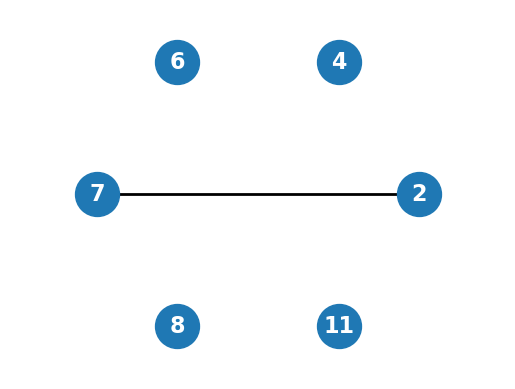

[2, 4, 6, 7, 8, 11]
1/2 [Z2] +
-3 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1581101], [1.4113545]]] from old_V = [2, 4, 6, 8, 11] and old_E = [] to new subgraph (new_V = [2, 4, 6, 7, 8, 11], new_E = [(2, 7)]), initial_expectation_value = 4.999727174135616
[2, 4, 6, 7, 8, 11]
=============Circuit Summary=============
|Total number of gates  : 24.           |
|Parameter gates        : 12.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[2, 4, 6, 7, 8, 11]
1/2 [Z2] +
-3 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] 
initial_ex = 4.999727174135616
weight = [1.4113545 3.1581101]
Convergence reached after 3 iterations, with loss evolution: [-4.9997272, -4.998879, -4.9997773]
Optimized circuit parameters: params = [1.4113545, 3.151845]
new_V = [2, 4, 6, 7, 8, 11], new_E = [(2, 7)], loss after parameter transfer optimi

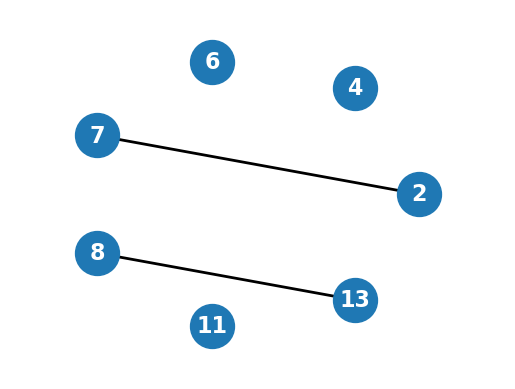

[2, 4, 6, 7, 8, 11, 13]
1/2 [Z2] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.151845], [1.4113545]]] from old_V = [2, 4, 6, 7, 8, 11] and old_E = [(2, 7)] to new subgraph (new_V = [2, 4, 6, 7, 8, 11, 13], new_E = [(2, 7), (8, 13)]), initial_expectation_value = 4.9999211666875345
[2, 4, 6, 7, 8, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 31.           |
|Parameter gates        : 14.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[2, 4, 6, 7, 8, 11, 13]
1/2 [Z2] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.9999211666875345
weight = [1.4113545 3.151845 ]
Convergence reached after 5 iterations, with loss evolution: [-4.9999213, -4.998815, -4.9998903, -4.9997716, -4.999375]
Optimized circuit parameters: params = [1.4113545, 3.16417

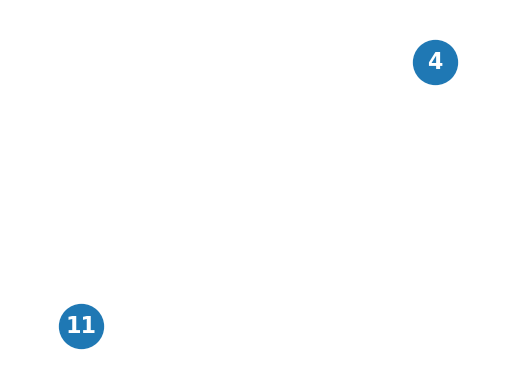

initial_subgraph_V = [4, 11], initial_subgraph_E = []
5-th progressive learning run, SEED = [18288, 17689, 15944, 9525, 15342]



The 1-th global random initialization
SEED = 18288,initial_beta = [2.2886999],initial_gamma = [0.1332482]
[4, 11]
=============Circuit Summary=============
|Total number of gates  : 8.            |
|Parameter gates        : 4.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[4, 11]
1/2 [Z4] +
-1 [] +
1/2 [Z11] 
initial_ex = 1.6578070923472603
weight = [0.1332482 2.2886999]
Convergence reached after 21 iterations, with loss evolution: [-1.6578071, -1.6946286, -1.7296638, -1.7627944, -1.7939106, -1.8229138, -1.8497188, -1.8742576, -1.8964808, -1.9163616, -1.9338979, -1.9491148, -1.9620662, -1.972836, -1.981538, -1.9883152, -1.9933368, -1.9967946, -1.9988981, -1.999868, -1.9999293]
Optimized circuit parameters: params = [0.1332482, 3.1789227]



The 2-th global rando

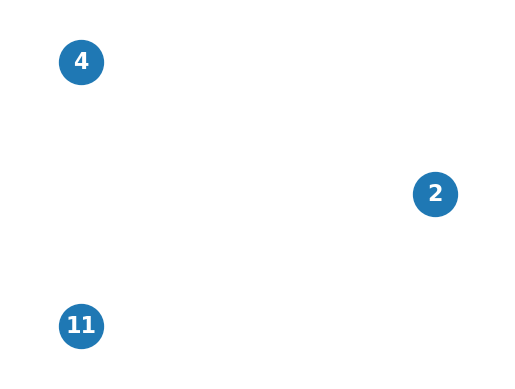

[2, 4, 11]
1/2 [Z2] +
-3/2 [] +
1/2 [Z4] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1789227], [0.1332482]]] from old_V = [4, 11] and old_E = [] to new subgraph (new_V = [2, 4, 11], new_E = []), initial_expectation_value = 2.998954974711458
[2, 4, 11]
=============Circuit Summary=============
|Total number of gates  : 11.           |
|Parameter gates        : 6.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[2, 4, 11]
1/2 [Z2] +
-3/2 [] +
1/2 [Z4] +
1/2 [Z11] 
initial_ex = 2.998954974711458
weight = [0.1332482 3.1789227]
Convergence reached after 3 iterations, with loss evolution: [-2.998955, -2.9998796, -2.9992113]
Optimized circuit parameters: params = [0.1332482, 3.117678]
new_V = [2, 4, 11], new_E = [], loss after parameter transfer optimization = 2.9992098808288574
Current loss_p = [1.99993, 2.99921]


new_E = [], new_V = [2, 4, 6, 11]


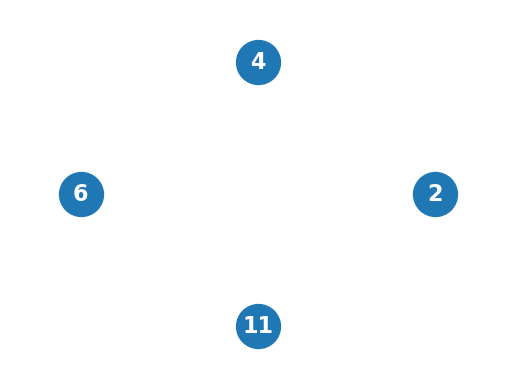

[2, 4, 6, 11]
1/2 [Z2] +
-2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.117678], [0.1332482]]] from old_V = [2, 4, 11] and old_E = [] to new subgraph (new_V = [2, 4, 6, 11], new_E = []), initial_expectation_value = 3.9994281131095883
[2, 4, 6, 11]
=============Circuit Summary=============
|Total number of gates  : 14.           |
|Parameter gates        : 8.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[2, 4, 6, 11]
1/2 [Z2] +
-2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z11] 
initial_ex = 3.9994281131095883
weight = [0.1332482 3.117678 ]
Convergence reached after 3 iterations, with loss evolution: [-3.999428, -3.9993196, -3.9995468]
Optimized circuit parameters: params = [0.1332482, 3.1432304]
new_V = [2, 4, 6, 11], new_E = [], loss after parameter transfer optimization = 3.9995501041412354
Current loss_p = [1.99993, 2.99921, 3.99955]


new_E = [], new

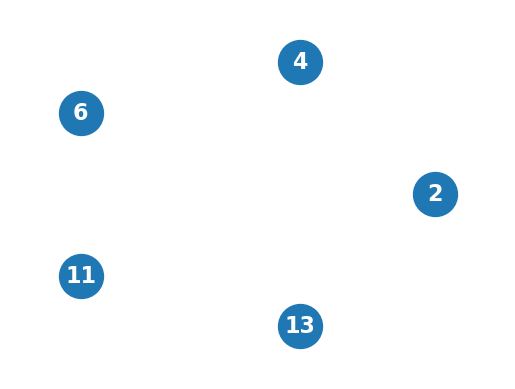

[2, 4, 6, 11, 13]
1/2 [Z2] +
-5/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1432304], [0.1332482]]] from old_V = [2, 4, 6, 11] and old_E = [] to new subgraph (new_V = [2, 4, 6, 11, 13], new_E = []), initial_expectation_value = 4.999996647077576
[2, 4, 6, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 17.           |
|Parameter gates        : 10.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[2, 4, 6, 11, 13]
1/2 [Z2] +
-5/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.999996647077576
weight = [0.1332482 3.1432304]
Convergence reached after 7 iterations, with loss evolution: [-4.9999967, -4.9970775, -4.9998107, -4.999363, -4.9983234, -4.998774, -4.999681]
Optimized circuit parameters: params = [0.1332482, 3.1390505]
new_V = [2, 4, 6, 11, 13], new_E = [], loss after parameter transfer 

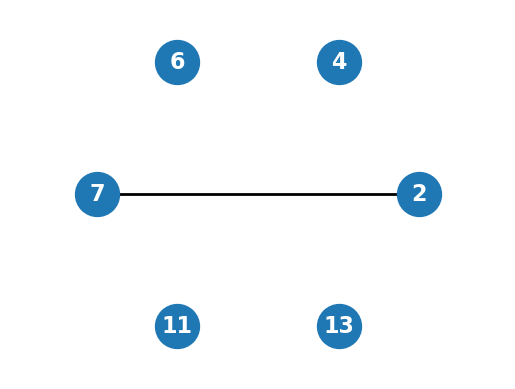

[2, 4, 6, 7, 11, 13]
1/2 [Z2] +
-3 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1390505], [0.1332482]]] from old_V = [2, 4, 6, 11, 13] and old_E = [] to new subgraph (new_V = [2, 4, 6, 7, 11, 13], new_E = [(2, 7)]), initial_expectation_value = 4.999993537373139
[2, 4, 6, 7, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 24.           |
|Parameter gates        : 12.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[2, 4, 6, 7, 11, 13]
1/2 [Z2] +
-3 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.999993537373139
weight = [0.1332482 3.1390505]
Convergence reached after 5 iterations, with loss evolution: [-4.9999933, -4.9977484, -4.9998536, -4.9995036, -4.998713]
Optimized circuit parameters: params = [0.1332482, 3.1112864]
new_V = [2, 4, 6, 7, 11, 13], new_E = [(2, 7)], los

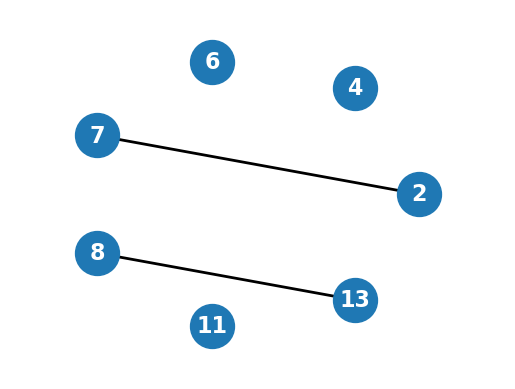

[2, 4, 6, 7, 8, 11, 13]
1/2 [Z2] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1112864], [0.1332482]]] from old_V = [2, 4, 6, 7, 11, 13] and old_E = [(2, 7)] to new subgraph (new_V = [2, 4, 6, 7, 8, 11, 13], new_E = [(2, 7), (8, 13)]), initial_expectation_value = 4.999311095614963
[2, 4, 6, 7, 8, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 31.           |
|Parameter gates        : 14.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[2, 4, 6, 7, 8, 11, 13]
1/2 [Z2] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.999311095614963
weight = [0.1332482 3.1112864]
Convergence reached after 3 iterations, with loss evolution: [-4.999311, -4.999709, -4.9994326]
Optimized circuit parameters: params = [0.1332482, 3.1545465]
new_V = [2, 4, 6, 7,

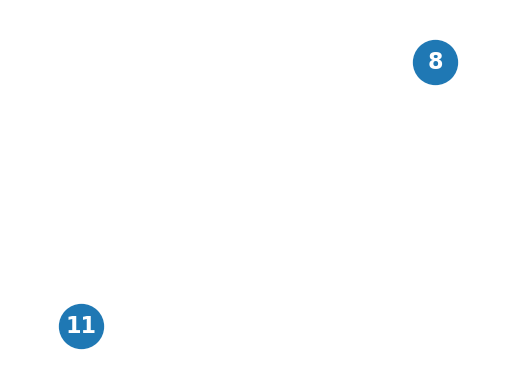

initial_subgraph_V = [8, 11], initial_subgraph_E = []
6-th progressive learning run, SEED = [16028, 4758, 3473, 7703, 4921]



The 1-th global random initialization
SEED = 16028,initial_beta = [2.1450088],initial_gamma = [2.4147558]
[8, 11]
=============Circuit Summary=============
|Total number of gates  : 8.            |
|Parameter gates        : 4.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[8, 11]
1/2 [Z8] +
-1 [] +
1/2 [Z11] 
initial_ex = 1.5431737377117827
weight = [2.4147558 2.1450088]
Convergence reached after 25 iterations, with loss evolution: [-1.5431738, -1.5844584, -1.6242416, -1.6623967, -1.6988024, -1.733344, -1.7659163, -1.7964255, -1.8247911, -1.8509481, -1.8748498, -1.8964696, -1.9158026, -1.932868, -1.9477093, -1.9603953, -1.9710201, -1.9797019, -1.9865808, -1.9918168, -1.9955854, -1.998074, -1.9994764, -1.9999877, -1.999799]
Optimized circuit parameters: params = [2.

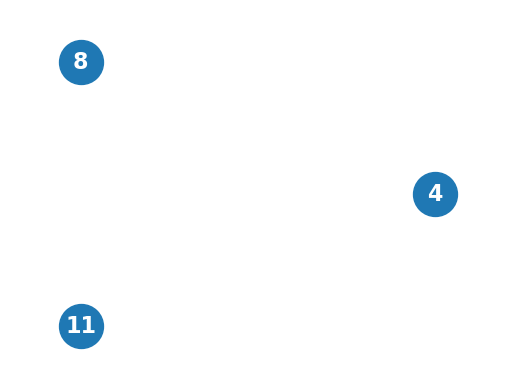

[4, 8, 11]
1/2 [Z4] +
-3/2 [] +
1/2 [Z8] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1618052], [2.5566955]]] from old_V = [8, 11] and old_E = [] to new subgraph (new_V = [4, 8, 11], new_E = []), initial_expectation_value = 2.999693601585614
[4, 8, 11]
=============Circuit Summary=============
|Total number of gates  : 11.           |
|Parameter gates        : 6.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[4, 8, 11]
1/2 [Z4] +
-3/2 [] +
1/2 [Z8] +
1/2 [Z11] 
initial_ex = 2.999693601585614
weight = [2.5566955 3.1618052]
Convergence reached after 3 iterations, with loss evolution: [-2.9996936, -2.9993346, -2.9997623]
Optimized circuit parameters: params = [2.5566955, 3.1462615]
new_V = [4, 8, 11], new_E = [], loss after parameter transfer optimization = 2.9997599124908447
Current loss_p = [2.0, 2.99976]


new_E = [], new_V = [4, 6, 8, 11]


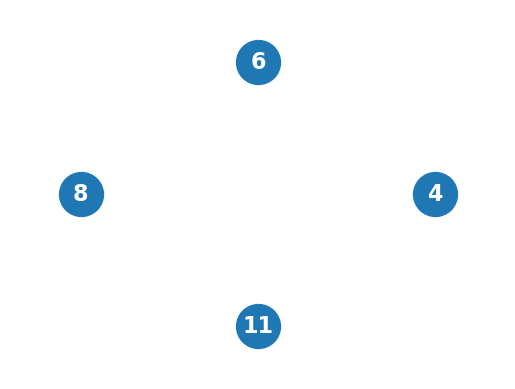

[4, 6, 8, 11]
1/2 [Z4] +
-2 [] +
1/2 [Z6] +
1/2 [Z8] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1462615], [2.5566955]]] from old_V = [4, 8, 11] and old_E = [] to new subgraph (new_V = [4, 6, 8, 11], new_E = []), initial_expectation_value = 3.9999782023457917
[4, 6, 8, 11]
=============Circuit Summary=============
|Total number of gates  : 14.           |
|Parameter gates        : 8.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[4, 6, 8, 11]
1/2 [Z4] +
-2 [] +
1/2 [Z6] +
1/2 [Z8] +
1/2 [Z11] 
initial_ex = 3.9999782023457917
weight = [2.5566955 3.1462615]
Convergence reached after 5 iterations, with loss evolution: [-3.9999783, -3.9979455, -3.999862, -3.9995437, -3.9988418]
Optimized circuit parameters: params = [2.5566955, 3.1695533]
new_V = [4, 6, 8, 11], new_E = [], loss after parameter transfer optimization = 3.998840093612671
Current loss_p = [2.0, 2.99976, 3.9988

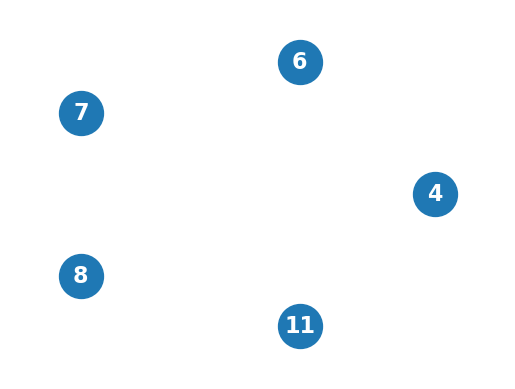

[4, 6, 7, 8, 11]
1/2 [Z4] +
-5/2 [] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1695533], [2.5566955]]] from old_V = [4, 6, 8, 11] and old_E = [] to new subgraph (new_V = [4, 6, 7, 8, 11], new_E = []), initial_expectation_value = 4.999022817887681
[4, 6, 7, 8, 11]
=============Circuit Summary=============
|Total number of gates  : 17.           |
|Parameter gates        : 10.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[4, 6, 7, 8, 11]
1/2 [Z4] +
-5/2 [] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] 
initial_ex = 4.999022817887681
weight = [2.5566955 3.1695533]
Convergence reached after 3 iterations, with loss evolution: [-4.999023, -4.999393, -4.9991994]
Optimized circuit parameters: params = [2.5566955, 3.1327446]
new_V = [4, 6, 7, 8, 11], new_E = [], loss after parameter transfer optimization = 4.999199867248535
Current loss_p = [2.0

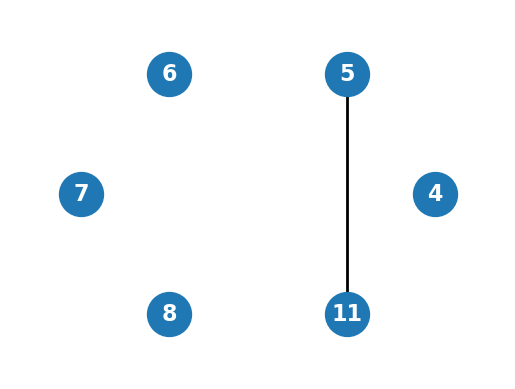

[4, 5, 6, 7, 8, 11]
1/2 [Z4] +
-3 [] +
1/2 [Z5] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1327446], [2.5566955]]] from old_V = [4, 6, 7, 8, 11] and old_E = [] to new subgraph (new_V = [4, 5, 6, 7, 8, 11], new_E = [(5, 11)]), initial_expectation_value = 4.999921711203033
[4, 5, 6, 7, 8, 11]
=============Circuit Summary=============
|Total number of gates  : 24.           |
|Parameter gates        : 12.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[4, 5, 6, 7, 8, 11]
1/2 [Z4] +
-3 [] +
1/2 [Z5] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] 
initial_ex = 4.999921711203033
weight = [2.5566955 3.1327446]
Convergence reached after 5 iterations, with loss evolution: [-4.999922, -4.9983068, -4.9998603, -4.999652, -4.9990883]
Optimized circuit parameters: params = [2.5566955, 3.1178088]
new_V = [4, 5, 6, 7, 8, 11], new_E = [(5, 11)], loss after

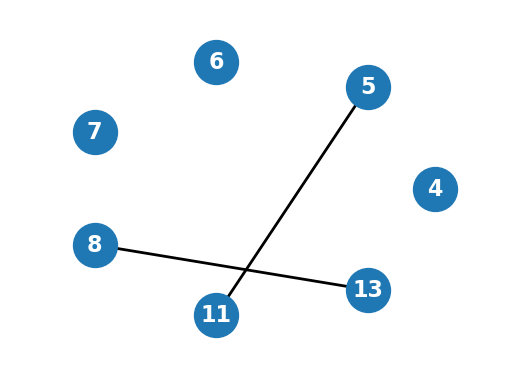

[4, 5, 6, 7, 8, 11, 13]
1/2 [Z4] +
-7/2 [] +
1/2 [Z5] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1178088], [2.5566955]]] from old_V = [4, 5, 6, 7, 8, 11] and old_E = [(5, 11)] to new subgraph (new_V = [4, 5, 6, 7, 8, 11, 13], new_E = [(5, 11), (8, 13)]), initial_expectation_value = 4.999575726907057
[4, 5, 6, 7, 8, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 31.           |
|Parameter gates        : 14.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[4, 5, 6, 7, 8, 11, 13]
1/2 [Z4] +
-7/2 [] +
1/2 [Z5] +
1/2 [Z6] +
1/2 [Z7] +
1/2 [Z8] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.999575726907057
weight = [2.5566955 3.1178088]
Convergence reached after 3 iterations, with loss evolution: [-4.9995756, -4.9994845, -4.9996643]
Optimized circuit parameters: params = [2.5566955, 3.1429994]
new_V = [4, 5, 6,

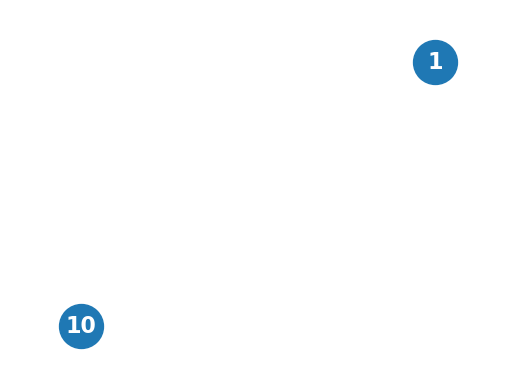

initial_subgraph_V = [1, 10], initial_subgraph_E = []
7-th progressive learning run, SEED = [10514, 5863, 20331, 7814, 22496]



The 1-th global random initialization
SEED = 10514,initial_beta = [1.1651341],initial_gamma = [0.500295]
[1, 10]
=============Circuit Summary=============
|Total number of gates  : 8.            |
|Parameter gates        : 4.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 11            |
None
[1, 10]
1/2 [Z1] +
-1 [] +
1/2 [Z10] 
initial_ex = 0.6053726463879555
weight = [0.500295  1.1651341]
Convergence reached after 47 iterations, with loss evolution: [-0.60537267, -0.6517887, -0.6990975, -0.7471929, -0.79596424, -0.8452956, -0.8950659, -0.945149, -0.99541396, -1.0457253, -1.0959433, -1.1459249, -1.195524, -1.2445928, -1.2929823, -1.3405443, -1.3871316, -1.4325997, -1.4768088, -1.5196246, -1.5609199, -1.6005771, -1.6384883, -1.6745579, -1.7087035, -1.7408571, -1.770966, -1.7989949, -

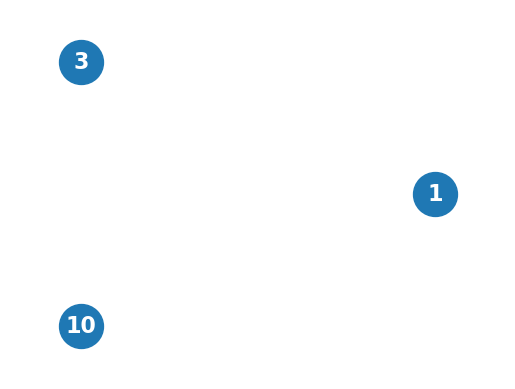

[1, 3, 10]
1/2 [Z1] +
-3/2 [] +
1/2 [Z3] +
1/2 [Z10] 
Transferring optimized parameters params_opt = [[[3.1556056], [2.152659]], [[3.1619992], [2.4256167]]] from old_V = [1, 10] and old_E = [] to new subgraph (new_V = [1, 3, 10], new_E = []), initial_expectation_value = 2.9998527313642107
[1, 3, 10]
=============Circuit Summary=============
|Total number of gates  : 11.           |
|Parameter gates        : 6.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 11            |
None
[1, 3, 10]
1/2 [Z1] +
-3/2 [] +
1/2 [Z3] +
1/2 [Z10] 
initial_ex = 2.9998527313642107
weight = [2.152659  3.1556056]
Convergence reached after 3 iterations, with loss evolution: [-2.9998527, -2.999029, -2.9998639]
Optimized circuit parameters: params = [2.152659, 3.1550844]
new_V = [1, 3, 10], new_E = [], loss after parameter transfer optimization = 2.9998600482940674
Current loss_p = [2.0, 2.99986]


new_E = [], new_V = [1, 3, 9, 10]


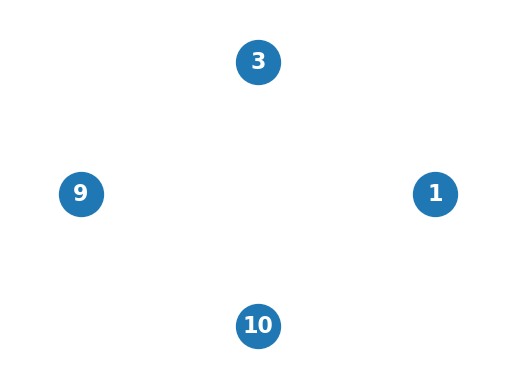

[1, 3, 9, 10]
1/2 [Z1] +
-2 [] +
1/2 [Z3] +
1/2 [Z9] +
1/2 [Z10] 
Transferring optimized parameters params_opt = [[[3.1550844], [2.152659]]] from old_V = [1, 3, 10] and old_E = [] to new subgraph (new_V = [1, 3, 9, 10], new_E = []), initial_expectation_value = 3.9998179763071473
[1, 3, 9, 10]
=============Circuit Summary=============
|Total number of gates  : 14.           |
|Parameter gates        : 8.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 11            |
None
[1, 3, 9, 10]
1/2 [Z1] +
-2 [] +
1/2 [Z3] +
1/2 [Z9] +
1/2 [Z10] 
initial_ex = 3.9998179763071473
weight = [2.152659  3.1550844]
Convergence reached after 5 iterations, with loss evolution: [-3.999818, -3.9986672, -3.9998252, -3.999801, -3.9993327]
Optimized circuit parameters: params = [2.152659, 3.1619897]
new_V = [1, 3, 9, 10], new_E = [], loss after parameter transfer optimization = 3.9993300437927246
Current loss_p = [2.0, 2.99986, 3.99933]

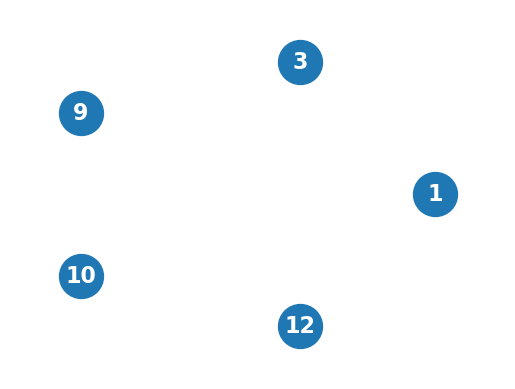

[1, 3, 9, 10, 12]
1/2 [Z1] +
-5/2 [] +
1/2 [Z3] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1619897], [2.152659]]] from old_V = [1, 3, 9, 10] and old_E = [] to new subgraph (new_V = [1, 3, 9, 10, 12], new_E = []), initial_expectation_value = 4.999479969219355
[1, 3, 9, 10, 12]
=============Circuit Summary=============
|Total number of gates  : 17.           |
|Parameter gates        : 10.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 13            |
None
[1, 3, 9, 10, 12]
1/2 [Z1] +
-5/2 [] +
1/2 [Z3] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.9994799692193554
weight = [2.152659  3.1619897]
Convergence reached after 3 iterations, with loss evolution: [-4.99948, -4.9989047, -4.9995966]
Optimized circuit parameters: params = [2.152659, 3.145961]
new_V = [1, 3, 9, 10, 12], new_E = [], loss after parameter transfer optimization = 4.999599933624268
Current loss_p =

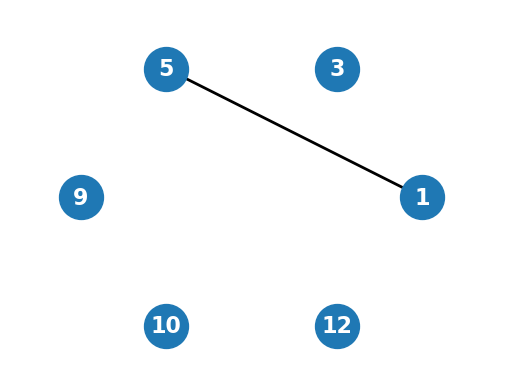

[1, 3, 5, 9, 10, 12]
1/2 [Z1] +
-3 [] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.145961], [2.152659]]] from old_V = [1, 3, 9, 10, 12] and old_E = [] to new subgraph (new_V = [1, 3, 5, 9, 10, 12], new_E = [(1, 5)]), initial_expectation_value = 4.999980917153429
[1, 3, 5, 9, 10, 12]
=============Circuit Summary=============
|Total number of gates  : 24.           |
|Parameter gates        : 12.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 13            |
None
[1, 3, 5, 9, 10, 12]
1/2 [Z1] +
-3 [] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999980917153429
weight = [2.152659 3.145961]
Convergence reached after 5 iterations, with loss evolution: [-4.999981, -4.997918, -4.9998612, -4.9995375, -4.998823]
Optimized circuit parameters: params = [2.152659, 3.1698816]
new_V = [1, 3, 5, 9, 10, 12], new_E = [(1, 5)], loss after

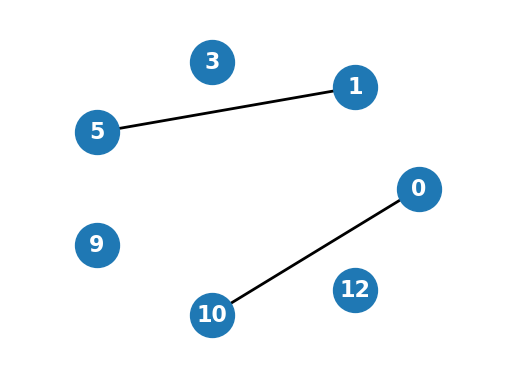

[0, 1, 3, 5, 9, 10, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1698816], [2.152659]]] from old_V = [1, 3, 5, 9, 10, 12] and old_E = [(1, 5)] to new subgraph (new_V = [0, 1, 3, 5, 9, 10, 12], new_E = [(0, 10), (1, 5)]), initial_expectation_value = 4.999399762369272
[0, 1, 3, 5, 9, 10, 12]
=============Circuit Summary=============
|Total number of gates  : 31.           |
|Parameter gates        : 14.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 13            |
None
[0, 1, 3, 5, 9, 10, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999399762369272
weight = [2.152659  3.1698816]
Convergence reached after 3 iterations, with loss evolution: [-4.9993997, -4.9996467, -4.9995074]
Optimized circuit parameters: params = [2.152659, 3.13216]
new_V = [0, 1, 3, 5, 9

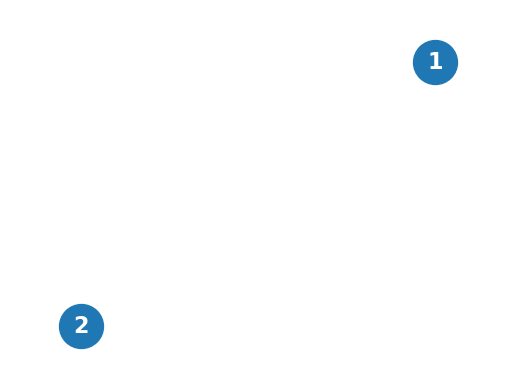

initial_subgraph_V = [1, 2], initial_subgraph_E = []
8-th progressive learning run, SEED = [11154, 6724, 20915, 11774, 8067]



The 1-th global random initialization
SEED = 11154,initial_beta = [2.018626],initial_gamma = [0.3080039]
[1, 2]
=============Circuit Summary=============
|Total number of gates  : 8.            |
|Parameter gates        : 4.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 3             |
None
[1, 2]
1/2 [Z1] +
-1 [] +
1/2 [Z2] 
initial_ex = 1.4330102239135634
weight = [0.3080039 2.018626 ]
Convergence reached after 28 iterations, with loss evolution: [-1.4330102, -1.4775198, -1.5208035, -1.5627301, -1.6031712, -1.6420025, -1.6791056, -1.7143704, -1.7476953, -1.7789915, -1.808183, -1.8352091, -1.8600267, -1.8826115, -1.9029596, -1.9210886, -1.9370384, -1.9508715, -1.9626722, -1.9725462, -1.9806184, -1.9870309, -1.9919395, -1.9955112, -1.9979192, -1.9993396, -1.9999467, -1.9999092]
Optimi

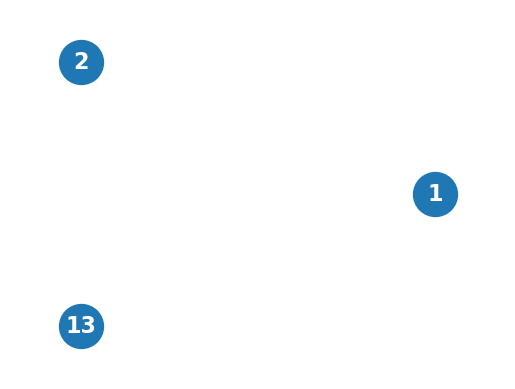

[1, 2, 13]
1/2 [Z1] +
-3/2 [] +
1/2 [Z2] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1586483], [1.3973603]]] from old_V = [1, 2] and old_E = [] to new subgraph (new_V = [1, 2, 13], new_E = []), initial_expectation_value = 2.9997818351983243
[1, 2, 13]
=============Circuit Summary=============
|Total number of gates  : 11.           |
|Parameter gates        : 6.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[1, 2, 13]
1/2 [Z1] +
-3/2 [] +
1/2 [Z2] +
1/2 [Z13] 
initial_ex = 2.9997818351983243
weight = [1.3973603 3.1586483]
Convergence reached after 3 iterations, with loss evolution: [-2.9997818, -2.999186, -2.9998245]
Optimized circuit parameters: params = [1.3973603, 3.1510868]
new_V = [1, 2, 13], new_E = [], loss after parameter transfer optimization = 2.9998199939727783
Current loss_p = [2.0, 2.99982]


new_E = [], new_V = [1, 2, 4, 13]


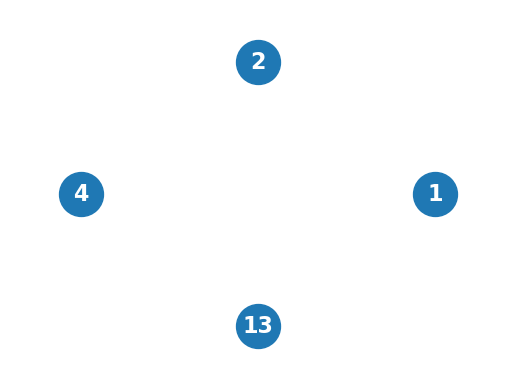

[1, 2, 4, 13]
1/2 [Z1] +
-2 [] +
1/2 [Z2] +
1/2 [Z4] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1510868], [1.3973603]]] from old_V = [1, 2, 13] and old_E = [] to new subgraph (new_V = [1, 2, 4, 13], new_E = []), initial_expectation_value = 3.999909861723339
[1, 2, 4, 13]
=============Circuit Summary=============
|Total number of gates  : 14.           |
|Parameter gates        : 8.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[1, 2, 4, 13]
1/2 [Z1] +
-2 [] +
1/2 [Z2] +
1/2 [Z4] +
1/2 [Z13] 
initial_ex = 3.999909861723339
weight = [1.3973603 3.1510868]
Convergence reached after 5 iterations, with loss evolution: [-3.9999099, -3.9983597, -3.999858, -3.9996717, -3.9991248]
Optimized circuit parameters: params = [1.3973603, 3.1648073]
new_V = [1, 2, 4, 13], new_E = [], loss after parameter transfer optimization = 3.999119997024536
Current loss_p = [2.0, 2.99982, 3.99912]

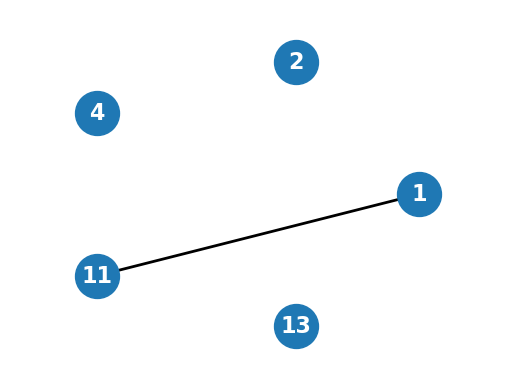

[1, 2, 4, 11, 13]
1/2 [Z1] +
-5/2 [] +
1/2 [Z2] +
1/2 [Z4] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1648073], [1.3973603]]] from old_V = [1, 2, 4, 13] and old_E = [] to new subgraph (new_V = [1, 2, 4, 11, 13], new_E = [(1, 11)]), initial_expectation_value = 3.9995958094613973
[1, 2, 4, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 21.           |
|Parameter gates        : 10.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[1, 2, 4, 11, 13]
1/2 [Z1] +
-5/2 [] +
1/2 [Z2] +
1/2 [Z4] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 3.9995958094613973
weight = [1.3973603 3.1648073]
Convergence reached after 3 iterations, with loss evolution: [-3.9995959, -3.999462, -3.9996817]
Optimized circuit parameters: params = [1.3973603, 3.1411846]
new_V = [1, 2, 4, 11, 13], new_E = [(1, 11)], loss after parameter transfer optimization = 3.9996800422668

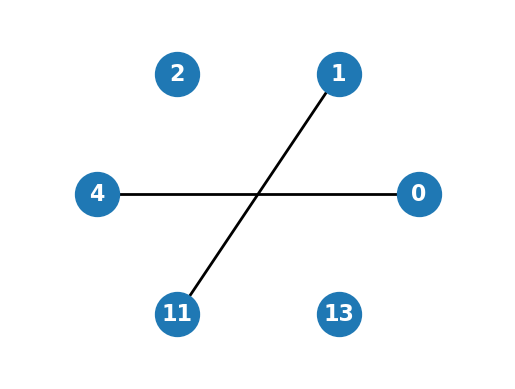

[0, 1, 2, 4, 11, 13]
1/2 [Z0] +
-3 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z4] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1411846], [1.3973603]]] from old_V = [1, 2, 4, 11, 13] and old_E = [(1, 11)] to new subgraph (new_V = [0, 1, 2, 4, 11, 13], new_E = [(0, 4), (1, 11)]), initial_expectation_value = 3.999999916733236
[0, 1, 2, 4, 11, 13]
=============Circuit Summary=============
|Total number of gates  : 28.           |
|Parameter gates        : 12.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 14            |
None
[0, 1, 2, 4, 11, 13]
1/2 [Z0] +
-3 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z4] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 3.999999916733236
weight = [1.3973603 3.1411846]
Convergence reached after 5 iterations, with loss evolution: [-4.0, -3.9987717, -3.9999204, -3.9997373, -3.9992929]
Optimized circuit parameters: params = [1.3973603, 3.1088989]
new_V = [0, 1, 2, 4, 11, 13], new_E = [(

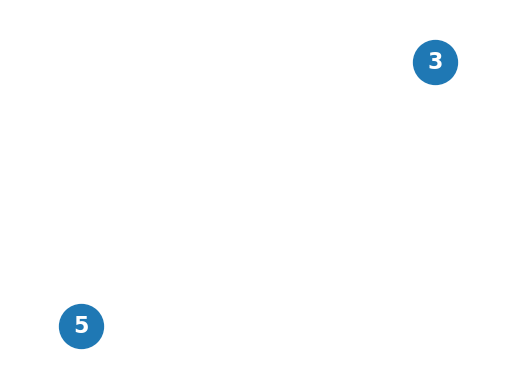

initial_subgraph_V = [3, 5], initial_subgraph_E = []
9-th progressive learning run, SEED = [12444, 8202, 2282, 17135, 14047]



The 1-th global random initialization
SEED = 12444,initial_beta = [0.9155992],initial_gamma = [0.18735926]
[3, 5]
=============Circuit Summary=============
|Total number of gates  : 8.            |
|Parameter gates        : 4.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 6             |
None
[3, 5]
1/2 [Z3] +
-1 [] +
1/2 [Z5] 
initial_ex = 0.3906844588816562
weight = [0.18735926 0.9155992 ]
train_step = 50, loss = -1.999650001525879
Convergence reached after 52 iterations, with loss evolution: [-0.39068446, -0.43107578, -0.47292235, -0.5161415, -0.5606462, -0.6063432, -0.65313387, -0.7009128, -0.7495682, -0.79898125, -0.8490264, -0.8995713, -0.9504773, -1.0015996, -1.0527879, -1.1038873, -1.154739, -1.2051812, -1.2550509, -1.3041842, -1.3524189, -1.3995951, -1.4455575, -1.4901567, -1

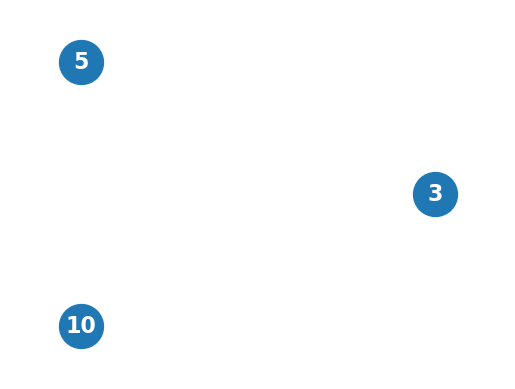

[3, 5, 10]
1/2 [Z3] +
-3/2 [] +
1/2 [Z5] +
1/2 [Z10] 
Transferring optimized parameters params_opt = [[[3.1618016], [2.3292224]]] from old_V = [3, 5] and old_E = [] to new subgraph (new_V = [3, 5, 10], new_E = []), initial_expectation_value = 2.9996937099969383
[3, 5, 10]
=============Circuit Summary=============
|Total number of gates  : 11.           |
|Parameter gates        : 6.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 11            |
None
[3, 5, 10]
1/2 [Z3] +
-3/2 [] +
1/2 [Z5] +
1/2 [Z10] 
initial_ex = 2.9996937099969383
weight = [2.3292224 3.1618016]
Convergence reached after 3 iterations, with loss evolution: [-2.9996936, -2.9993343, -2.9997623]
Optimized circuit parameters: params = [2.3292224, 3.1462672]
new_V = [3, 5, 10], new_E = [], loss after parameter transfer optimization = 2.9997599124908447
Current loss_p = [2.0, 2.99976]


new_E = [], new_V = [3, 5, 10, 12]


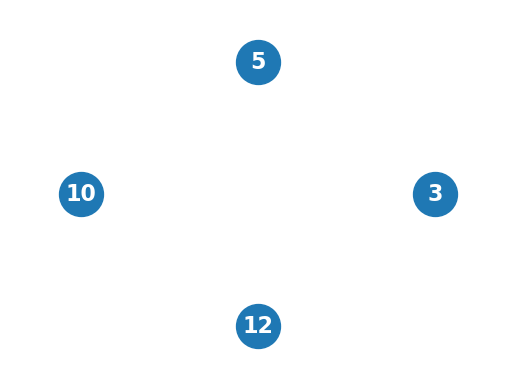

[3, 5, 10, 12]
1/2 [Z3] +
-2 [] +
1/2 [Z5] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1462672], [2.3292224]]] from old_V = [3, 5, 10] and old_E = [] to new subgraph (new_V = [3, 5, 10, 12], new_E = []), initial_expectation_value = 3.999978148883071
[3, 5, 10, 12]
=============Circuit Summary=============
|Total number of gates  : 14.           |
|Parameter gates        : 8.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 13            |
None
[3, 5, 10, 12]
1/2 [Z3] +
-2 [] +
1/2 [Z5] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 3.9999781488830704
weight = [2.3292224 3.1462672]
Convergence reached after 5 iterations, with loss evolution: [-3.999978, -3.997946, -3.999862, -3.9995437, -3.998842]
Optimized circuit parameters: params = [2.3292224, 3.169547]
new_V = [3, 5, 10, 12], new_E = [], loss after parameter transfer optimization = 3.998840093612671
Current loss_p = [2.0, 2.99976, 3.99

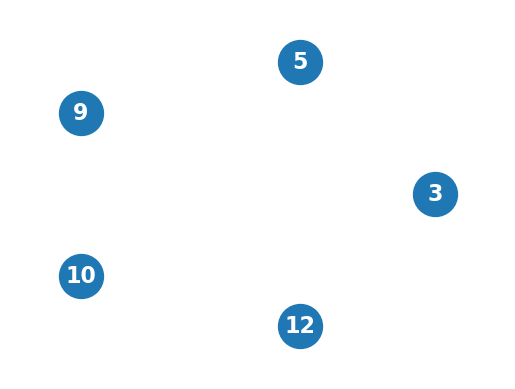

[3, 5, 9, 10, 12]
1/2 [Z3] +
-5/2 [] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.169547], [2.3292224]]] from old_V = [3, 5, 10, 12] and old_E = [] to new subgraph (new_V = [3, 5, 9, 10, 12], new_E = []), initial_expectation_value = 4.999023251094846
[3, 5, 9, 10, 12]
=============Circuit Summary=============
|Total number of gates  : 17.           |
|Parameter gates        : 10.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 13            |
None
[3, 5, 9, 10, 12]
1/2 [Z3] +
-5/2 [] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999023251094846
weight = [2.3292224 3.169547 ]
Convergence reached after 3 iterations, with loss evolution: [-4.9990234, -4.9993925, -4.9992]
Optimized circuit parameters: params = [2.3292224, 3.1327555]
new_V = [3, 5, 9, 10, 12], new_E = [], loss after parameter transfer optimization = 4.999199867248535
Current loss_p 

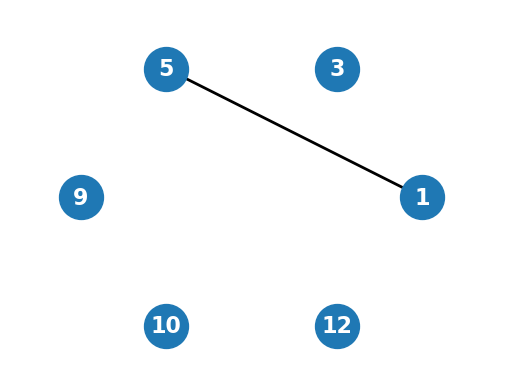

[1, 3, 5, 9, 10, 12]
1/2 [Z1] +
-3 [] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1327555], [2.3292224]]] from old_V = [3, 5, 9, 10, 12] and old_E = [] to new subgraph (new_V = [1, 3, 5, 9, 10, 12], new_E = [(1, 5)]), initial_expectation_value = 4.999921905160919
[1, 3, 5, 9, 10, 12]
=============Circuit Summary=============
|Total number of gates  : 24.           |
|Parameter gates        : 12.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 13            |
None
[1, 3, 5, 9, 10, 12]
1/2 [Z1] +
-3 [] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999921905160919
weight = [2.3292224 3.1327555]
Convergence reached after 5 iterations, with loss evolution: [-4.999922, -4.998306, -4.9998603, -4.999652, -4.999088]
Optimized circuit parameters: params = [2.3292224, 3.1177988]
new_V = [1, 3, 5, 9, 10, 12], new_E = [(1, 5)], loss a

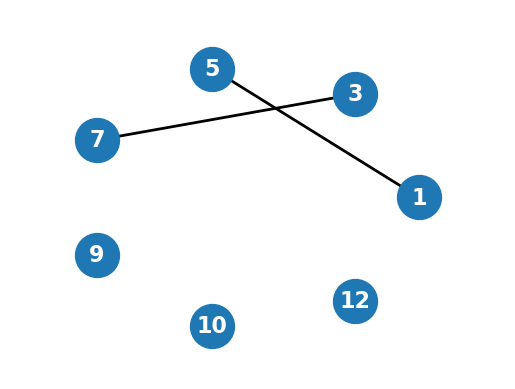

[1, 3, 5, 7, 9, 10, 12]
1/2 [Z1] +
-7/2 [] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1177988], [2.3292224]]] from old_V = [1, 3, 5, 9, 10, 12] and old_E = [(1, 5)] to new subgraph (new_V = [1, 3, 5, 7, 9, 10, 12], new_E = [(1, 5), (3, 7)]), initial_expectation_value = 4.999575369556152
[1, 3, 5, 7, 9, 10, 12]
=============Circuit Summary=============
|Total number of gates  : 31.           |
|Parameter gates        : 14.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 13            |
None
[1, 3, 5, 7, 9, 10, 12]
1/2 [Z1] +
-7/2 [] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999575369556152
weight = [2.3292224 3.1177988]
Convergence reached after 3 iterations, with loss evolution: [-4.999575, -4.999485, -4.999664]
Optimized circuit parameters: params = [2.3292224, 3.143017]
new_V = [1, 3, 5, 7, 9,

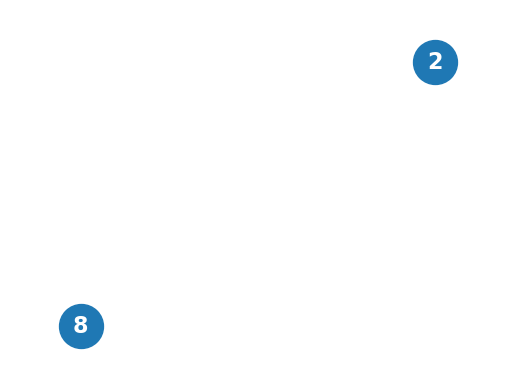

initial_subgraph_V = [2, 8], initial_subgraph_E = []
10-th progressive learning run, SEED = [19119, 1075, 1798, 18290, 15979]



The 1-th global random initialization
SEED = 19119,initial_beta = [1.4234147],initial_gamma = [2.7446225]
[2, 8]
=============Circuit Summary=============
|Total number of gates  : 8.            |
|Parameter gates        : 4.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 9             |
None
[2, 8]
1/2 [Z2] +
-1 [] +
1/2 [Z8] 
initial_ex = 0.8531513556350568
weight = [2.7446225 1.4234147]
Convergence reached after 42 iterations, with loss evolution: [-0.8531514, -0.9027722, -0.95264363, -1.002642, -1.0526403, -1.1025075, -1.1521094, -1.2013096, -1.2499696, -1.2979497, -1.3451099, -1.3913112, -1.4364161, -1.4802912, -1.5228066, -1.5638392, -1.603273, -1.641001, -1.6769266, -1.7109653, -1.7430454, -1.7731102, -1.8011179, -1.8270437, -1.850879, -1.872633, -1.8923321, -1.9100194, -1.9257

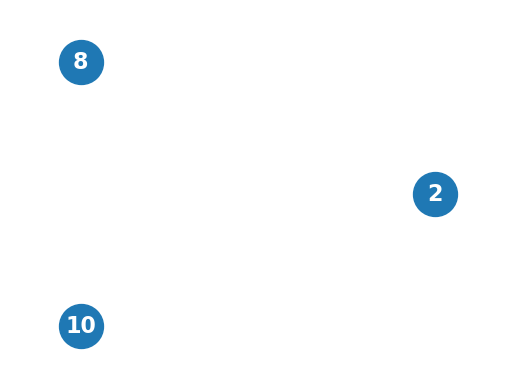

[2, 8, 10]
1/2 [Z2] +
-3/2 [] +
1/2 [Z8] +
1/2 [Z10] 
Transferring optimized parameters params_opt = [[[3.156045], [1.3329146]]] from old_V = [2, 8] and old_E = [] to new subgraph (new_V = [2, 8, 10], new_E = []), initial_expectation_value = 2.99984335085572
[2, 8, 10]
=============Circuit Summary=============
|Total number of gates  : 11.           |
|Parameter gates        : 6.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 11            |
None
[2, 8, 10]
1/2 [Z2] +
-3/2 [] +
1/2 [Z8] +
1/2 [Z10] 
initial_ex = 2.99984335085572
weight = [1.3329146 3.156045 ]
Convergence reached after 3 iterations, with loss evolution: [-2.9998434, -2.9990525, -2.9998593]
Optimized circuit parameters: params = [1.3329146, 3.15455]
new_V = [2, 8, 10], new_E = [], loss after parameter transfer optimization = 2.9998600482940674
Current loss_p = [2.0, 2.99986]


new_E = [], new_V = [2, 3, 8, 10]


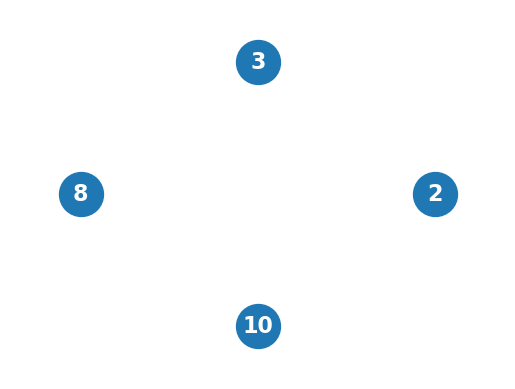

[2, 3, 8, 10]
1/2 [Z2] +
-2 [] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] 
Transferring optimized parameters params_opt = [[[3.15455], [1.3329146]]] from old_V = [2, 8, 10] and old_E = [] to new subgraph (new_V = [2, 3, 8, 10], new_E = []), initial_expectation_value = 3.9998321075656773
[2, 3, 8, 10]
=============Circuit Summary=============
|Total number of gates  : 14.           |
|Parameter gates        : 8.            |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 11            |
None
[2, 3, 8, 10]
1/2 [Z2] +
-2 [] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] 
initial_ex = 3.9998321075656773
weight = [1.3329146 3.15455  ]
Convergence reached after 5 iterations, with loss evolution: [-3.9998322, -3.9986281, -3.9998314, -3.9997835, -3.999307]
Optimized circuit parameters: params = [1.3329146, 3.162287]
new_V = [2, 3, 8, 10], new_E = [], loss after parameter transfer optimization = 3.99931001663208
Current loss_p = [2.0, 2.99986, 3.99931]



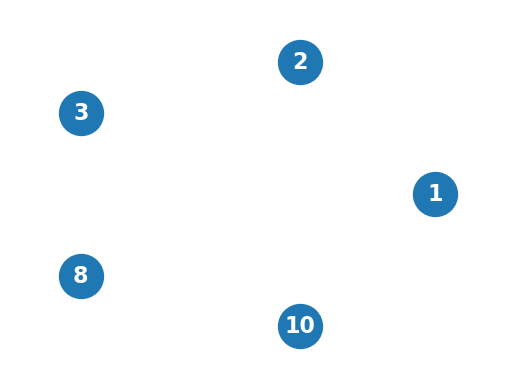

[1, 2, 3, 8, 10]
1/2 [Z1] +
-5/2 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] 
Transferring optimized parameters params_opt = [[[3.162287], [1.3329146]]] from old_V = [2, 3, 8, 10] and old_E = [] to new subgraph (new_V = [1, 2, 3, 8, 10], new_E = []), initial_expectation_value = 4.999464699300945
[1, 2, 3, 8, 10]
=============Circuit Summary=============
|Total number of gates  : 17.           |
|Parameter gates        : 10.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 11            |
None
[1, 2, 3, 8, 10]
1/2 [Z1] +
-5/2 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] 
initial_ex = 4.999464699300945
weight = [1.3329146 3.162287 ]
Convergence reached after 3 iterations, with loss evolution: [-4.9994645, -4.9989266, -4.9995847]
Optimized circuit parameters: params = [1.3329146, 3.1454735]
new_V = [1, 2, 3, 8, 10], new_E = [], loss after parameter transfer optimization = 4.999579906463623
Current loss_p = [2.

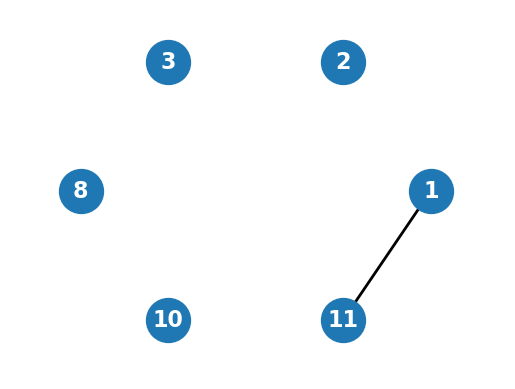

[1, 2, 3, 8, 10, 11]
1/2 [Z1] +
-3 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1454735], [1.3329146]]] from old_V = [1, 2, 3, 8, 10] and old_E = [] to new subgraph (new_V = [1, 2, 3, 8, 10, 11], new_E = [(1, 11)]), initial_expectation_value = 4.9999849391893525
[1, 2, 3, 8, 10, 11]
=============Circuit Summary=============
|Total number of gates  : 24.           |
|Parameter gates        : 12.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[1, 2, 3, 8, 10, 11]
1/2 [Z1] +
-3 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] +
1/2 [Z11] 
initial_ex = 4.9999849391893525
weight = [1.3329146 3.1454735]
Convergence reached after 5 iterations, with loss evolution: [-4.9999847, -4.9978733, -4.99986, -4.9995275, -4.9987936]
Optimized circuit parameters: params = [1.3329146, 3.1704137]
new_V = [1, 2, 3, 8, 10, 11], new_E = [(1, 11)], l

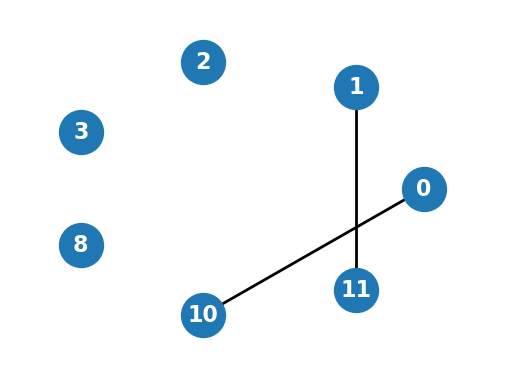

[0, 1, 2, 3, 8, 10, 11]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[3.1704137], [1.3329146]]] from old_V = [1, 2, 3, 8, 10, 11] and old_E = [(1, 11)] to new subgraph (new_V = [0, 1, 2, 3, 8, 10, 11], new_E = [(0, 10), (1, 11)]), initial_expectation_value = 4.999376965943154
[0, 1, 2, 3, 8, 10, 11]
=============Circuit Summary=============
|Total number of gates  : 31.           |
|Parameter gates        : 14.           |
|with 2 parameters are  :               |
|gamma1, beta1                        . |
|Number qubit of circuit: 12            |
None
[0, 1, 2, 3, 8, 10, 11]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] +
1/2 [Z11] 
initial_ex = 4.999376965943154
weight = [1.3329146 3.1704137]
Convergence reached after 3 iterations, with loss evolution: [-4.999377, -4.9996634, -4.999488]
Optimized circuit parameters: params = [1.3329146, 3.131221]
new_V = [0, 1, 2, 3

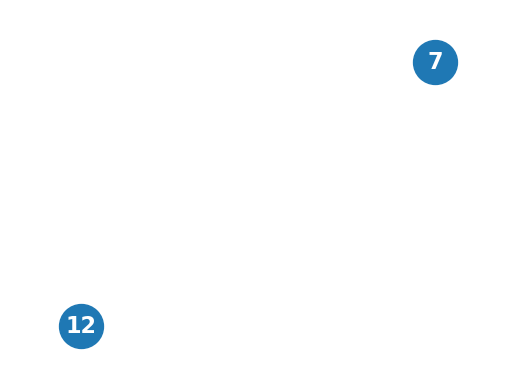

initial_subgraph_V = [7, 12], initial_subgraph_E = []
1-th progressive learning run, SEED = [18478, 5444, 20823, 21701, 13981]



The 1-th global random initialization
SEED = 18478,initial_beta = [0.5809276, 1.7701789],initial_gamma = [2.3995042, 0.6377584]
[7, 12]
====================Circuit Summary====================
|Total number of gates  : 16.                         |
|Parameter gates        : 8.                          |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[7, 12]
1/2 [Z7] +
-1 [] +
1/2 [Z12] 
initial_ex = 1.597760832911216
weight = [2.3995042 0.5809276 0.6377584 1.7701789]
Convergence reached after 27 iterations, with loss evolution: [-1.5977608, -1.6750062, -1.745584, -1.8082838, -1.8620669, -1.9061631, -1.9401877, -1.96426, -1.9790977, -1.9860386, -1.9869391, -1.9839376, -1.9791287, -1.9742591, -1.9705423, -1.9686228, -1.968655, -1.9704344

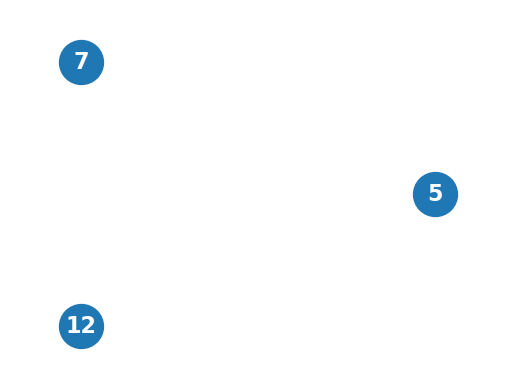

[5, 7, 12]
1/2 [Z5] +
-3/2 [] +
1/2 [Z7] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[2.106412, 1.0648098], [0.007866495, -0.0076483362]]] from old_V = [7, 12] and old_E = [] to new subgraph (new_V = [5, 7, 12], new_E = []), initial_expectation_value = 2.9993086354751606
[5, 7, 12]
====================Circuit Summary====================
|Total number of gates  : 22.                         |
|Parameter gates        : 12.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[5, 7, 12]
1/2 [Z5] +
-3/2 [] +
1/2 [Z7] +
1/2 [Z12] 
initial_ex = 2.9993086354751606
weight = [ 0.0078665   2.106412   -0.00764834  1.0648098 ]
Convergence reached after 9 iterations, with loss evolution: [-2.9993086, -2.9952772, -2.9993427, -2.999316, -2.9976318, -2.9984772, -2.9998357, -2.9997458, -2.9988675]
Optimized circuit parameters: params = [0.00

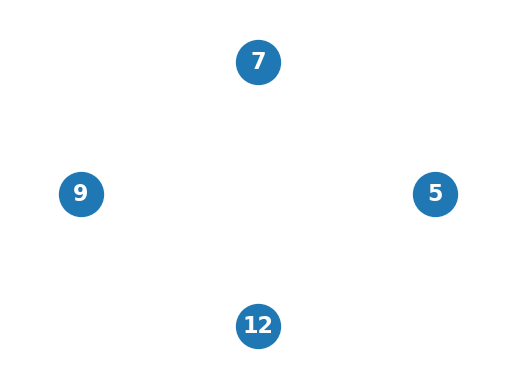

[5, 7, 9, 12]
1/2 [Z5] +
-2 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[2.0752, 1.0315431], [0.007866495, 0.0226403]]] from old_V = [5, 7, 12] and old_E = [] to new subgraph (new_V = [5, 7, 9, 12], new_E = []), initial_expectation_value = 3.9984005892381957
[5, 7, 9, 12]
====================Circuit Summary====================
|Total number of gates  : 28.                         |
|Parameter gates        : 16.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[5, 7, 9, 12]
1/2 [Z5] +
-2 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z12] 
initial_ex = 3.9984005892381957
weight = [0.0078665 2.0752    0.0226403 1.0315431]
Convergence reached after 9 iterations, with loss evolution: [-3.9984007, -3.9951952, -3.9987278, -3.9996789, -3.9978073, -3.9982617, -3.9997349, -3.999779, -3.99885]
Optimized circuit parameter

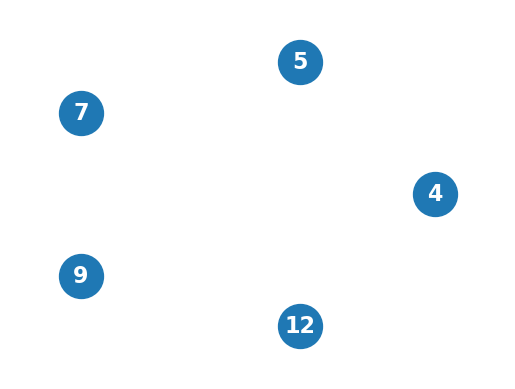

[4, 5, 7, 9, 12]
1/2 [Z4] +
-5/2 [] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[2.109497, 1.0643691], [0.007866495, -0.015297313]]] from old_V = [5, 7, 9, 12] and old_E = [] to new subgraph (new_V = [4, 5, 7, 9, 12], new_E = []), initial_expectation_value = 4.998478575732204
[4, 5, 7, 9, 12]
====================Circuit Summary====================
|Total number of gates  : 34.                         |
|Parameter gates        : 20.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[4, 5, 7, 9, 12]
1/2 [Z4] +
-5/2 [] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z12] 
initial_ex = 4.998478575732204
weight = [ 0.0078665   2.109497   -0.01529731  1.0643691 ]
Convergence reached after 13 iterations, with loss evolution: [-4.9984784, -4.99314, -4.9987316, -4.9992886, -4.9967165, -4.9977694, -4.999766

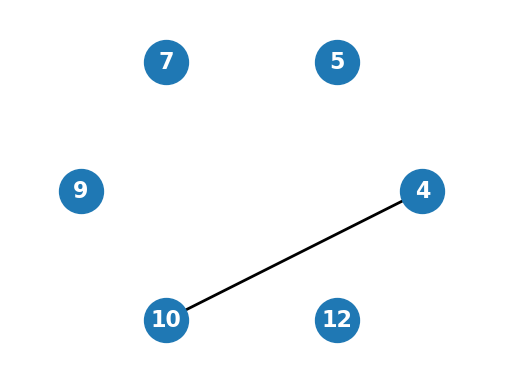

[4, 5, 7, 9, 10, 12]
1/2 [Z4] +
-3 [] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[2.1080868, 1.0607852], [0.007866495, -0.013894718]]] from old_V = [4, 5, 7, 9, 12] and old_E = [] to new subgraph (new_V = [4, 5, 7, 9, 10, 12], new_E = [(4, 10)]), initial_expectation_value = 4.826815887554042
[4, 5, 7, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 48.                         |
|Parameter gates        : 24.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[4, 5, 7, 9, 10, 12]
1/2 [Z4] +
-3 [] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.826815887554042
weight = [ 0.0078665   2.1080868  -0.01389472  1.0607852 ]
Convergence reached after 47 iterations, with loss evolution: [-4.826816, -4.8542295, -4.862739

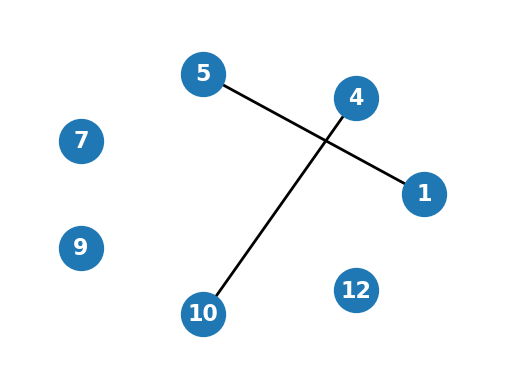

[1, 4, 5, 7, 9, 10, 12]
1/2 [Z1] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1089544, 0.033889562], [0.007866495, 0.0027546957]]] from old_V = [4, 5, 7, 9, 10, 12] and old_E = [(4, 10)] to new subgraph (new_V = [1, 4, 5, 7, 9, 10, 12], new_E = [(1, 5), (4, 10)]), initial_expectation_value = 4.999424246124318
[1, 4, 5, 7, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 62.                         |
|Parameter gates        : 28.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[1, 4, 5, 7, 9, 10, 12]
1/2 [Z1] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999424246124318
weight = [7.8664953e-03 3.1089544e+00 2.7546957e-03 3.3889562e-02]
Convergence reached after 11

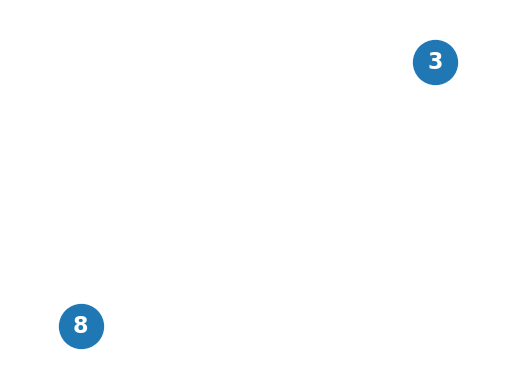

initial_subgraph_V = [3, 8], initial_subgraph_E = []
2-th progressive learning run, SEED = [10804, 1530, 5746, 8751, 7661]



The 1-th global random initialization
SEED = 10804,initial_beta = [1.7206376, 2.9282475],initial_gamma = [0.698275, 0.96956396]
[3, 8]
====================Circuit Summary====================
|Total number of gates  : 16.                         |
|Parameter gates        : 8.                          |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 9                           |
None
[3, 8]
1/2 [Z3] +
-1 [] +
1/2 [Z8] 
initial_ex = 0.9725285848332089
weight = [0.698275   1.7206376  0.96956396 2.9282475 ]
Convergence reached after 40 iterations, with loss evolution: [-0.9725286, -1.0607675, -1.1512531, -1.2428213, -1.3342284, -1.4241633, -1.5112716, -1.5941885, -1.6715817, -1.7422054, -1.8049642, -1.8589818, -1.9036721, -1.938803, -1.964542, -1.9814736, -1.9905754, -1.9931513

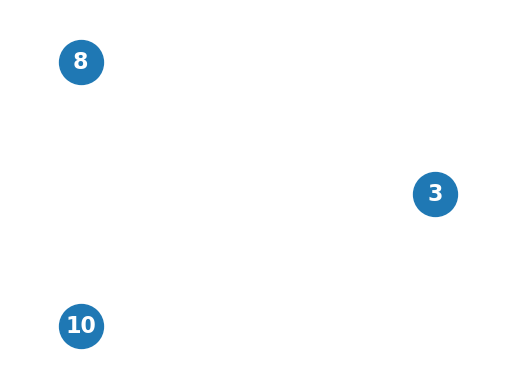

[3, 8, 10]
1/2 [Z3] +
-3/2 [] +
1/2 [Z8] +
1/2 [Z10] 
Transferring optimized parameters params_opt = [[[3.1614547, -0.019217892], [3.0236185, 0.65995044]]] from old_V = [3, 8] and old_E = [] to new subgraph (new_V = [3, 8, 10], new_E = []), initial_expectation_value = 2.9998794796148296
[3, 8, 10]
====================Circuit Summary====================
|Total number of gates  : 22.                         |
|Parameter gates        : 12.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 11                          |
None
[3, 8, 10]
1/2 [Z3] +
-3/2 [] +
1/2 [Z8] +
1/2 [Z10] 
initial_ex = 2.9998794796148296
weight = [ 3.0236185   3.1614547   0.65995044 -0.01921789]
Convergence reached after 3 iterations, with loss evolution: [-2.9998796, -2.999749, -2.999817]
Optimized circuit parameters: params = [3.0236185, 3.1450617, 0.516877, 0.029245747]
new_V = [3, 8, 10], new_E = [], lo

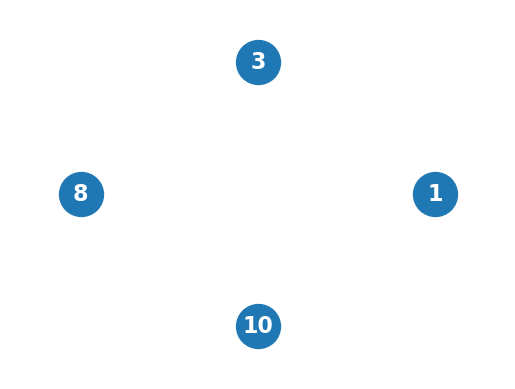

[1, 3, 8, 10]
1/2 [Z1] +
-2 [] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] 
Transferring optimized parameters params_opt = [[[3.1450617, 0.029245747], [3.0236185, 0.516877]]] from old_V = [3, 8, 10] and old_E = [] to new subgraph (new_V = [1, 3, 8, 10], new_E = []), initial_expectation_value = 3.998956338848249
[1, 3, 8, 10]
====================Circuit Summary====================
|Total number of gates  : 28.                         |
|Parameter gates        : 16.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 11                          |
None
[1, 3, 8, 10]
1/2 [Z1] +
-2 [] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] 
initial_ex = 3.998956338848249
weight = [3.0236185  3.1450617  0.516877   0.02924575]
Convergence reached after 9 iterations, with loss evolution: [-3.9989564, -3.9957762, -3.9991217, -3.9996047, -3.9980693, -3.998581, -3.9997907, -3.999854, -3.999128]
Optimized circuit param

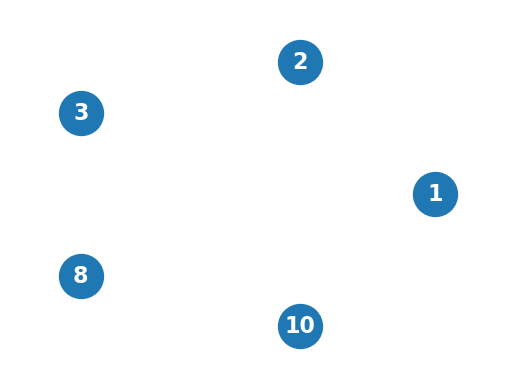

[1, 2, 3, 8, 10]
1/2 [Z1] +
-5/2 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] 
Transferring optimized parameters params_opt = [[[3.1268113, -0.020174192], [3.0236185, 0.83935505]]] from old_V = [1, 3, 8, 10] and old_E = [] to new subgraph (new_V = [1, 2, 3, 8, 10], new_E = []), initial_expectation_value = 4.998720314660414
[1, 2, 3, 8, 10]
====================Circuit Summary====================
|Total number of gates  : 34.                         |
|Parameter gates        : 20.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 11                          |
None
[1, 2, 3, 8, 10]
1/2 [Z1] +
-5/2 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] 
initial_ex = 4.998720314660414
weight = [ 3.0236185   3.1268113   0.83935505 -0.02017419]
Convergence reached after 9 iterations, with loss evolution: [-4.99872, -4.995685, -4.998967, -4.9997435, -4.9981403, -4.9984612, -4.999699, -

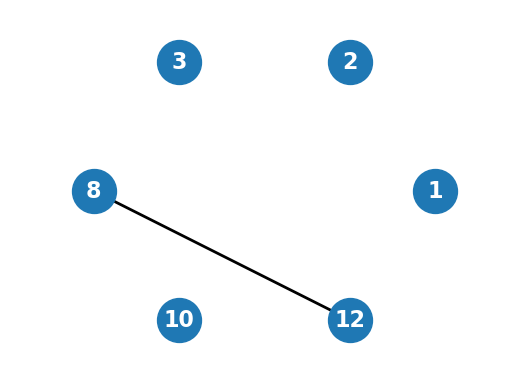

[1, 2, 3, 8, 10, 12]
1/2 [Z1] +
-3 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1577506, 0.018735675], [3.0236185, 1.1927091]]] from old_V = [1, 2, 3, 8, 10] and old_E = [] to new subgraph (new_V = [1, 2, 3, 8, 10, 12], new_E = [(8, 12)]), initial_expectation_value = 4.999078592934927
[1, 2, 3, 8, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 48.                         |
|Parameter gates        : 24.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[1, 2, 3, 8, 10, 12]
1/2 [Z1] +
-3 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999078592934926
weight = [3.0236185  3.1577506  1.1927091  0.01873568]
Convergence reached after 7 iterations, with loss evolution: [-4.9990788, -4.9969406, -4.999267, -4.99

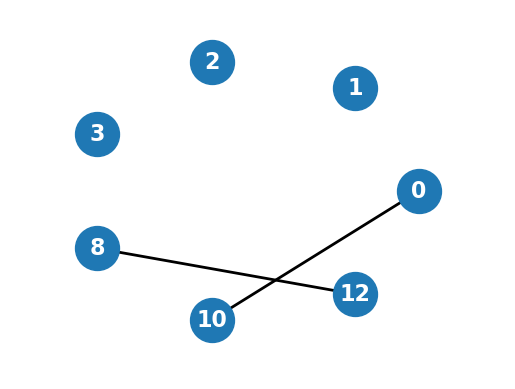

[0, 1, 2, 3, 8, 10, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1387684, -0.004426151], [3.0236185, 1.4789807]]] from old_V = [1, 2, 3, 8, 10, 12] and old_E = [(8, 12)] to new subgraph (new_V = [0, 1, 2, 3, 8, 10, 12], new_E = [(0, 10), (8, 12)]), initial_expectation_value = 4.9999677810054415
[0, 1, 2, 3, 8, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 62.                         |
|Parameter gates        : 28.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 2, 3, 8, 10, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z8] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.9999677810054415
weight = [ 3.0236185   3.1387684   1.4789807  -0.00442615]
Convergence reached after 9 iteration

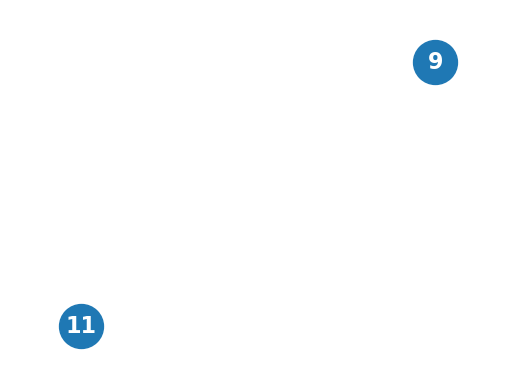

initial_subgraph_V = [9, 11], initial_subgraph_E = []
3-th progressive learning run, SEED = [4472, 11213, 21846, 4704, 12987]



The 1-th global random initialization
SEED = 4472,initial_beta = [1.5300515, 2.0842125],initial_gamma = [2.7064807, 1.0717877]
[9, 11]
====================Circuit Summary====================
|Total number of gates  : 16.                         |
|Parameter gates        : 8.                          |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 12                          |
None
[9, 11]
1/2 [Z9] +
-1 [] +
1/2 [Z11] 
initial_ex = 1.4365165263870425
weight = [2.7064807 1.5300515 1.0717877 2.0842125]
Convergence reached after 28 iterations, with loss evolution: [-1.4365165, -1.5053906, -1.5673685, -1.6215184, -1.6675172, -1.706131, -1.7393295, -1.7693948, -1.7978313, -1.8251921, -1.8514266, -1.876183, -1.8989906, -1.9193802, -1.9369787, -1.9515871, -1.9632342, -1.972189

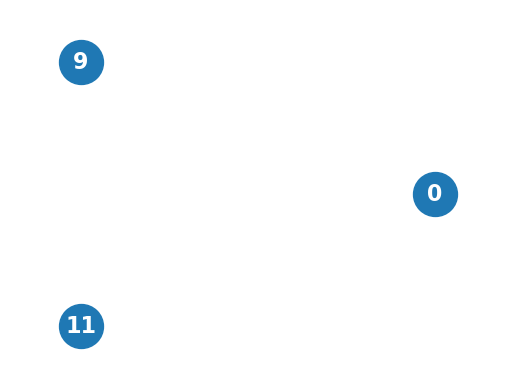

[0, 9, 11]
1/2 [Z0] +
-3/2 [] +
1/2 [Z9] +
1/2 [Z11] 
Transferring optimized parameters params_opt = [[[0.91132444, 2.2129323], [2.7064807, -0.04075722]]] from old_V = [9, 11] and old_E = [] to new subgraph (new_V = [0, 9, 11], new_E = []), initial_expectation_value = 2.9989862094858806
[0, 9, 11]
====================Circuit Summary====================
|Total number of gates  : 22.                         |
|Parameter gates        : 12.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 12                          |
None
[0, 9, 11]
1/2 [Z0] +
-3/2 [] +
1/2 [Z9] +
1/2 [Z11] 
initial_ex = 2.9989862094858806
weight = [ 2.7064807   0.91132444 -0.04075722  2.2129323 ]
Convergence reached after 9 iterations, with loss evolution: [-2.9989862, -2.9948375, -2.9990437, -2.998559, -2.9971797, -2.9982476, -2.9995584, -2.9995327, -2.9987109]
Optimized circuit parameters: params = [2.7064

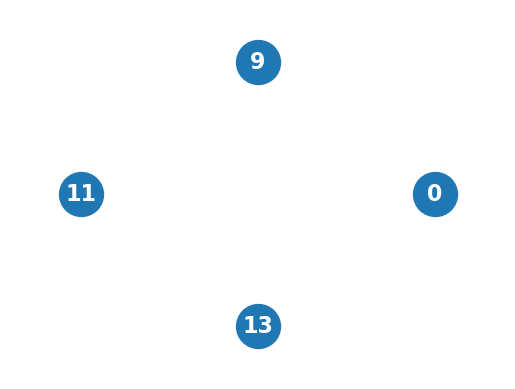

[0, 9, 11, 13]
1/2 [Z0] +
-2 [] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[0.9405408, 2.2448668], [2.7064807, -0.0060231625]]] from old_V = [0, 9, 11] and old_E = [] to new subgraph (new_V = [0, 9, 11, 13], new_E = []), initial_expectation_value = 3.9980576558593945
[0, 9, 11, 13]
====================Circuit Summary====================
|Total number of gates  : 28.                         |
|Parameter gates        : 16.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[0, 9, 11, 13]
1/2 [Z0] +
-2 [] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 3.998057655859395
weight = [ 2.7064807   0.9405408  -0.00602316  2.2448668 ]
Convergence reached after 9 iterations, with loss evolution: [-3.9980576, -3.9956243, -3.998415, -3.9997182, -3.998045, -3.9980736, -3.9995282, -3.9999337, -3.9990773]
Optimize

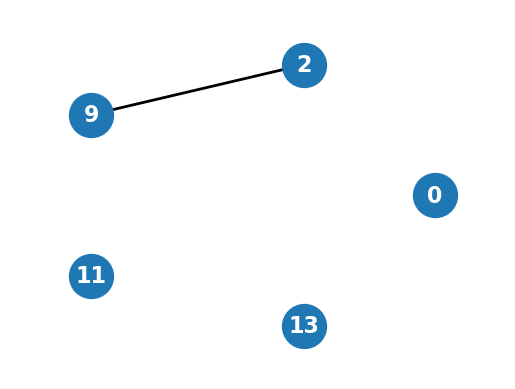

[0, 2, 9, 11, 13]
1/2 [Z0] +
-5/2 [] +
1/2 [Z2] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[0.9018625, 2.2090786], [2.7064807, 0.023707815]]] from old_V = [0, 9, 11, 13] and old_E = [] to new subgraph (new_V = [0, 2, 9, 11, 13], new_E = [(2, 9)]), initial_expectation_value = 3.8681800748299486
[0, 2, 9, 11, 13]
====================Circuit Summary====================
|Total number of gates  : 42.                         |
|Parameter gates        : 20.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[0, 2, 9, 11, 13]
1/2 [Z0] +
-5/2 [] +
1/2 [Z2] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 3.868180074829949
weight = [2.7064807  0.9018625  0.02370781 2.2090786 ]
Convergence reached after 34 iterations, with loss evolution: [-3.86818, -3.8850214, -3.8872585, -3.88618, -3.887941, -3.892583, -3.89

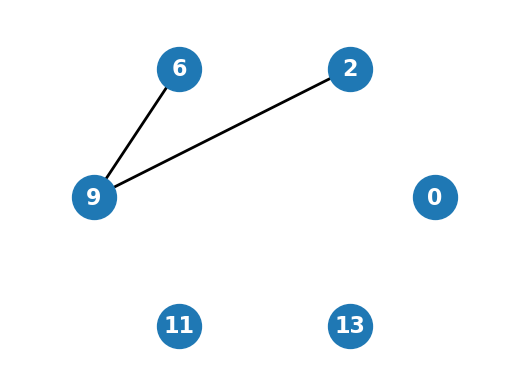

[0, 2, 6, 9, 11, 13]
1/2 [Z0] +
-3 [] +
1/2 [Z2] +
1/2 [Z6] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[0.0060755466, 3.1255271], [2.7064807, -0.0014570209]]] from old_V = [0, 2, 9, 11, 13] and old_E = [(2, 9)] to new subgraph (new_V = [0, 2, 6, 9, 11, 13], new_E = [(2, 9), (6, 9)]), initial_expectation_value = 4.999856799005047
[0, 2, 6, 9, 11, 13]
====================Circuit Summary====================
|Total number of gates  : 56.                         |
|Parameter gates        : 24.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[0, 2, 6, 9, 11, 13]
1/2 [Z0] +
-3 [] +
1/2 [Z2] +
1/2 [Z6] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.999856799005047
weight = [ 2.7064807e+00  6.0755466e-03 -1.4570209e-03  3.1255271e+00]
Convergence reached after 14 iterations, with loss evolution: [-4.9

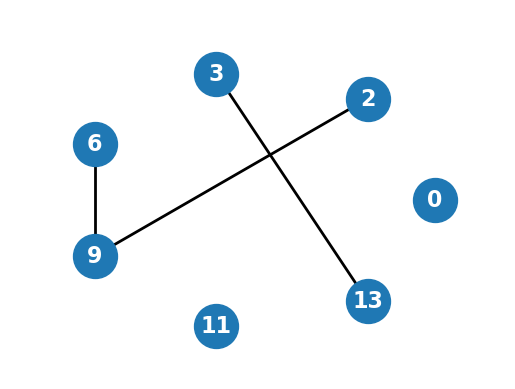

[0, 2, 3, 6, 9, 11, 13]
1/2 [Z0] +
-7/2 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z6] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[-0.019141054, 3.1280763], [2.7064807, 0.52711284]]] from old_V = [0, 2, 6, 9, 11, 13] and old_E = [(2, 9), (6, 9)] to new subgraph (new_V = [0, 2, 3, 6, 9, 11, 13], new_E = [(2, 9), (3, 13), (6, 9)]), initial_expectation_value = 4.998727135624348
[0, 2, 3, 6, 9, 11, 13]
====================Circuit Summary====================
|Total number of gates  : 70.                         |
|Parameter gates        : 28.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[0, 2, 3, 6, 9, 11, 13]
1/2 [Z0] +
-7/2 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z6] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.998727135624348
weight = [ 2.7064807  -0.01914105  0.52711284  3.1280763 ]
Convergence reached afte

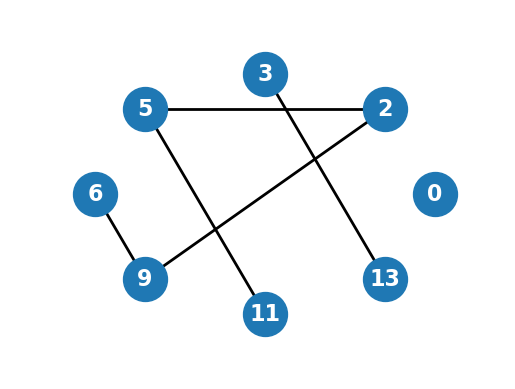

[0, 2, 3, 5, 6, 9, 11, 13]
1/2 [Z0] +
-4 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z6] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[0.0186066, 3.1567385], [2.7064807, 0.87722534]]] from old_V = [0, 2, 3, 6, 9, 11, 13] and old_E = [(2, 9), (3, 13), (6, 9)] to new subgraph (new_V = [0, 2, 3, 5, 6, 9, 11, 13], new_E = [(2, 9), (2, 5), (3, 13), (5, 11), (6, 9)]), initial_expectation_value = 4.998720127172295
[0, 2, 3, 5, 6, 9, 11, 13]
====================Circuit Summary====================
|Total number of gates  : 92.                         |
|Parameter gates        : 32.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[0, 2, 3, 5, 6, 9, 11, 13]
1/2 [Z0] +
-4 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z6] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.998720127172295
weight = [2.7064807  0.0186

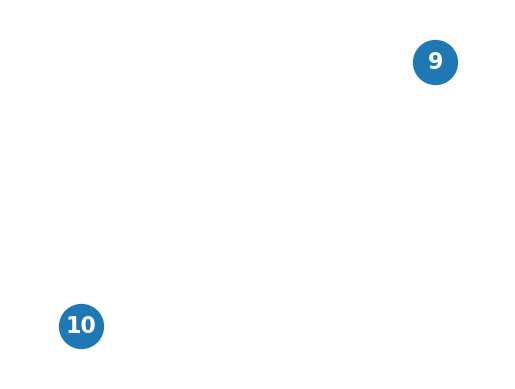

initial_subgraph_V = [9, 10], initial_subgraph_E = []
4-th progressive learning run, SEED = [14832, 16007, 4571, 7196, 18820]



The 1-th global random initialization
SEED = 14832,initial_beta = [2.0354433, 0.7251614],initial_gamma = [0.03699655, 2.1703193]
[9, 10]
====================Circuit Summary====================
|Total number of gates  : 16.                         |
|Parameter gates        : 8.                          |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 11                          |
None
[9, 10]
1/2 [Z9] +
-1 [] +
1/2 [Z10] 
initial_ex = 1.0007957280093787
weight = [0.03699655 2.0354433  2.1703193  0.7251614 ]
Convergence reached after 28 iterations, with loss evolution: [-1.0007957, -1.1000829, -1.1970443, -1.2905545, -1.3795773, -1.4631938, -1.5406345, -1.6113075, -1.6748204, -1.7309953, -1.7798709, -1.8216922, -1.8568853, -1.8860215, -1.909771, -1.9288557, -1.9440017, -1

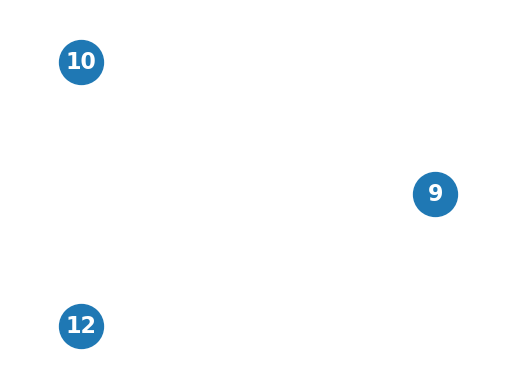

[9, 10, 12]
1/2 [Z9] +
-3/2 [] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.131087, 0.0029858588], [0.5174395, 2.6541762]]] from old_V = [9, 10] and old_E = [] to new subgraph (new_V = [9, 10, 12], new_E = []), initial_expectation_value = 2.9998689670297995
[9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 22.                         |
|Parameter gates        : 12.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[9, 10, 12]
1/2 [Z9] +
-3/2 [] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 2.9998689670297995
weight = [5.1743948e-01 3.1310871e+00 2.6541762e+00 2.9858588e-03]
Convergence reached after 9 iterations, with loss evolution: [-2.9998689, -2.9947822, -2.9996169, -2.9989035, -2.9971755, -2.9981308, -2.9996555, -2.9999135, -2.999095]
Optimized circuit parameters: par

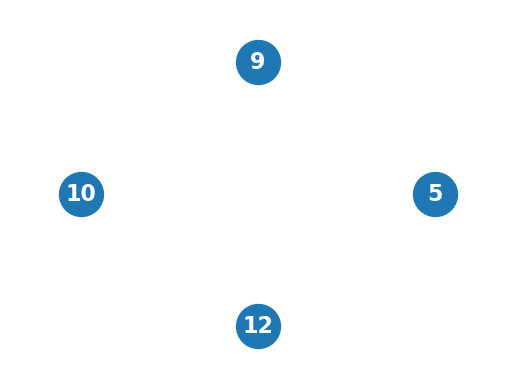

[5, 9, 10, 12]
1/2 [Z5] +
-2 [] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1651323, -0.023764407], [0.5174395, 2.3272617]]] from old_V = [9, 10, 12] and old_E = [] to new subgraph (new_V = [5, 9, 10, 12], new_E = []), initial_expectation_value = 3.9981135890739465
[5, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 28.                         |
|Parameter gates        : 16.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[5, 9, 10, 12]
1/2 [Z5] +
-2 [] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 3.9981135890739465
weight = [ 0.5174395   3.1651323   2.3272617  -0.02376441]
Convergence reached after 3 iterations, with loss evolution: [-3.9981136, -3.9977107, -3.9984999]
Optimized circuit parameters: params = [0.5174395, 3.139377, 2.1781504, 0.002

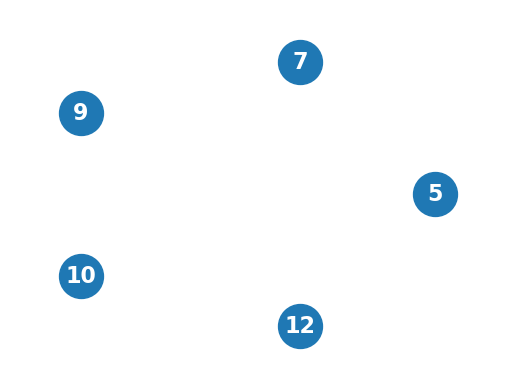

[5, 7, 9, 10, 12]
1/2 [Z5] +
-5/2 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.139377, 0.0021542755], [0.5174395, 2.1781504]]] from old_V = [5, 9, 10, 12] and old_E = [] to new subgraph (new_V = [5, 7, 9, 10, 12], new_E = []), initial_expectation_value = 4.999981253486955
[5, 7, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 34.                         |
|Parameter gates        : 20.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[5, 7, 9, 10, 12]
1/2 [Z5] +
-5/2 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999981253486955
weight = [5.1743948e-01 3.1393771e+00 2.1781504e+00 2.1542755e-03]
Convergence reached after 12 iterations, with loss evolution: [-4.9999814, -4.9912605, -4.9994407, -4.9981823, -4.995182, -4.9963

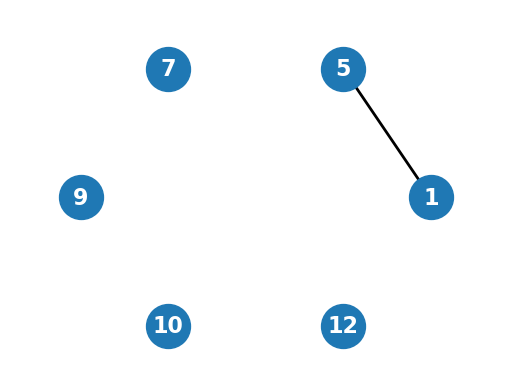

[1, 5, 7, 9, 10, 12]
1/2 [Z1] +
-3 [] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.152352, -0.010759599], [0.5174395, 1.7542711]]] from old_V = [5, 7, 9, 10, 12] and old_E = [] to new subgraph (new_V = [1, 5, 7, 9, 10, 12], new_E = [(1, 5)]), initial_expectation_value = 4.999697659138385
[1, 5, 7, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 48.                         |
|Parameter gates        : 24.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[1, 5, 7, 9, 10, 12]
1/2 [Z1] +
-3 [] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999697659138386
weight = [ 0.5174395  3.152352   1.7542711 -0.0107596]
Convergence reached after 9 iterations, with loss evolution: [-4.9996977, -4.99611, -4.9996157, -4.999

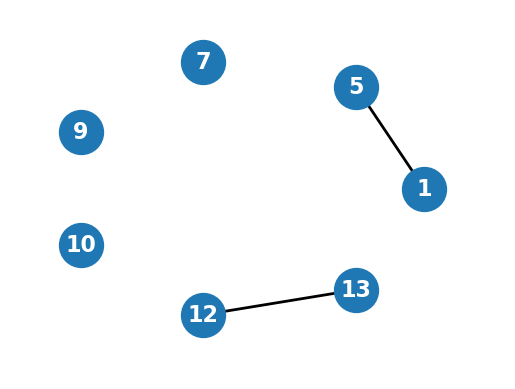

[1, 5, 7, 9, 10, 12, 13]
1/2 [Z1] +
-7/2 [] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.1197894, 0.021585075], [0.5174395, 1.4269754]]] from old_V = [1, 5, 7, 9, 10, 12] and old_E = [(1, 5)] to new subgraph (new_V = [1, 5, 7, 9, 10, 12, 13], new_E = [(1, 5), (12, 13)]), initial_expectation_value = 4.999158015027715
[1, 5, 7, 9, 10, 12, 13]
====================Circuit Summary====================
|Total number of gates  : 62.                         |
|Parameter gates        : 28.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[1, 5, 7, 9, 10, 12, 13]
1/2 [Z1] +
-7/2 [] +
1/2 [Z5] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] +
1/2 [Z13] 
initial_ex = 4.999158015027715
weight = [0.5174395  3.1197894  1.4269754  0.02158508]
Convergence reached after 3 iterations,

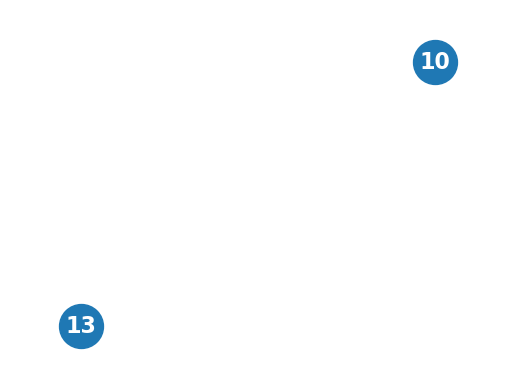

initial_subgraph_V = [10, 13], initial_subgraph_E = []
5-th progressive learning run, SEED = [22803, 16744, 9172, 20663, 12437]



The 1-th global random initialization
SEED = 22803,initial_beta = [1.3928397, 1.0538955],initial_gamma = [2.3408356, 0.37756976]
[10, 13]
====================Circuit Summary====================
|Total number of gates  : 16.                         |
|Parameter gates        : 8.                          |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[10, 13]
1/2 [Z10] +
-1 [] +
1/2 [Z13] 
initial_ex = 1.7078775135243183
weight = [2.3408356  1.3928397  0.37756976 1.0538955 ]
Convergence reached after 25 iterations, with loss evolution: [-1.7078775, -1.7811347, -1.8448557, -1.898014, -1.9398965, -1.9702437, -1.9894031, -1.9984516, -1.999223, -1.9941645, -1.9860005, -1.9772872, -1.9700184, -1.9654198, -1.9639515, -1.965454, -1.9693466,

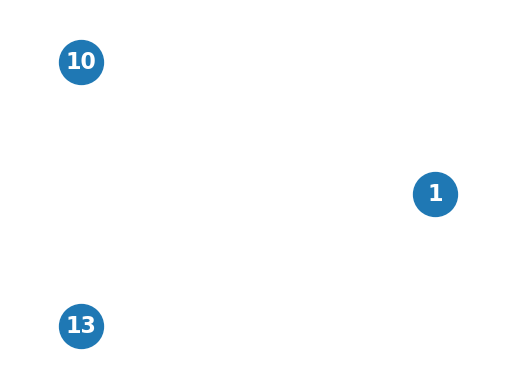

[1, 10, 13]
1/2 [Z1] +
-3/2 [] +
1/2 [Z10] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[-0.45724472, 2.6442924], [0.259089, 3.1674087]]] from old_V = [10, 13] and old_E = [] to new subgraph (new_V = [1, 10, 13], new_E = []), initial_expectation_value = 2.9986915567713113
[1, 10, 13]
====================Circuit Summary====================
|Total number of gates  : 22.                         |
|Parameter gates        : 12.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[1, 10, 13]
1/2 [Z1] +
-3/2 [] +
1/2 [Z10] +
1/2 [Z13] 
initial_ex = 2.9986915567713113
weight = [ 0.259089   -0.45724472  3.1674087   2.6442924 ]
Convergence reached after 7 iterations, with loss evolution: [-2.9986916, -2.9972136, -2.9989805, -2.999922, -2.9988, -2.9988532, -2.9997633]
Optimized circuit parameters: params = [0.259089, -0.48192075, 3.144

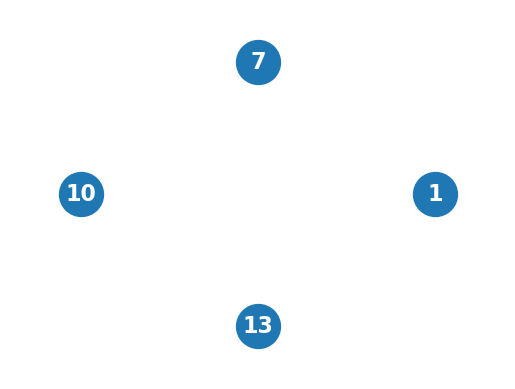

[1, 7, 10, 13]
1/2 [Z1] +
-2 [] +
1/2 [Z7] +
1/2 [Z10] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[-0.48192075, 2.670188], [0.259089, 3.1443658]]] from old_V = [1, 10, 13] and old_E = [] to new subgraph (new_V = [1, 7, 10, 13], new_E = []), initial_expectation_value = 3.9998877951212535
[1, 7, 10, 13]
====================Circuit Summary====================
|Total number of gates  : 28.                         |
|Parameter gates        : 16.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[1, 7, 10, 13]
1/2 [Z1] +
-2 [] +
1/2 [Z7] +
1/2 [Z10] +
1/2 [Z13] 
initial_ex = 3.9998877951212535
weight = [ 0.259089   -0.48192075  3.1443658   2.670188  ]
Convergence reached after 11 iterations, with loss evolution: [-3.9998877, -3.9915335, -3.9994214, -3.998123, -3.9952476, -3.996829, -3.9994018, -3.9998534, -3.998421, -3.9975345

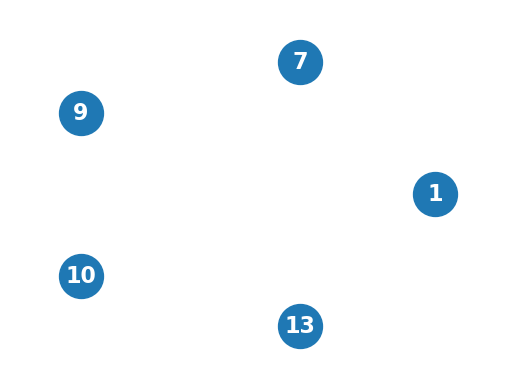

[1, 7, 9, 10, 13]
1/2 [Z1] +
-5/2 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[-0.46488565, 2.6553483], [0.259089, 3.127179]]] from old_V = [1, 7, 10, 13] and old_E = [] to new subgraph (new_V = [1, 7, 9, 10, 13], new_E = []), initial_expectation_value = 4.999375372798018
[1, 7, 9, 10, 13]
====================Circuit Summary====================
|Total number of gates  : 34.                         |
|Parameter gates        : 20.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[1, 7, 9, 10, 13]
1/2 [Z1] +
-5/2 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z13] 
initial_ex = 4.999375372798018
weight = [ 0.259089   -0.46488565  3.127179    2.6553483 ]
Convergence reached after 13 iterations, with loss evolution: [-4.9993753, -4.9919443, -4.9992056, -4.9985027, -4.995789, -4.9974236, -4.99

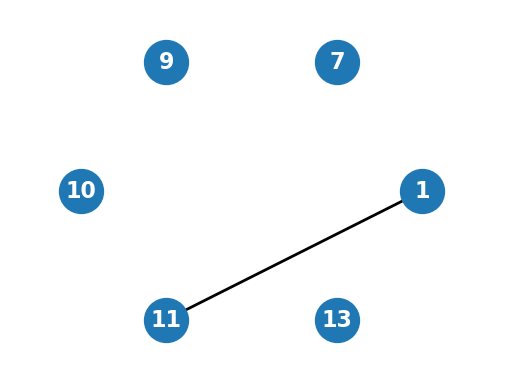

[1, 7, 9, 10, 11, 13]
1/2 [Z1] +
-3 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[-0.46019253, 2.6524513], [0.259089, 3.12746]]] from old_V = [1, 7, 9, 10, 13] and old_E = [] to new subgraph (new_V = [1, 7, 9, 10, 11, 13], new_E = [(1, 11)]), initial_expectation_value = 4.953555630827563
[1, 7, 9, 10, 11, 13]
====================Circuit Summary====================
|Total number of gates  : 48.                         |
|Parameter gates        : 24.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[1, 7, 9, 10, 11, 13]
1/2 [Z1] +
-3 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.953555630827563
weight = [ 0.259089   -0.46019253  3.12746     2.6524513 ]
Convergence reached after 17 iterations, with loss evolution: [-4.9535556, -4.951963, -4.95784

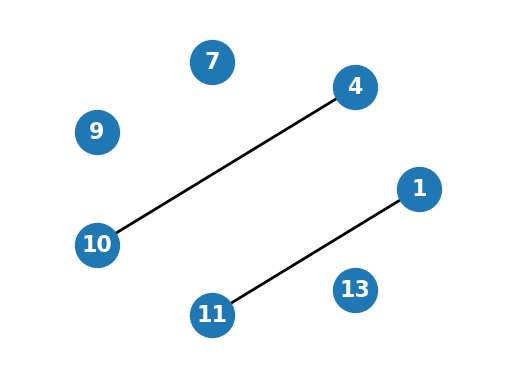

[1, 4, 7, 9, 10, 11, 13]
1/2 [Z1] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[0.0048058894, 3.1618884], [0.259089, 3.1722317]]] from old_V = [1, 7, 9, 10, 11, 13] and old_E = [(1, 11)] to new subgraph (new_V = [1, 4, 7, 9, 10, 11, 13], new_E = [(1, 11), (4, 10)]), initial_expectation_value = 4.9998076698229434
[1, 4, 7, 9, 10, 11, 13]
====================Circuit Summary====================
|Total number of gates  : 62.                         |
|Parameter gates        : 28.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[1, 4, 7, 9, 10, 11, 13]
1/2 [Z1] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.9998076698229434
weight = [0.259089   0.00480589 3.1722317  3.1618884 ]
Convergence reached after 11 iterat

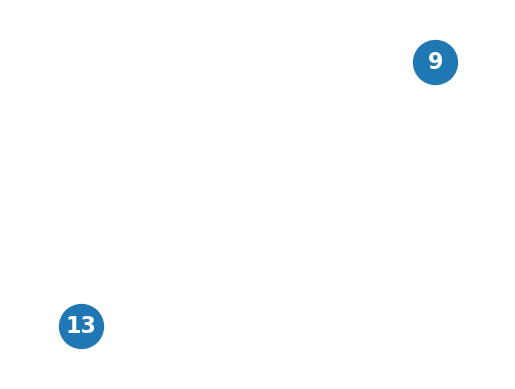

initial_subgraph_V = [9, 13], initial_subgraph_E = []
6-th progressive learning run, SEED = [11754, 20369, 3351, 12068, 4873]



The 1-th global random initialization
SEED = 11754,initial_beta = [1.2891475, 1.7900914],initial_gamma = [2.3234031, 1.1632044]
[9, 13]
====================Circuit Summary====================
|Total number of gates  : 16.                         |
|Parameter gates        : 8.                          |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[9, 13]
1/2 [Z9] +
-1 [] +
1/2 [Z13] 
initial_ex = 1.432125089090881
weight = [2.3234031 1.2891475 1.1632044 1.7900914]
Convergence reached after 26 iterations, with loss evolution: [-1.4321251, -1.4892867, -1.5451701, -1.5990587, -1.650311, -1.6983724, -1.7427908, -1.7832315, -1.8194865, -1.8514806, -1.8792686, -1.9030234, -1.9230161, -1.9395888, -1.9531249, -1.9640211, -1.9726651, -1.97942

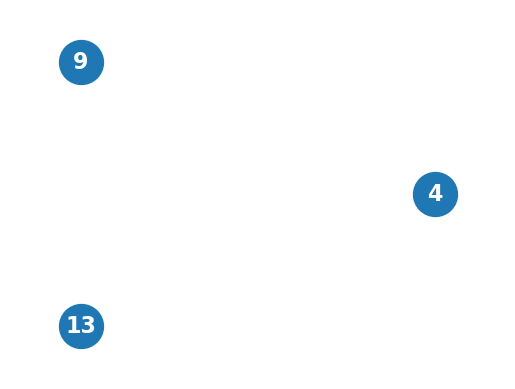

[4, 9, 13]
1/2 [Z4] +
-3/2 [] +
1/2 [Z9] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[2.2247195, 0.8741441], [0.15485023, 0.024523405]]] from old_V = [9, 13] and old_E = [] to new subgraph (new_V = [4, 9, 13], new_E = []), initial_expectation_value = 2.998356310362651
[4, 9, 13]
====================Circuit Summary====================
|Total number of gates  : 22.                         |
|Parameter gates        : 12.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[4, 9, 13]
1/2 [Z4] +
-3/2 [] +
1/2 [Z9] +
1/2 [Z13] 
initial_ex = 2.998356310362651
weight = [0.15485023 2.2247195  0.02452341 0.8741441 ]
Convergence reached after 7 iterations, with loss evolution: [-2.9983563, -2.9972446, -2.9987159, -2.9999738, -2.9988801, -2.9987214, -2.9996595]
Optimized circuit parameters: params = [0.15485023, 2.2506037, 0.0005977604

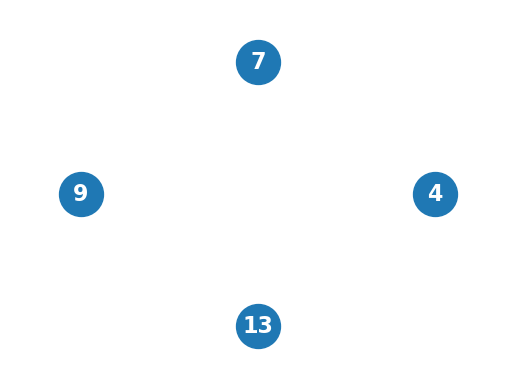

[4, 7, 9, 13]
1/2 [Z4] +
-2 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[2.2506037, 0.89860374], [0.15485023, 0.00059776043]]] from old_V = [4, 9, 13] and old_E = [] to new subgraph (new_V = [4, 7, 9, 13], new_E = []), initial_expectation_value = 3.9999417982839844
[4, 7, 9, 13]
====================Circuit Summary====================
|Total number of gates  : 28.                         |
|Parameter gates        : 16.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[4, 7, 9, 13]
1/2 [Z4] +
-2 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z13] 
initial_ex = 3.9999417982839844
weight = [1.5485023e-01 2.2506037e+00 5.9776043e-04 8.9860374e-01]
Convergence reached after 14 iterations, with loss evolution: [-3.9999418, -3.989993, -3.9993403, -3.9977856, -3.9943116, -3.9960258, -3.9991062, -3.9999084, -3.9983702, -

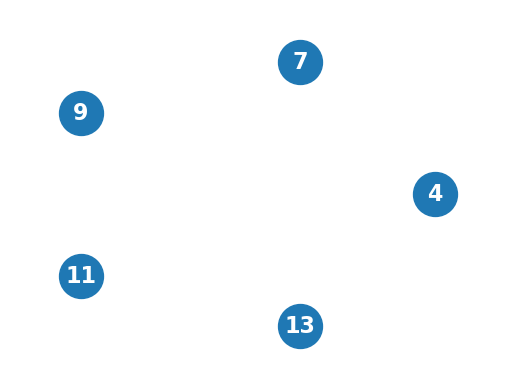

[4, 7, 9, 11, 13]
1/2 [Z4] +
-5/2 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[2.2654896, 0.9099609], [0.15485023, 0.015002327]]] from old_V = [4, 7, 9, 13] and old_E = [] to new subgraph (new_V = [4, 7, 9, 11, 13], new_E = []), initial_expectation_value = 4.998396561463154
[4, 7, 9, 11, 13]
====================Circuit Summary====================
|Total number of gates  : 34.                         |
|Parameter gates        : 20.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[4, 7, 9, 11, 13]
1/2 [Z4] +
-5/2 [] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.998396561463153
weight = [0.15485023 2.2654896  0.01500233 0.9099609 ]
Convergence reached after 13 iterations, with loss evolution: [-4.9983964, -4.9936066, -4.9986925, -4.999419, -4.9969783, -4.99787, -4.999759

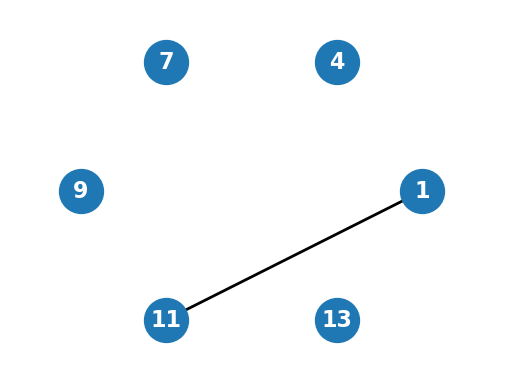

[1, 4, 7, 9, 11, 13]
1/2 [Z1] +
-3 [] +
1/2 [Z4] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[2.2632122, 0.90515226], [0.15485023, 0.01397795]]] from old_V = [4, 7, 9, 11, 13] and old_E = [] to new subgraph (new_V = [1, 4, 7, 9, 11, 13], new_E = [(1, 11)]), initial_expectation_value = 4.8562666407509
[1, 4, 7, 9, 11, 13]
====================Circuit Summary====================
|Total number of gates  : 48.                         |
|Parameter gates        : 24.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[1, 4, 7, 9, 11, 13]
1/2 [Z1] +
-3 [] +
1/2 [Z4] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.8562666407509
weight = [0.15485023 2.2632122  0.01397795 0.90515226]
Convergence reached after 38 iterations, with loss evolution: [-4.8562665, -4.879883, -4.884978, -4.8811

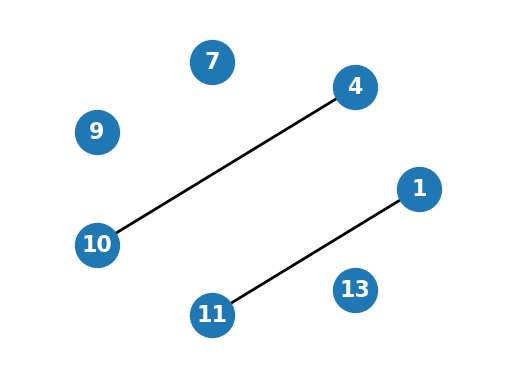

[1, 4, 7, 9, 10, 11, 13]
1/2 [Z1] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z11] +
1/2 [Z13] 
Transferring optimized parameters params_opt = [[[3.104921, 0.027163798], [0.15485023, 0.013473598]]] from old_V = [1, 4, 7, 9, 11, 13] and old_E = [(1, 11)] to new subgraph (new_V = [1, 4, 7, 9, 10, 11, 13], new_E = [(1, 11), (4, 10)]), initial_expectation_value = 4.9995680609751725
[1, 4, 7, 9, 10, 11, 13]
====================Circuit Summary====================
|Total number of gates  : 62.                         |
|Parameter gates        : 28.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 14                          |
None
[1, 4, 7, 9, 10, 11, 13]
1/2 [Z1] +
-7/2 [] +
1/2 [Z4] +
1/2 [Z7] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z11] +
1/2 [Z13] 
initial_ex = 4.9995680609751725
weight = [0.15485023 3.104921   0.0134736  0.0271638 ]
Convergence reached after 6 iterat

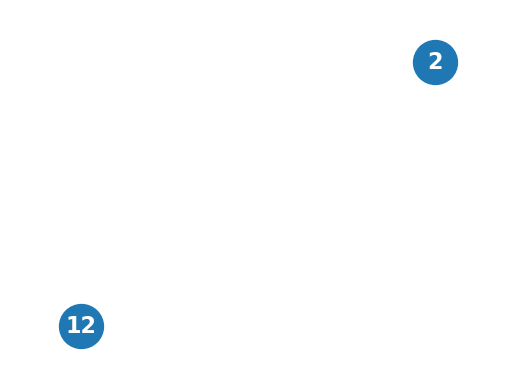

initial_subgraph_V = [2, 12], initial_subgraph_E = []
7-th progressive learning run, SEED = [16787, 6597, 9918, 4450, 19328]



The 1-th global random initialization
SEED = 16787,initial_beta = [1.652144, 0.18595886],initial_gamma = [2.7537825, 0.5341567]
[2, 12]
====================Circuit Summary====================
|Total number of gates  : 16.                         |
|Parameter gates        : 8.                          |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[2, 12]
1/2 [Z2] +
-1 [] +
1/2 [Z12] 
initial_ex = 1.2384643684304697
weight = [2.7537825  1.652144   0.5341567  0.18595886]
Convergence reached after 37 iterations, with loss evolution: [-1.2384644, -1.3324659, -1.4246999, -1.5137855, -1.5983461, -1.6770445, -1.7486315, -1.812007, -1.8662907, -1.9109012, -1.9456342, -1.9707261, -1.9868804, -1.9952326, -1.9972438, -1.9945428, -1.9887586, -1.9

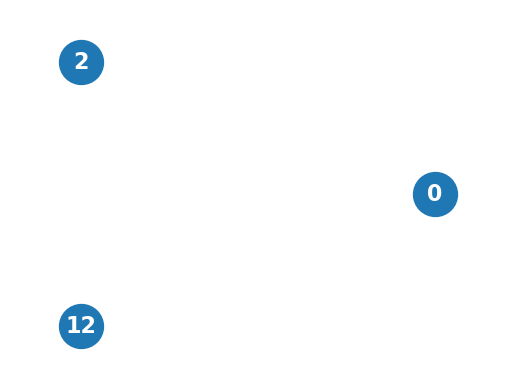

[0, 2, 12]
1/2 [Z0] +
-3/2 [] +
1/2 [Z2] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[0.013497528, 3.1004455], [1.7898633, 2.2038984]]] from old_V = [2, 12] and old_E = [] to new subgraph (new_V = [0, 2, 12], new_E = []), initial_expectation_value = 2.9981011090233523
[0, 2, 12]
====================Circuit Summary====================
|Total number of gates  : 22.                         |
|Parameter gates        : 12.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 2, 12]
1/2 [Z0] +
-3/2 [] +
1/2 [Z2] +
1/2 [Z12] 
initial_ex = 2.9981011090233523
weight = [1.7898633  0.01349753 2.2038984  3.1004455 ]
Convergence reached after 3 iterations, with loss evolution: [-2.998101, -2.9986753, -2.9985285]
Optimized circuit parameters: params = [1.7898633, -0.00967849, 2.0572538, 3.1502721]
new_V = [0, 2, 12], new_E = [], loss 

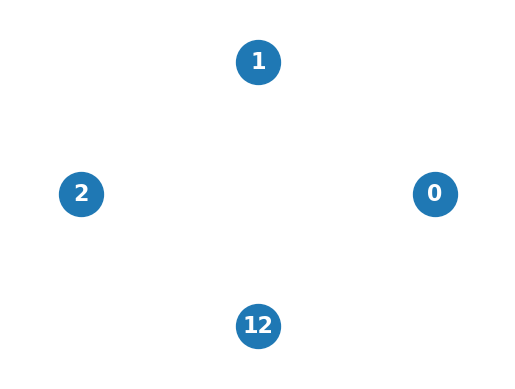

[0, 1, 2, 12]
1/2 [Z0] +
-2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[-0.00967849, 3.1502721], [1.7898633, 2.0572538]]] from old_V = [0, 2, 12] and old_E = [] to new subgraph (new_V = [0, 1, 2, 12], new_E = []), initial_expectation_value = 3.9997524569320513
[0, 1, 2, 12]
====================Circuit Summary====================
|Total number of gates  : 28.                         |
|Parameter gates        : 16.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 2, 12]
1/2 [Z0] +
-2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z12] 
initial_ex = 3.9997524569320513
weight = [ 1.7898633  -0.00967849  2.0572538   3.1502721 ]
Convergence reached after 9 iterations, with loss evolution: [-3.9997525, -3.9952607, -3.9995902, -3.999133, -3.997586, -3.9983873, -3.9997056, -3.9999278, -3.999247]
Optimized circui

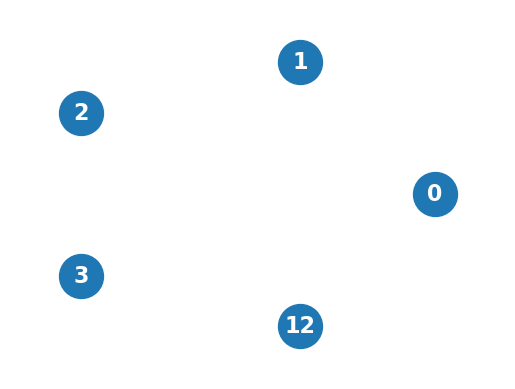

[0, 1, 2, 3, 12]
1/2 [Z0] +
-5/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[0.022693578, 3.119222], [1.7898633, 1.7309024]]] from old_V = [0, 1, 2, 12] and old_E = [] to new subgraph (new_V = [0, 1, 2, 3, 12], new_E = []), initial_expectation_value = 4.998528602708579
[0, 1, 2, 3, 12]
====================Circuit Summary====================
|Total number of gates  : 34.                         |
|Parameter gates        : 20.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 2, 3, 12]
1/2 [Z0] +
-5/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z12] 
initial_ex = 4.998528602708579
weight = [1.7898633  0.02269358 1.7309024  3.119222  ]
Convergence reached after 3 iterations, with loss evolution: [-4.9985285, -4.997907, -4.9988303]
Optimized circuit parameters: params = [1.7898633, -

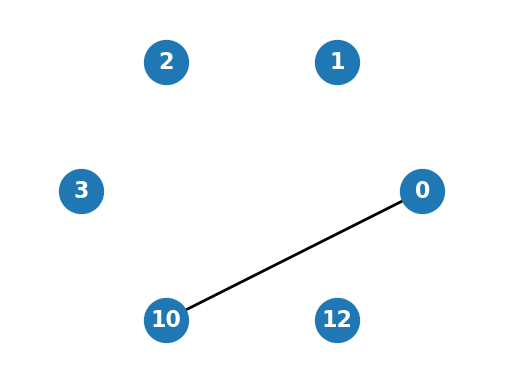

[0, 1, 2, 3, 10, 12]
1/2 [Z0] +
-3 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[-0.0013364254, 3.1425228], [1.7898633, 1.5829428]]] from old_V = [0, 1, 2, 3, 12] and old_E = [] to new subgraph (new_V = [0, 1, 2, 3, 10, 12], new_E = [(0, 10)]), initial_expectation_value = 4.999996872486938
[0, 1, 2, 3, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 48.                         |
|Parameter gates        : 24.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 2, 3, 10, 12]
1/2 [Z0] +
-3 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999996872486938
weight = [ 1.7898633e+00 -1.3364254e-03  1.5829428e+00  3.1425228e+00]
Convergence reached after 9 iterations, with loss evolution: [-4.9999967, -4.994763,

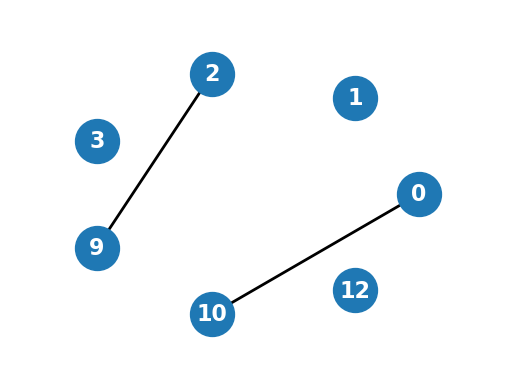

[0, 1, 2, 3, 9, 10, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[0.024157591, 3.11729], [1.7898633, 1.2657717]]] from old_V = [0, 1, 2, 3, 10, 12] and old_E = [(0, 10)] to new subgraph (new_V = [0, 1, 2, 3, 9, 10, 12], new_E = [(0, 10), (2, 9)]), initial_expectation_value = 4.9990872328435305
[0, 1, 2, 3, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 62.                         |
|Parameter gates        : 28.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 2, 3, 9, 10, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.9990872328435305
weight = [1.7898633  0.02415759 1.2657717  3.11729   ]
Convergence reached after 3 iterations, with 

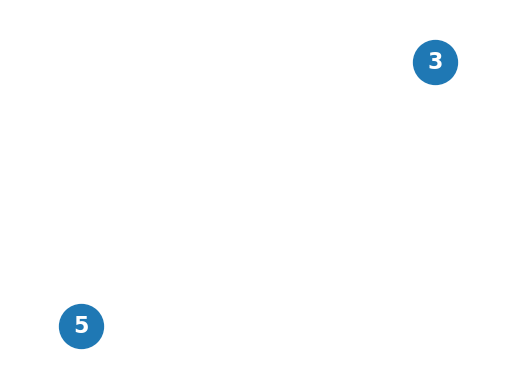

initial_subgraph_V = [3, 5], initial_subgraph_E = []
8-th progressive learning run, SEED = [23771, 23475, 13950, 19993, 20740]



The 1-th global random initialization
SEED = 23771,initial_beta = [2.387795, 2.760229],initial_gamma = [2.7082882, 0.6680213]
[3, 5]
====================Circuit Summary====================
|Total number of gates  : 16.                         |
|Parameter gates        : 8.                          |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 6                           |
None
[3, 5]
1/2 [Z3] +
-1 [] +
1/2 [Z5] 
initial_ex = 0.5232594307642019
weight = [2.7082882 2.387795  0.6680213 2.760229 ]
Convergence reached after 48 iterations, with loss evolution: [-0.5232594, -0.614947, -0.7118445, -0.8129386, -0.91708976, -1.0230362, -1.1294065, -1.2347397, -1.3375145, -1.4361914, -1.5292678, -1.6153458, -1.6932145, -1.761937, -1.8209319, -1.8700299, -1.9094802, -1.9398948,

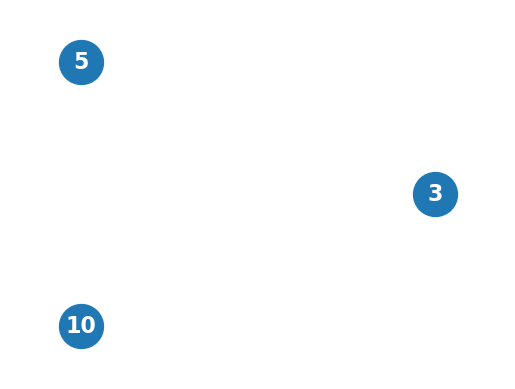

[3, 5, 10]
1/2 [Z3] +
-3/2 [] +
1/2 [Z5] +
1/2 [Z10] 
Transferring optimized parameters params_opt = [[[1.4011657, 1.7734418], [2.7082882, -0.020100672]]] from old_V = [3, 5] and old_E = [] to new subgraph (new_V = [3, 5, 10], new_E = []), initial_expectation_value = 2.998890031507789
[3, 5, 10]
====================Circuit Summary====================
|Total number of gates  : 22.                         |
|Parameter gates        : 12.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 11                          |
None
[3, 5, 10]
1/2 [Z3] +
-3/2 [] +
1/2 [Z5] +
1/2 [Z10] 
initial_ex = 2.998890031507789
weight = [ 2.7082882   1.4011657  -0.02010067  1.7734418 ]
Convergence reached after 9 iterations, with loss evolution: [-2.99889, -2.9959893, -2.9991035, -2.9996674, -2.9981244, -2.9986265, -2.9998279, -2.999793, -2.9990237]
Optimized circuit parameters: params = [2.7082882, 

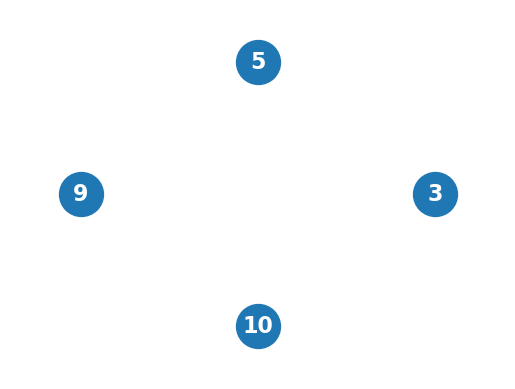

[3, 5, 9, 10]
1/2 [Z3] +
-2 [] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] 
Transferring optimized parameters params_opt = [[[1.3678372, 1.7407181], [2.7082882, 0.015481823]]] from old_V = [3, 5, 10] and old_E = [] to new subgraph (new_V = [3, 5, 9, 10], new_E = []), initial_expectation_value = 3.9986772522660687
[3, 5, 9, 10]
====================Circuit Summary====================
|Total number of gates  : 28.                         |
|Parameter gates        : 16.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 11                          |
None
[3, 5, 9, 10]
1/2 [Z3] +
-2 [] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] 
initial_ex = 3.9986772522660687
weight = [2.7082882  1.3678372  0.01548182 1.7407181 ]
Convergence reached after 11 iterations, with loss evolution: [-3.9986773, -3.9943686, -3.9989097, -3.99945, -3.9973202, -3.99815, -3.9997997, -3.999683, -3.9986165, -3.998629, -3.9995492

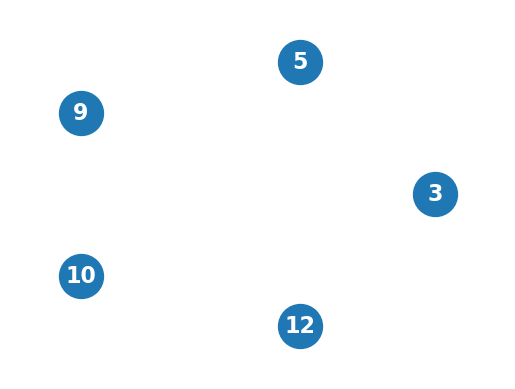

[3, 5, 9, 10, 12]
1/2 [Z3] +
-5/2 [] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[1.3832054, 1.7568878], [2.7082882, 0.00048192218]]] from old_V = [3, 5, 9, 10] and old_E = [] to new subgraph (new_V = [3, 5, 9, 10, 12], new_E = []), initial_expectation_value = 4.999996909282987
[3, 5, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 34.                         |
|Parameter gates        : 20.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[3, 5, 9, 10, 12]
1/2 [Z3] +
-5/2 [] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999996909282988
weight = [2.7082882e+00 1.3832054e+00 4.8192218e-04 1.7568878e+00]
Convergence reached after 17 iterations, with loss evolution: [-4.999997, -4.9849343, -4.9990196, -4.996761, -4.9913373, -4.9935

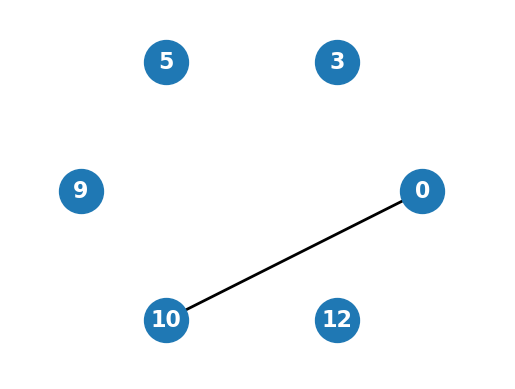

[0, 3, 5, 9, 10, 12]
1/2 [Z0] +
-3 [] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[1.3715311, 1.7466751], [2.7082882, 0.012107502]]] from old_V = [3, 5, 9, 10, 12] and old_E = [] to new subgraph (new_V = [0, 3, 5, 9, 10, 12], new_E = [(0, 10)]), initial_expectation_value = 4.80540657103378
[0, 3, 5, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 48.                         |
|Parameter gates        : 24.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 3, 5, 9, 10, 12]
1/2 [Z0] +
-3 [] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.805406571033781
weight = [2.7082882 1.3715311 0.0121075 1.7466751]
Convergence reached after 12 iterations, with loss evolution: [-4.8054066, -4.826822, -4.8305764, -4.82361

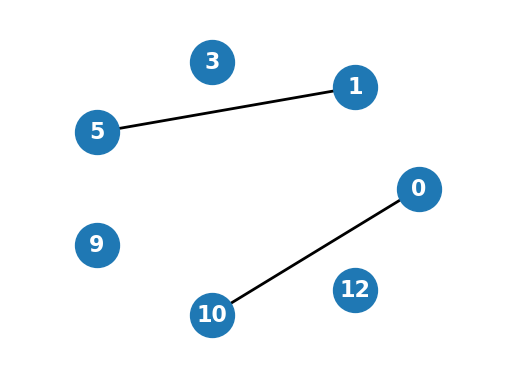

[0, 1, 3, 5, 9, 10, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[1.2515012, 1.7646724], [2.7082882, 0.008064352]]] from old_V = [0, 3, 5, 9, 10, 12] and old_E = [(0, 10)] to new subgraph (new_V = [0, 1, 3, 5, 9, 10, 12], new_E = [(0, 10), (1, 5)]), initial_expectation_value = 4.685859025658078
[0, 1, 3, 5, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 62.                         |
|Parameter gates        : 28.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 3, 5, 9, 10, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.685859025658077
weight = [2.7082882  1.2515012  0.00806435 1.7646724 ]
train_step = 50, loss = -4.938290119171143
Co

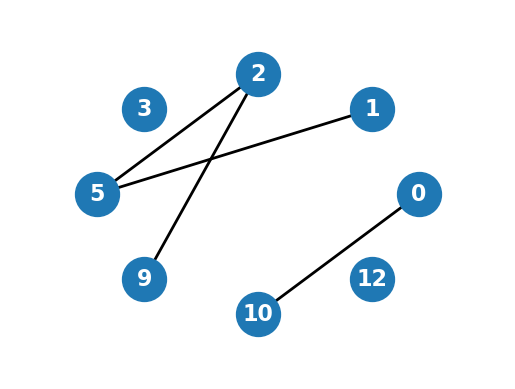

[0, 1, 2, 3, 5, 9, 10, 12]
1/2 [Z0] +
-4 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[-0.017008215, 3.1689317], [2.7082882, 0.0051611317]]] from old_V = [0, 1, 3, 5, 9, 10, 12] and old_E = [(0, 10), (1, 5)] to new subgraph (new_V = [0, 1, 2, 3, 5, 9, 10, 12], new_E = [(0, 10), (1, 5), (2, 9), (2, 5)]), initial_expectation_value = 4.99970065988263
[0, 1, 2, 3, 5, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 84.                         |
|Parameter gates        : 32.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 2, 3, 5, 9, 10, 12]
1/2 [Z0] +
-4 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999700659882631
weight = [ 2.7082882  -0.01700822  0.005

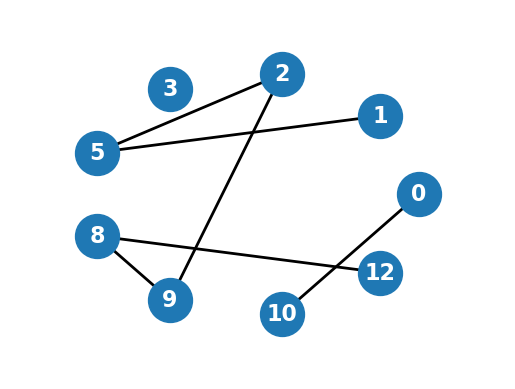

[0, 1, 2, 3, 5, 8, 9, 10, 12]
1/2 [Z0] +
-9/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z8] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[0.018660748, 3.1479404], [2.7082882, 0.012820164]]] from old_V = [0, 1, 2, 3, 5, 9, 10, 12] and old_E = [(0, 10), (1, 5), (2, 9), (2, 5)] to new subgraph (new_V = [0, 1, 2, 3, 5, 8, 9, 10, 12], new_E = [(0, 10), (1, 5), (2, 9), (2, 5), (8, 9), (8, 12)]), initial_expectation_value = 4.999097336560321
[0, 1, 2, 3, 5, 8, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 106.                        |
|Parameter gates        : 36.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 2, 3, 5, 8, 9, 10, 12]
1/2 [Z0] +
-9/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z8] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12]

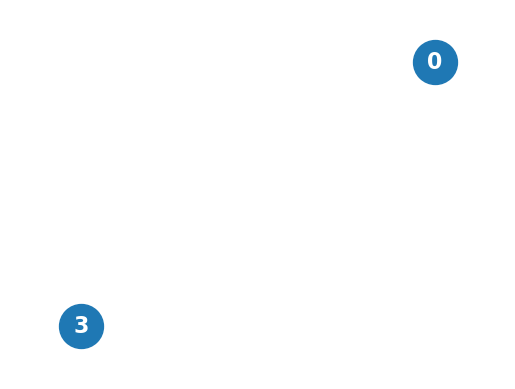

initial_subgraph_V = [0, 3], initial_subgraph_E = []
9-th progressive learning run, SEED = [18925, 9175, 13428, 13009, 14914]



The 1-th global random initialization
SEED = 18925,initial_beta = [1.4000514, 2.6446505],initial_gamma = [2.5550597, 2.431851]
[0, 3]
====================Circuit Summary====================
|Total number of gates  : 16.                         |
|Parameter gates        : 8.                          |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 4                           |
None
[0, 3]
1/2 [Z0] +
-1 [] +
1/2 [Z3] 
initial_ex = 0.7930011711693727
weight = [2.5550597 1.4000514 2.431851  2.6446505]
Convergence reached after 45 iterations, with loss evolution: [-0.7930012, -0.8916944, -0.98972875, -1.0858341, -1.1787912, -1.2674665, -1.3508545, -1.4281226, -1.4986542, -1.5620863, -1.6183314, -1.6675757, -1.710249, -1.7469649, -1.7784438, -1.8054317, -1.8286333, -1.8486687

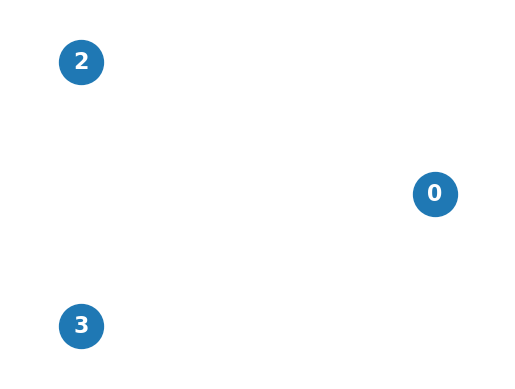

[0, 2, 3]
1/2 [Z0] +
-3/2 [] +
1/2 [Z2] +
1/2 [Z3] 
Transferring optimized parameters params_opt = [[[-0.009985078, 3.1437492], [2.5550597, 2.2559736]]] from old_V = [0, 3] and old_E = [] to new subgraph (new_V = [0, 2, 3], new_E = []), initial_expectation_value = 2.9999012965974625
[0, 2, 3]
====================Circuit Summary====================
|Total number of gates  : 22.                         |
|Parameter gates        : 12.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 4                           |
None
[0, 2, 3]
1/2 [Z0] +
-3/2 [] +
1/2 [Z2] +
1/2 [Z3] 
initial_ex = 2.9999012965974625
weight = [ 2.5550597  -0.00998508  2.2559736   3.1437492 ]
Convergence reached after 9 iterations, with loss evolution: [-2.9999013, -2.9953804, -2.9996667, -2.99905, -2.9975295, -2.9983056, -2.9996343, -2.9999566, -2.9993265]
Optimized circuit parameters: params = [2.5550597, 0.0

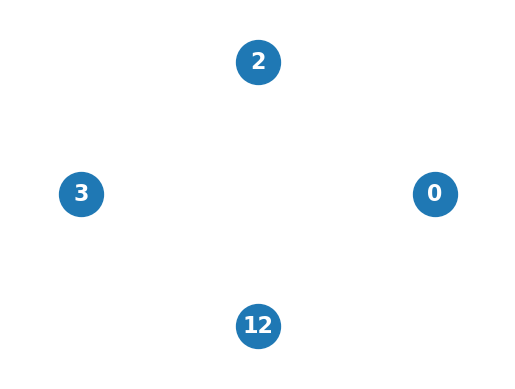

[0, 2, 3, 12]
1/2 [Z0] +
-2 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[0.026532246, 3.1199877], [2.5550597, 1.9331186]]] from old_V = [0, 2, 3] and old_E = [] to new subgraph (new_V = [0, 2, 3, 12], new_E = []), initial_expectation_value = 3.998423213081216
[0, 2, 3, 12]
====================Circuit Summary====================
|Total number of gates  : 28.                         |
|Parameter gates        : 16.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 2, 3, 12]
1/2 [Z0] +
-2 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z12] 
initial_ex = 3.998423213081216
weight = [2.5550597  0.02653225 1.9331186  3.1199877 ]
Convergence reached after 3 iterations, with loss evolution: [-3.998423, -3.9982338, -3.9987438]
Optimized circuit parameters: params = [2.5550597, -0.0051732766, 1.7836164, 3.1435387]
new_V

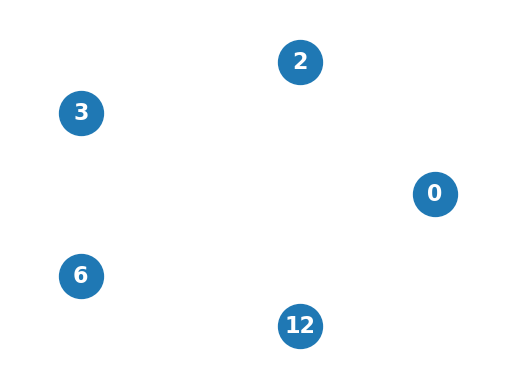

[0, 2, 3, 6, 12]
1/2 [Z0] +
-5/2 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z6] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[-0.0051732766, 3.1435387], [2.5550597, 1.7836164]]] from old_V = [0, 2, 3, 12] and old_E = [] to new subgraph (new_V = [0, 2, 3, 6, 12], new_E = []), initial_expectation_value = 4.999956496664886
[0, 2, 3, 6, 12]
====================Circuit Summary====================
|Total number of gates  : 34.                         |
|Parameter gates        : 20.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 2, 3, 6, 12]
1/2 [Z0] +
-5/2 [] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z6] +
1/2 [Z12] 
initial_ex = 4.999956496664886
weight = [ 2.5550597  -0.00517328  1.7836164   3.1435387 ]
Convergence reached after 9 iterations, with loss evolution: [-4.9999566, -4.9937305, -4.9995904, -4.998735, -4.996645, -4.997508, -4.9992795,

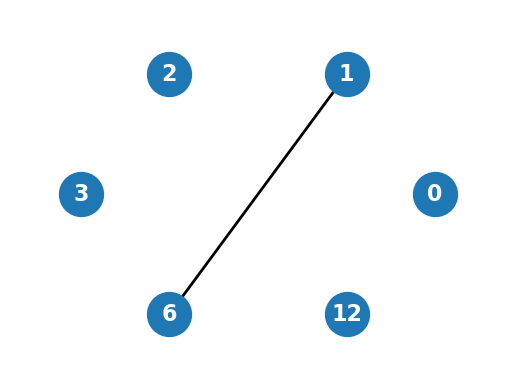

[0, 1, 2, 3, 6, 12]
1/2 [Z0] +
-3 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z6] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[0.024390323, 3.1169558], [2.5550597, 1.4618146]]] from old_V = [0, 2, 3, 6, 12] and old_E = [] to new subgraph (new_V = [0, 1, 2, 3, 6, 12], new_E = [(1, 6)]), initial_expectation_value = 4.998777094412096
[0, 1, 2, 3, 6, 12]
====================Circuit Summary====================
|Total number of gates  : 48.                         |
|Parameter gates        : 24.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 2, 3, 6, 12]
1/2 [Z0] +
-3 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z6] +
1/2 [Z12] 
initial_ex = 4.998777094412096
weight = [2.5550597  0.02439032 1.4618146  3.1169558 ]
Convergence reached after 3 iterations, with loss evolution: [-4.998777, -4.9987464, -4.999005]
Optimized cir

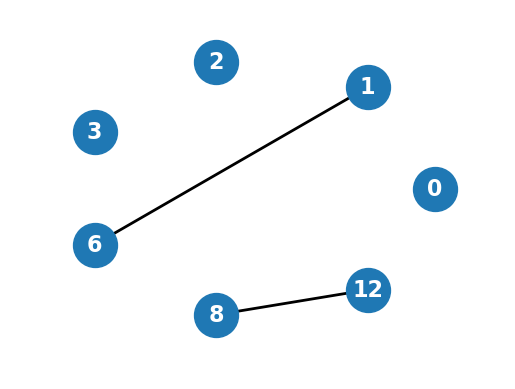

[0, 1, 2, 3, 6, 8, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z6] +
1/2 [Z8] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[-0.004878335, 3.1473708], [2.5550597, 1.3121314]]] from old_V = [0, 1, 2, 3, 6, 12] and old_E = [(1, 6)] to new subgraph (new_V = [0, 1, 2, 3, 6, 8, 12], new_E = [(1, 6), (8, 12)]), initial_expectation_value = 4.999956075426293
[0, 1, 2, 3, 6, 8, 12]
====================Circuit Summary====================
|Total number of gates  : 62.                         |
|Parameter gates        : 28.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 2, 3, 6, 8, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z2] +
1/2 [Z3] +
1/2 [Z6] +
1/2 [Z8] +
1/2 [Z12] 
initial_ex = 4.999956075426293
weight = [ 2.5550597  -0.00487834  1.3121314   3.1473708 ]
Convergence reached after 7 iterations, with los

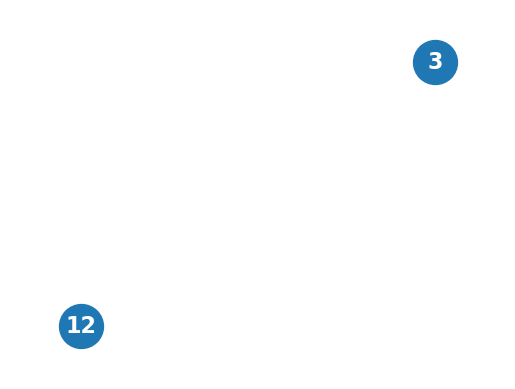

initial_subgraph_V = [3, 12], initial_subgraph_E = []
10-th progressive learning run, SEED = [21377, 19932, 2453, 20451, 16350]



The 1-th global random initialization
SEED = 21377,initial_beta = [2.1438928, 1.600452],initial_gamma = [1.0575871, 2.3407578]
[3, 12]
====================Circuit Summary====================
|Total number of gates  : 16.                         |
|Parameter gates        : 8.                          |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[3, 12]
1/2 [Z3] +
-1 [] +
1/2 [Z12] 
initial_ex = 0.3992914562637607
weight = [1.0575871 2.1438928 2.3407578 1.600452 ]
Convergence reached after 38 iterations, with loss evolution: [-0.39929146, -0.47653532, -0.5595756, -0.64728737, -0.7384998, -0.8320002, -0.9265483, -1.0208966, -1.1138157, -1.2041264, -1.2907364, -1.3726764, -1.4491371, -1.5195016, -1.5833689, -1.6405675, -1.6911534, -1

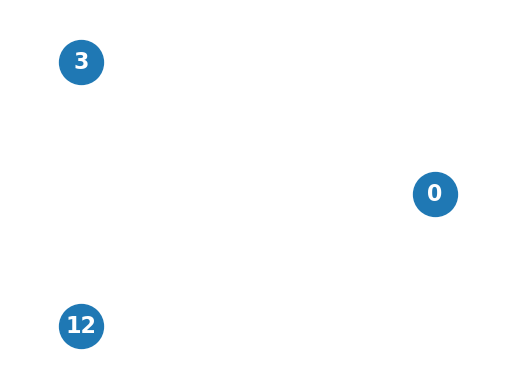

[0, 3, 12]
1/2 [Z0] +
-3/2 [] +
1/2 [Z3] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.173072, -0.061149377], [1.0575871, 1.1868575]]] from old_V = [3, 12] and old_E = [] to new subgraph (new_V = [0, 3, 12], new_E = []), initial_expectation_value = 2.9975353780370897
[0, 3, 12]
====================Circuit Summary====================
|Total number of gates  : 22.                         |
|Parameter gates        : 12.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 3, 12]
1/2 [Z0] +
-3/2 [] +
1/2 [Z3] +
1/2 [Z12] 
initial_ex = 2.99753537803709
weight = [ 1.0575871   3.173072    1.1868575  -0.06114938]
Convergence reached after 4 iterations, with loss evolution: [-2.9975355, -2.9995193, -2.999034, -2.9985673]
Optimized circuit parameters: params = [1.0575871, 3.1212192, 1.0702235, 0.03497459]
new_V = [0, 3, 12], new_

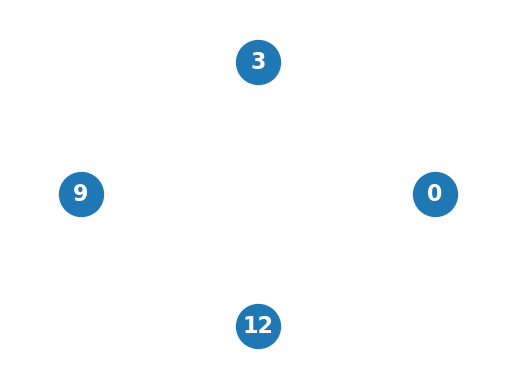

[0, 3, 9, 12]
1/2 [Z0] +
-2 [] +
1/2 [Z3] +
1/2 [Z9] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1212192, 0.03497459], [1.0575871, 1.0702235]]] from old_V = [0, 3, 12] and old_E = [] to new subgraph (new_V = [0, 3, 9, 12], new_E = []), initial_expectation_value = 3.9990458550309254
[0, 3, 9, 12]
====================Circuit Summary====================
|Total number of gates  : 28.                         |
|Parameter gates        : 16.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 3, 9, 12]
1/2 [Z0] +
-2 [] +
1/2 [Z3] +
1/2 [Z9] +
1/2 [Z12] 
initial_ex = 3.9990458550309254
weight = [1.0575871  3.1212192  1.0702235  0.03497459]
Convergence reached after 6 iterations, with loss evolution: [-3.9990458, -3.9993625, -3.997483, -3.9992142, -3.9995263, -3.9989986]
Optimized circuit parameters: params = [1.0575871, 3.15

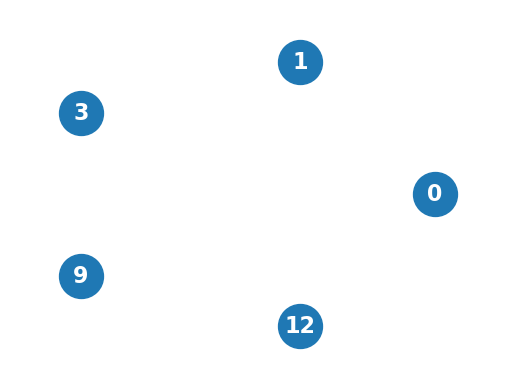

[0, 1, 3, 9, 12]
1/2 [Z0] +
-5/2 [] +
1/2 [Z1] +
1/2 [Z3] +
1/2 [Z9] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.150225, 0.013619787], [1.0575871, 0.8443874]]] from old_V = [0, 3, 9, 12] and old_E = [] to new subgraph (new_V = [0, 1, 3, 9, 12], new_E = []), initial_expectation_value = 4.999479781559631
[0, 1, 3, 9, 12]
====================Circuit Summary====================
|Total number of gates  : 34.                         |
|Parameter gates        : 20.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 3, 9, 12]
1/2 [Z0] +
-5/2 [] +
1/2 [Z1] +
1/2 [Z3] +
1/2 [Z9] +
1/2 [Z12] 
initial_ex = 4.999479781559631
weight = [1.0575871  3.150225   0.8443874  0.01361979]
Convergence reached after 9 iterations, with loss evolution: [-4.99948, -4.993854, -4.999364, -4.998977, -4.9969363, -4.997993, -4.999694, -4.999837,

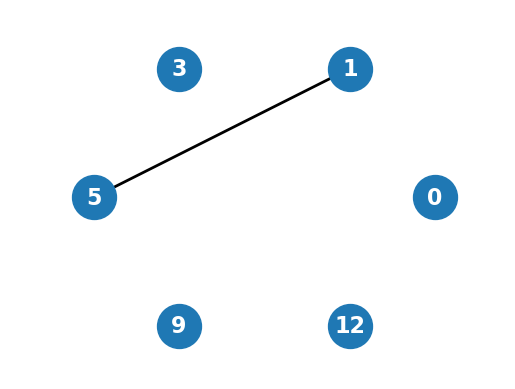

[0, 1, 3, 5, 9, 12]
1/2 [Z0] +
-3 [] +
1/2 [Z1] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1218972, -0.022554122], [1.0575871, 1.174743]]] from old_V = [0, 1, 3, 9, 12] and old_E = [] to new subgraph (new_V = [0, 1, 3, 5, 9, 12], new_E = [(1, 5)]), initial_expectation_value = 4.998630332257594
[0, 1, 3, 5, 9, 12]
====================Circuit Summary====================
|Total number of gates  : 48.                         |
|Parameter gates        : 24.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 3, 5, 9, 12]
1/2 [Z0] +
-3 [] +
1/2 [Z1] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z12] 
initial_ex = 4.998630332257594
weight = [ 1.0575871   3.1218972   1.174743   -0.02255412]
Convergence reached after 6 iterations, with loss evolution: [-4.9986305, -4.9975843, -4.9989038, -4.9999

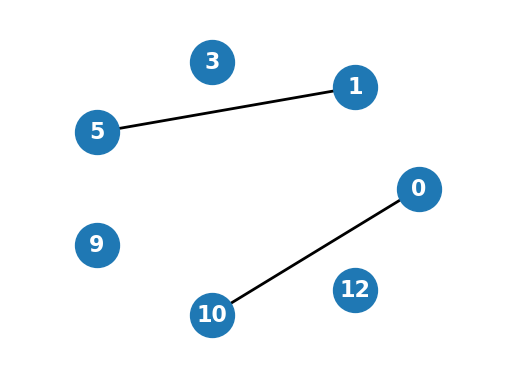

[0, 1, 3, 5, 9, 10, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
Transferring optimized parameters params_opt = [[[3.1279094, -0.011798108], [1.0575871, 1.4394505]]] from old_V = [0, 1, 3, 5, 9, 12] and old_E = [(1, 5)] to new subgraph (new_V = [0, 1, 3, 5, 9, 10, 12], new_E = [(0, 10), (1, 5)]), initial_expectation_value = 4.999652783973467
[0, 1, 3, 5, 9, 10, 12]
====================Circuit Summary====================
|Total number of gates  : 62.                         |
|Parameter gates        : 28.                         |
|with 4 parameters are  :                             |
|gamma1, beta1, gamma2, beta2                        .|
|Number qubit of circuit: 13                          |
None
[0, 1, 3, 5, 9, 10, 12]
1/2 [Z0] +
-7/2 [] +
1/2 [Z1] +
1/2 [Z3] +
1/2 [Z5] +
1/2 [Z9] +
1/2 [Z10] +
1/2 [Z12] 
initial_ex = 4.999652783973467
weight = [ 1.0575871   3.1279094   1.4394505  -0.01179811]
Convergence reached after 7 iterations, wi

In [21]:
p = int(input('Please input the maximum circuit depth:')) # level depth

# delta = float(input('Please input the predefined error:'))
data = []           # Stores the final expectation values (final_value) obtained for different values of p.
iterations_avg = [] # Stores the average number of iterations consumed by AQA for each p.
T = []              # Stores the classical simulation time for AQA (simulated p*20 times) for each p.

qubits0 = []
circuit_depth = []
RX_gates = []
RZ_gates = []
multi_gates = []

for depth in range(1,p+1):
    final_value,avg,delta_t,avg_qubits,avg_depth,avg_RX,avg_RZ,avg_multi = AQA(depth)
    data.append(final_value)
    iterations_avg.append(avg)
    T.append(delta_t)
    qubits0.append(avg_qubits)
    circuit_depth.append(avg_depth)
    RX_gates.append(avg_RX)
    RZ_gates.append(avg_RZ)
    multi_gates.append(avg_multi)
    
    
my_logger.info('data = {}'.format(data))
my_logger.info('iterations_avg = {}'.format(iterations_avg))
my_logger.info('T = {}'.format(T))

In [22]:
my_logger.info('average consumption of qubits : avg_qubits = {}'.format(qubits0))
my_logger.info('average consumption of depth: avg_depth =  {}'.format(circuit_depth))
my_logger.info('average consumption of RX: avg_RX =  {}'.format(RX_gates))
my_logger.info('average consumption of RZ: avg_RZ =  {}'.format(RZ_gates))
my_logger.info('average consumption of multi-controlled gates: multi_gates =  {}'.format(multi_gates))

average consumption of qubits : avg_qubits = [7.0, 7.0]
average consumption of depth: avg_depth =  [16.0, 32.0]
average consumption of RX: avg_RX =  [3.0, 6.0]
average consumption of RZ: avg_RZ =  [7.0, 14.0]
average consumption of multi-controlled gates: multi_gates =  [4.0, 8.0]
